In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
#import uproot
import uproot3
from scipy import optimize as op

In [2]:
#Gain access to functions used to change some of the aspects regarding arrays and the things in them
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Bin\ Conversions.ipynb

#Gain Access to functions used to work with momentum binning
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Momentum\ Bins.ipynb

#Gain Access to functions used to work with Fitting Functions
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Fitting\ Functions.ipynb

#Gain Access to functions used for TH2s 
#uproot or uproo4
#%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH2\ Functions.ipynb
#uproot3
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/TH2\ Functions-uproot3.ipynb

#Gain Access to functions for taking discrete derivatives of lists of data
%run /Users/cmc/analysis_phd/analysis_twopi_clas6/cut_determinations/e16/Derivatives.ipynb

*Bin Conversions*
Available Functions:
Note: All functions return new arrays rather than altering the previous array
	New_Merged_Size(array_,merge_size_) returns what the size of the new merged array will be
	Merge_Bin_Edges(edges_,merge_size) merges the bin edges 
	Merge_Bins(array_,merge_size_) adds together every <merge_size_> values in an array
	Merge_Vals(yarray_,merge_size_) adds together every <merge_size_> ybin together in an array
	Merge_Bins(xarray_,merge_size_) averages every <merge_size_> xbins together in an array
	Count_Non_Zero(array_) counts the number of nonzero values in an array
	Count_Zero(array_) counts the number of zeros in an array
	Remove_Zeros(array_) remove zeros from an array
	Remove_Zeros_Y(yarray_) removes zero values from yarray
	Remove_Zeros_X(xarray_,yarray_) removes xbins where the corresponding y value was zero
	Count_InBounds(yarray_,low_,high_) counts the number of values that fall between bounds (or equal to)
	Count_OutBounds(yarray_,low_,high_) co

In [18]:
#date="06-13-2022"
date="09-26-2023"
#dir="/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_e16/06-13-2022"
dir="/Users/cmc/analysis_phd/root_files/cut_determination/cut_det_e16/"+date
#root_file=dir+"/exp_fid_ele_e16_"+date"_13866481.root"
root_file=dir+"/exp_e16_clas6_fid_pro_"+date+".root"
file=uproot3.open(root_file)

#0-> pid | 1->event selection all 
fid_pro_sel = 1

In [16]:
file['Fiducial']['Fid pro PID Cuts']['Fid pro pid Cut']['Fid pro pid sec1 Cut'].keys()



[b'Fid_pro_pid_sec1_cut_no-weight;1', b'Fid_pro_pid_sec1_anti_no-weight;1']

In [19]:
layer_1='Fiducial'
if fid_pro_sel == 1:
    layer_2 = 'Fid Event pro Selection'
    layer_3 = 'Fid Event pro mall Selection'
    layer_4 = ['Fid Event pro mall sec'+str(sec+1)+' Selection' for sec in range(6)]
    hist_name = ['Fid_pro_event_sec'+str(sec+1)+'_cut_no-weight_mall' for sec in range(6)]
if fid_pro_sel == 0:
    layer_2 = 'Fid pro PID Cuts'
    layer_3 = 'Fid pro pid Cut'
    layer_4 = ['Fid pro pid sec'+str(sec+1)+' Cut' for sec in range(6)]
    hist_name = ['Fid_pro_pid_sec'+str(sec+1)+'_cut_no-weight' for sec in range(6)]

In [20]:
fid_pro_hist = [file[layer_1][layer_2][layer_3][layer_4[sec]][hist_name[sec]] for sec in range(6)] 

In [23]:
#Extract Bin Inf
fid_pro_xbins = Center_Xbins(fid_pro_hist[0])
fid_pro_ybins = Center_Ybins(fid_pro_hist[0])
#Extract Zvals
fid_pro_zvals_xy = [XY_Values(fid_pro_hist[sec]) for sec in range(6)]
fid_pro_zvals_yx = [YX_Values(fid_pro_hist[sec]) for sec in range(6)]
#Determining Cell Merging 
_fid_pro_xmerge=5
_fid_pro_ymerge=2
_fid_pro_xname="phi (deg)"
_fid_pro_yname="theta (deg)"
#Merge -> No Zeros
fid_pro_x = Merge_Bins(fid_pro_xbins,_fid_pro_xmerge)
fid_pro_y = Merge_Bins(fid_pro_ybins,_fid_pro_ymerge)
print(len(fid_pro_x))
print(len(fid_pro_y))
fid_pro_xedges = Merge_Bin_Edges(XEdges_2d(fid_pro_hist[0]),_fid_pro_xmerge)
fid_pro_yedges = Merge_Bin_Edges(YEdges_2d(fid_pro_hist[0]),_fid_pro_ymerge)
fid_pro_z_xy=[Merge_Z(fid_pro_zvals_xy[sec],_fid_pro_xmerge,_fid_pro_ymerge) for sec in range(6)]
fid_pro_z_yx=[Merge_Z(fid_pro_zvals_yx[sec],_fid_pro_ymerge,_fid_pro_xmerge) for sec in range(6)]



80
150


In [26]:
dumb1_x= np.zeros((6,len(fid_pro_x)*len(fid_pro_y)))
dumb1_y= np.zeros((6,len(fid_pro_x)*len(fid_pro_y)))
dense1 = np.zeros((6,len(fid_pro_x)*len(fid_pro_y)))
dumb2_x= np.zeros((6,len(fid_pro_x)*len(fid_pro_y)))
dumb2_y= np.zeros((6,len(fid_pro_x)*len(fid_pro_y)))
dense2 = np.zeros((6,len(fid_pro_x)*len(fid_pro_y)))
for sec in range(6):
    for i in range(len(fid_pro_x)):
        for j in range(len(fid_pro_y)):
            dumb1_x[sec][i+j*len(fid_pro_x)]+=fid_pro_x[i]
            dumb1_y[sec][i+j*len(fid_pro_x)]+=fid_pro_y[j]
            dense1[sec][i+j*len(fid_pro_x)]+=fid_pro_z_xy[sec][i][j]
            dumb2_x[sec][j+i*len(fid_pro_y)]+=fid_pro_y[j]
            dumb2_y[sec][j+i*len(fid_pro_y)]+=fid_pro_x[i]
            dense2[sec][j+i*len(fid_pro_y)]+=fid_pro_z_yx[sec][j][i]

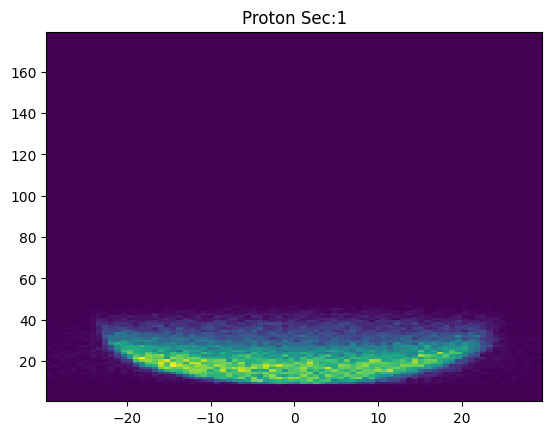

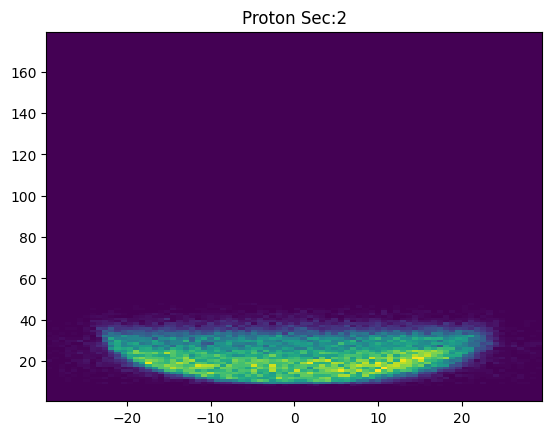

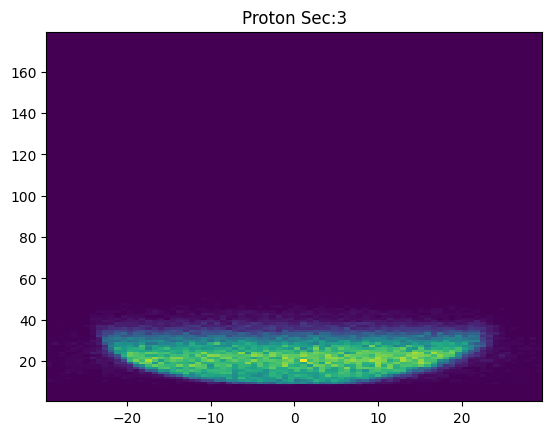

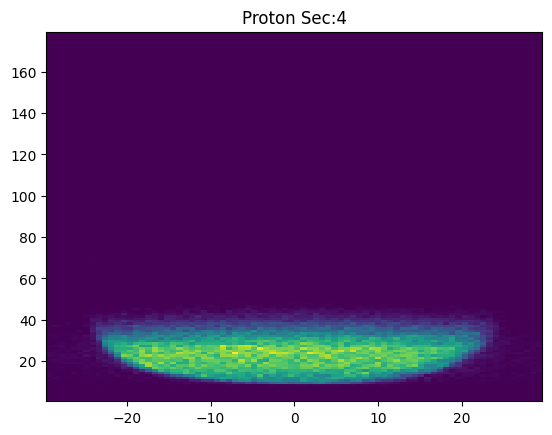

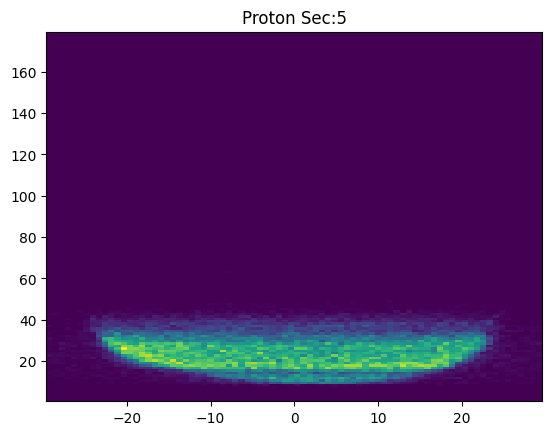

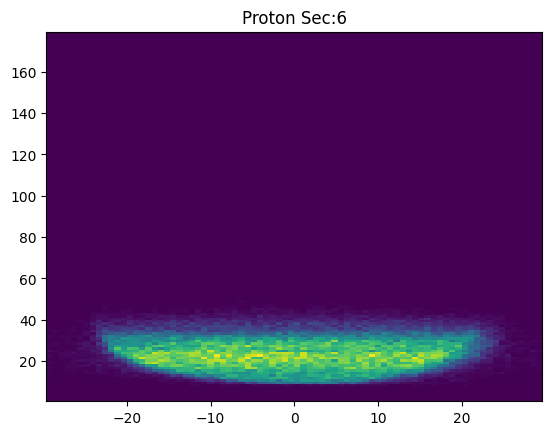

In [28]:
for sec in range(6):
    plt.hist2d(dumb1_x[sec], dumb1_y[sec], bins=(len(fid_pro_x), len(fid_pro_y)), weights=dense1[sec])
    plt.title("Proton Sec:{}".format(sec+1))
    plt.show()

In [29]:
#Y slices will be needed
fid_pro_fit_x = [[Remove_Zeros_X(fid_pro_x,fid_pro_z_yx[sec][ybin]) for ybin in range(len(fid_pro_y))] for sec in range(6)]
fid_pro_fit_y = [[Remove_Zeros_Y(fid_pro_z_yx[sec][ybin]) for ybin in range(len(fid_pro_y))] for sec in range(6)]


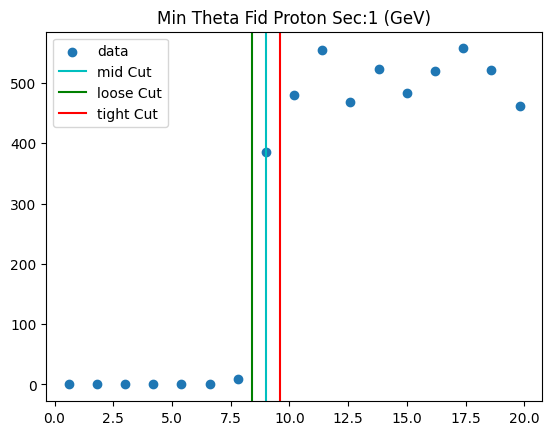

9.0


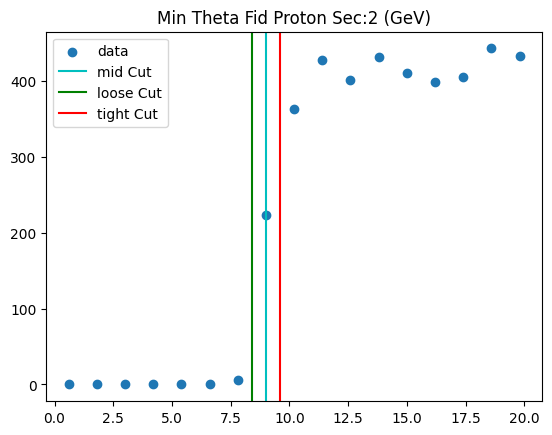

9.0


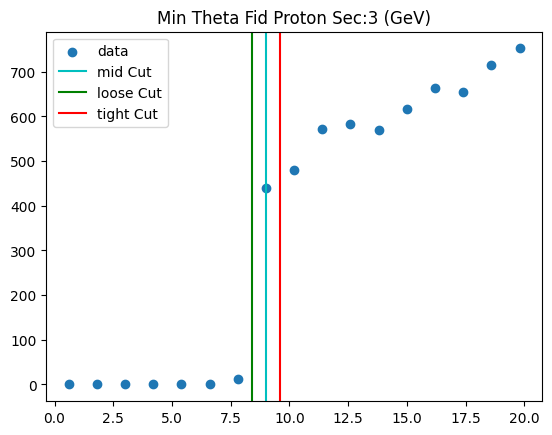

9.0


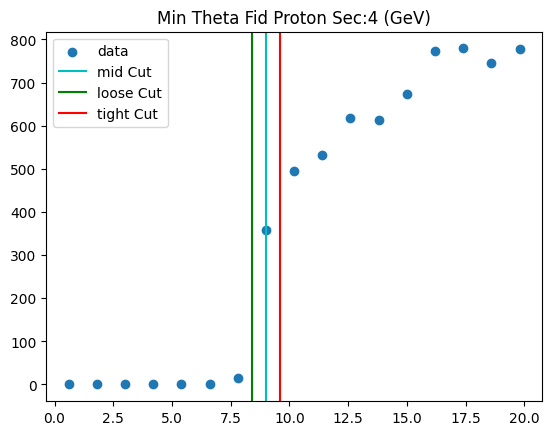

9.0


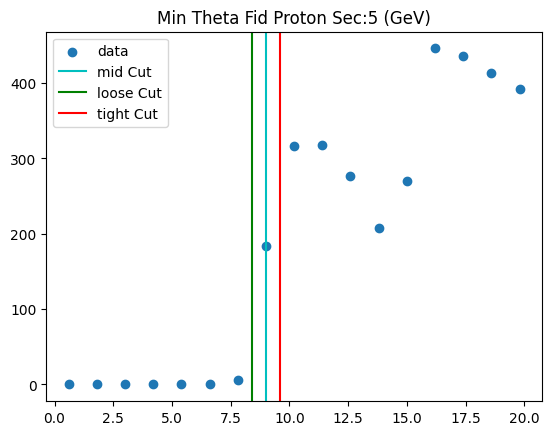

9.0


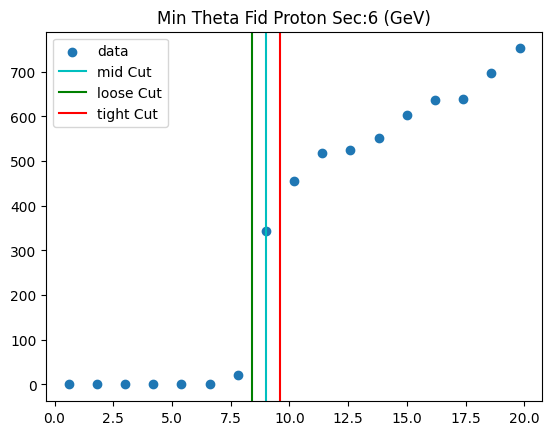

9.0


In [83]:
min_theta_y = np.array([[ Bounds_on_X_From_Y(fid_pro_fit_y[sec][theta_bin],fid_pro_fit_x[sec][theta_bin],-2.0,2.0).sum() for theta_bin in range(len(fid_pro_y))] for sec in range(6)])
#Part 1: Minimum Theta
ini_c1 = 12.0
ini_c2 = 25.0
ini_pshift = 0.36


min_frac = 0.95
low_frac = 0.8
top_frac = 0.99

#theta = [fid_ele_y[theta_bin] for theta_bin in range(len(fid_ele_y))]

if fid_ele_sel == 1:
    ini_skew = 10
    ini_loc = 36
    ini_scale=7
    ini_norm = 300
else:
    ini_skew = 10
    ini_loc = 36
    ini_scale=7
    ini_norm = 200000

min_theta_fit = np.zeros((6,4))
min_theta_vals = np.zeros((6))
min_theta_fit_low = np.zeros((6,4))
min_theta_vals_low = np.zeros((6))
min_theta_fit_top = np.zeros((6,4))
min_theta_vals_top = np.zeros((6))

par_bounds = [[0.0,0.0,0.0,0.0],[100.0,100.0,100.0,np.inf]]

for sec in range(6):
    ini_pars= [ini_skew,ini_loc,ini_scale,ini_norm]
    if min_theta_y[sec].sum() >100:
        xvals = Bounds_on_Y(fid_pro_y,0,20)
        yvals = Bounds_on_X_From_Y(min_theta_y[sec],fid_pro_y,0,20)
        plt.scatter(xvals,yvals,label="data")
        for i in range(len(xvals)-2):
            if yvals[i] ==0 and yvals[i+1] >0 and yvals[i+2] > 5*yvals[i+1]:
                if yvals[i+2]>100:
                    min_theta_vals[sec] = xvals[i+2]
                    min_theta_vals_low[sec] = xvals[i+2]-(xvals[i+2]-xvals[i+1])/2
                    min_theta_vals_top[sec] = xvals[i+2]+(xvals[i+2]-xvals[i+1])/2
                else:
                    min_theta_vals[sec] = xvals[i+3]
                    min_theta_vals_low[sec] = xvals[i+3]-(xvals[i+2]-xvals[i+1])/2
                    min_theta_vals_top[sec] = xvals[i+3]+(xvals[i+2]-xvals[i+1])/2
        plt.axvline(x = min_theta_vals[sec], color = 'c', label = 'mid Cut')
        plt.axvline(x = min_theta_vals_low[sec], color = 'g', label = 'loose Cut')
        plt.axvline(x = min_theta_vals_top[sec], color = 'r', label = 'tight Cut')
        #try:
        #    pars, pars_cov = op.curve_fit(skew_norm,xvals,yvals,p0=ini_pars,bounds=par_bounds,maxfev=5000)
        #    cont_x = np.linspace(xvals[0],xvals[len(xvals)-1],400)
        #    plt.plot(cont_x, skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]),label="fit")
        #    for i in range(4):
        #        ini_pars[i] = pars[i]
        #        min_theta_fit[sec][i] = pars[i]
        ##    print(pars)
         #   max_y = np.amax(skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]))
         #   max_x = cont_x[np.argmax(skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]))]
         #   plt.axvline(x = cont_x[np.argmax(skew_norm(cont_x,pars[0],pars[1],pars[2],pars[3]))], color = 'b', label = 'Skew Max')#

        #    for i in range(len(cont_x)-1):
        #        if skew_norm(cont_x[i],pars[0],pars[1],pars[2],pars[3]) <=min_frac*max_y and skew_norm(cont_x[i+1],pars[0],pars[1],pars[2],pars[3]) > min_frac*max_y:
        #            min_theta_vals[sec] = cont_x[i]
        #            plt.axvline(x = cont_x[i], color = 'c', label = 'Middle Cut')
        #        if skew_norm(cont_x[i],pars[0],pars[1],pars[2],pars[3]) <=low_frac*max_y and skew_norm(cont_x[i+1],pars[0],pars[1],pars[2],pars[3]) > low_frac*max_y:
        #            min_theta_vals_low[sec] = cont_x[i]
        #            plt.axvline(x = cont_x[i], color = 'g', label = 'Low Cut')
        #        if skew_norm(cont_x[i],pars[0],pars[1],pars[2],pars[3]) <=top_frac*max_y and skew_norm(cont_x[i+1],pars[0],pars[1],pars[2],pars[3]) > top_frac*max_y:
        #            min_theta_vals_top[sec] = cont_x[i]
        #            plt.axvline(x = cont_x[i], color = 'r', label = 'Top Cut')
        #except RuntimeError:
        #    print("Runtime Error")
        plt.legend()
        plt.title("Min Theta Fid Proton Sec:{} (GeV)".format(sec+1))
        plt.show()
    print(min_theta_vals[sec])                                                                                                                 
   

==========Sec  1 ===============
...........Theta: 9.0 ............
Binning| Sec: 0  Ybin: 7
Sum of plot 1207.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 1116.0
max at  80.0
initial max 600.0
initial guesses: [80.0, 0.0, 10.0, 2.0]
fit bounds [-10.0, 10.0]
(array([66.71429242,  0.87333745,  5.16758624,  2.51836734]), array([[ 1.18055724e+01,  3.09523789e-02, -4.05170719e-01,
        -1.07311564e+00],
       [ 3.09523789e-02,  5.62578281e-02,  3.39380623e-03,
        -1.09256189e-02],
       [-4.05170719e-01,  3.39380623e-03,  5.61659679e-02,
         1.37586893e-02],
       [-1.07311564e+00, -1.09256189e-02,  1.37586893e-02,
         2.35443524e-01]]))
[66.71429242  0.87333745  5.16758624  2.51836734]
[66.71429242  0.87333745  5.16758624  2.51836734]
New Bounds for next fit: [-12.528553844088433, 14.275228735449234]


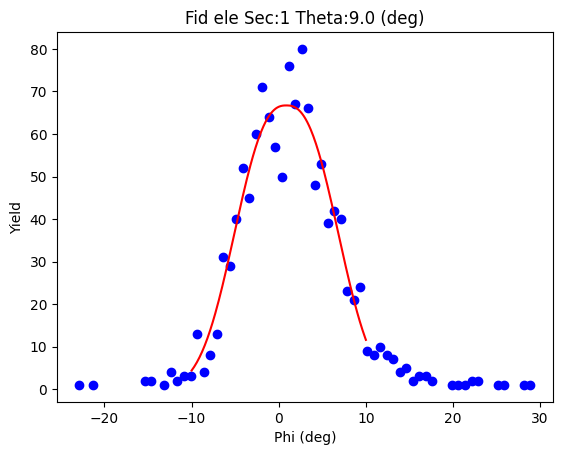

...........Theta: 10.2 ............
Binning| Sec: 0  Ybin: 8
Sum of plot 1989.0
Initial Bounds: [-12.528553844088433, 14.275228735449234]
Sum of initial fit area: 1940.0
max at  95.0
initial max 66.71429241992024
initial guesses: [95.0, 0.8733374456804003, 5.167586241573934, 2.5183673428240594]
fit bounds [-12.528553844088433, 14.275228735449234]
(array([78.84185003,  0.63189989,  7.26124028,  3.84114194]), array([[ 5.70257360e+00, -1.06758092e-03, -1.70029384e-01,
        -6.75385715e-01],
       [-1.06758092e-03,  3.85931307e-02, -1.12552949e-04,
         6.36009402e-04],
       [-1.70029384e-01, -1.12552949e-04,  2.88370712e-02,
         5.86208288e-03],
       [-6.75385715e-01,  6.36009402e-04,  5.86208288e-03,
         2.63174287e-01]]))
[78.84185003  0.63189989  7.26124028  3.84114194]
[78.84185003  0.63189989  7.26124028  3.84114194]
New Bounds for next fit: [-14.650610072963987, 15.91440985962486]


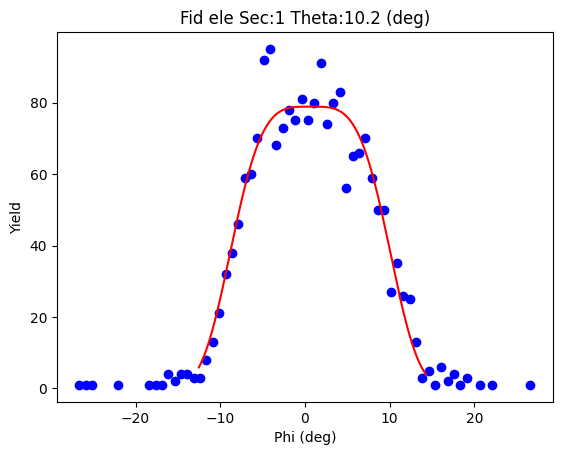

...........Theta: 11.4 ............
Binning| Sec: 0  Ybin: 9
Sum of plot 2572.0
Initial Bounds: [-14.650610072963987, 15.91440985962486]
Sum of initial fit area: 2517.0
max at  102.0
initial max 78.8418500264208
initial guesses: [102.0, 0.6318998933304364, 7.261240277654863, 3.8411419430465967]
fit bounds [-14.650610072963987, 15.91440985962486]
(array([86.11461087,  0.16293971,  8.4158215 ,  5.10504301]), array([[ 6.69793524e+00, -8.83347513e-04, -1.63901391e-01,
        -9.87191256e-01],
       [-8.83347513e-04,  4.79402823e-02, -9.39712342e-05,
         7.94932778e-04],
       [-1.63901391e-01, -9.39712342e-05,  3.20445088e-02,
         7.10837302e-05],
       [-9.87191256e-01,  7.94932778e-04,  7.10837302e-05,
         6.04013536e-01]]))
[86.11461087  0.16293971  8.4158215   5.10504301]
[86.11461087  0.16293971  8.4158215   5.10504301]
New Bounds for next fit: [-15.889136726108537, 16.21501615021109]


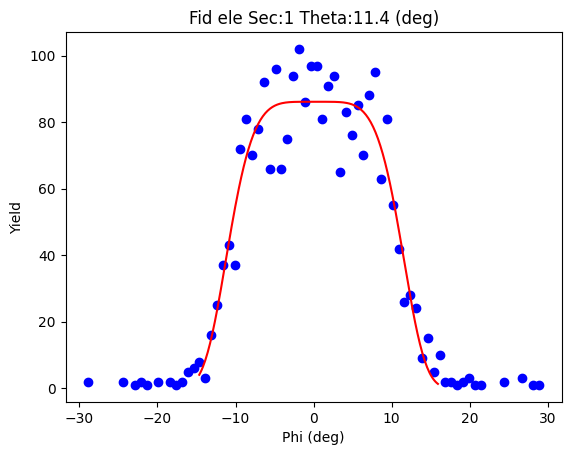

...........Theta: 12.6 ............
Binning| Sec: 0  Ybin: 10
Sum of plot 2865.0
Initial Bounds: [-15.889136726108537, 16.21501615021109]
Sum of initial fit area: 2797.0
max at  97.0
initial max 86.11461086703201
initial guesses: [97.0, 0.1629397120512748, 8.415821504065187, 5.10504300613837]
fit bounds [-15.889136726108537, 16.21501615021109]
(array([81.41368666, -0.10090758,  9.6958344 ,  7.33666637]), array([[ 3.77966536e+00, -2.62777918e-03, -7.40249421e-02,
        -9.26988146e-01],
       [-2.62777918e-03,  3.48525116e-02, -4.90240627e-04,
         5.45978592e-03],
       [-7.40249421e-02, -4.90240627e-04,  2.18575832e-02,
        -2.15549253e-02],
       [-9.26988146e-01,  5.45978592e-03, -2.15549253e-02,
         1.25690856e+00]]))
[81.41368666 -0.10090758  9.6958344   7.33666637]
[81.41368666 -0.10090758  9.6958344   7.33666637]
New Bounds for next fit: [-16.98593198839673, 16.784116819899992]


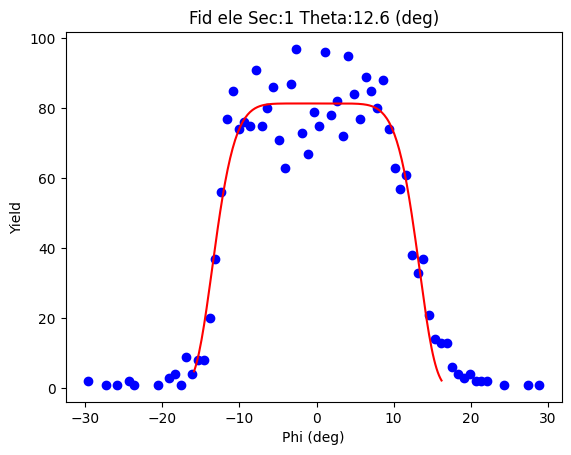

...........Theta: 13.8 ............
Binning| Sec: 0  Ybin: 11
Sum of plot 3360.0
Initial Bounds: [-16.98593198839673, 16.784116819899992]
Sum of initial fit area: 3279.0
max at  95.0
initial max 81.41368665726381
initial guesses: [95.0, -0.10090758424836731, 9.695834402159088, 7.336666370362941]
fit bounds [-16.98593198839673, 16.784116819899992]
(array([85.0565882 , -0.21210658, 10.70883305, 10.72259785]), array([[ 1.99727177e+00,  5.37665623e-04, -2.78644978e-02,
        -7.16415954e-01],
       [ 5.37665623e-04,  1.64897990e-02,  1.13494635e-04,
        -2.25102623e-03],
       [-2.78644978e-02,  1.13494635e-04,  9.89584423e-03,
        -2.72060373e-02],
       [-7.16415954e-01, -2.25102623e-03, -2.72060373e-02,
         1.97353010e+00]]))
[85.0565882  -0.21210658 10.70883305 10.72259785]
[85.0565882  -0.21210658 10.70883305 10.72259785]
New Bounds for next fit: [-17.6748345768429, 17.25062142251117]


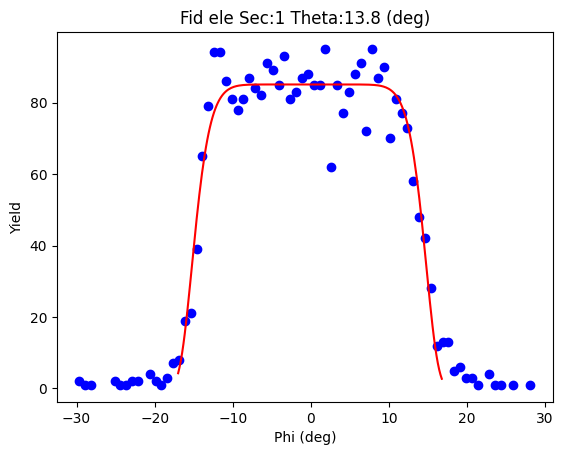

...........Theta: 15.0 ............
Binning| Sec: 0  Ybin: 12
Sum of plot 3741.0
Initial Bounds: [-17.6748345768429, 17.25062142251117]
Sum of initial fit area: 3625.0
max at  108.0
initial max 85.05658819574042
initial guesses: [108.0, -0.21210657716586612, 10.708833052260394, 10.722597845307378]
fit bounds [-17.6748345768429, 17.25062142251117]
(array([85.88203683, -0.41931001, 11.72535148, 12.        ]), array([[ 3.73622087e+00, -1.06160125e-03, -3.85884158e-02,
        -1.69817567e+00],
       [-1.06160125e-03,  3.53606403e-02, -3.72348896e-04,
         6.43060361e-03],
       [-3.85884158e-02, -3.72348896e-04,  2.31749072e-02,
        -1.30156729e-01],
       [-1.69817567e+00,  6.43060361e-03, -1.30156729e-01,
         6.27809755e+00]]))
[85.88203683 -0.41931001 11.72535148 12.        ]
[85.88203683 -0.41931001 11.72535148 12.        ]
New Bounds for next fit: [-19.251955943310488, 18.413335925707496]


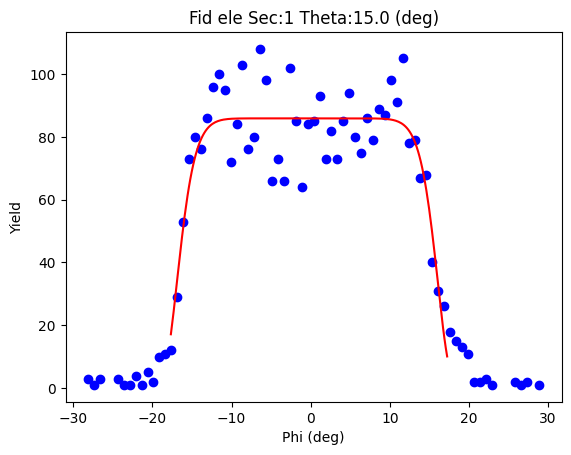

...........Theta: 16.2 ............
Binning| Sec: 0  Ybin: 13
Sum of plot 4176.0
Initial Bounds: [-19.251955943310488, 18.413335925707496]
Sum of initial fit area: 4087.0
max at  109.0
initial max 85.88203683178128
initial guesses: [109.0, -0.4193100088014941, 11.725351477806623, 11.999999999999988]
fit bounds [-19.251955943310488, 18.413335925707496]
(array([90.3509924 , -0.21020862, 12.55329516, 12.        ]), array([[ 2.94657020e+00,  1.96246627e-03, -3.57429861e-02,
        -1.20075339e+00],
       [ 1.96246627e-03,  2.81829135e-02,  6.04930112e-04,
        -1.06526257e-02],
       [-3.57429861e-02,  6.04930112e-04,  1.75164054e-02,
        -7.41433030e-02],
       [-1.20075339e+00, -1.06526257e-02, -7.41433030e-02,
         4.05956865e+00]]))
[90.3509924  -0.21020862 12.55329516 12.        ]
[90.3509924  -0.21020862 12.55329516 12.        ]
New Bounds for next fit: [-20.372654362755277, 19.952237120382307]


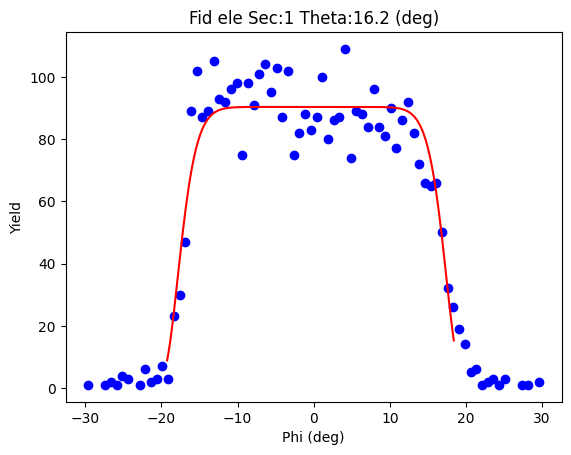

...........Theta: 17.4 ............
Binning| Sec: 0  Ybin: 14
Sum of plot 4420.0
Initial Bounds: [-20.372654362755277, 19.952237120382307]
Sum of initial fit area: 4360.0
max at  117.0
initial max 90.35099240041048
initial guesses: [117.0, -0.2102086211864844, 12.553295155350307, 11.999999999999964]
fit bounds [-20.372654362755277, 19.952237120382307]
(array([91.21323718, -0.3222089 , 13.2768544 , 12.        ]), array([[ 2.71901944e+00, -3.40045122e-03, -3.42959465e-02,
        -1.09878609e+00],
       [-3.40045122e-03,  2.87764229e-02, -1.13049829e-03,
         1.84842421e-02],
       [-3.42959465e-02, -1.13049829e-03,  1.79256897e-02,
        -7.30493016e-02],
       [-1.09878609e+00,  1.84842421e-02, -7.30493016e-02,
         3.69286048e+00]]))
[91.21323718 -0.3222089  13.2768544  12.        ]
[91.21323718 -0.3222089  13.2768544  12.        ]
New Bounds for next fit: [-21.64679763820724, 21.002379837952226]


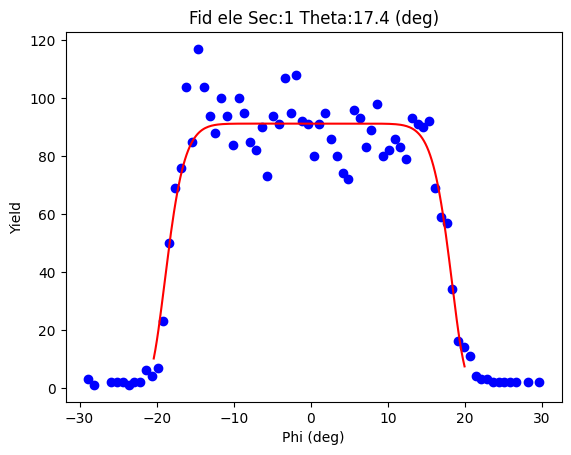

...........Theta: 18.6 ............
Binning| Sec: 0  Ybin: 15
Sum of plot 4450.0
Initial Bounds: [-21.64679763820724, 21.002379837952226]
Sum of initial fit area: 4397.0
max at  114.0
initial max 91.21323717579449
initial guesses: [114.0, -0.32220890012750736, 13.276854401828412, 11.999999999999998]
fit bounds [-21.64679763820724, 21.002379837952226]
(array([8.73211774e+01, 4.16955640e-02, 1.39991934e+01, 1.20000000e+01]), array([[ 3.31050034e+00,  5.42397763e-03, -4.58536498e-02,
        -1.39731690e+00],
       [ 5.42397763e-03,  4.27070179e-02,  2.01969694e-03,
        -3.09929339e-02],
       [-4.58536498e-02,  2.01969694e-03,  2.66257140e-02,
        -1.03720706e-01],
       [-1.39731690e+00, -3.09929339e-02, -1.03720706e-01,
         4.91396353e+00]]))
[8.73211774e+01 4.16955640e-02 1.39991934e+01 1.20000000e+01]
[8.73211774e+01 4.16955640e-02 1.39991934e+01 1.20000000e+01]
New Bounds for next fit: [-22.443076329996362, 22.526467458023614]


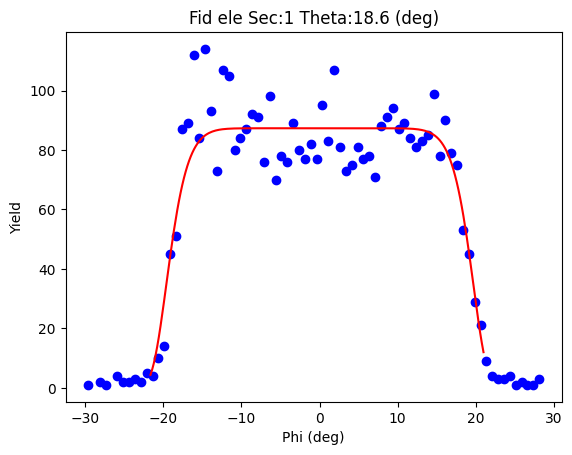

...........Theta: 19.8 ............
Binning| Sec: 0  Ybin: 16
Sum of plot 4439.0
Initial Bounds: [-22.443076329996362, 22.526467458023614]
Sum of initial fit area: 4415.0
max at  113.0
initial max 87.3211773860175
initial guesses: [113.0, 0.041695564013624925, 13.999193436354942, 11.999999999999998]
fit bounds [-22.443076329996362, 22.526467458023614]
(array([84.62188041, -0.1913156 , 14.49379993, 12.        ]), array([[ 4.61834527e+00, -1.83166455e-03, -7.67087252e-02,
        -1.90174844e+00],
       [-1.83166455e-03,  6.56930738e-02, -5.73808633e-04,
         9.86941147e-03],
       [-7.67087252e-02, -5.73808633e-04,  3.93073264e-02,
        -1.12254323e-01],
       [-1.90174844e+00,  9.86941147e-03, -1.12254323e-01,
         6.62779638e+00]]))
[84.62188041 -0.1913156  14.49379993 12.        ]
[84.62188041 -0.1913156  14.49379993 12.        ]
New Bounds for next fit: [-23.470498563363016, 23.08786736841934]


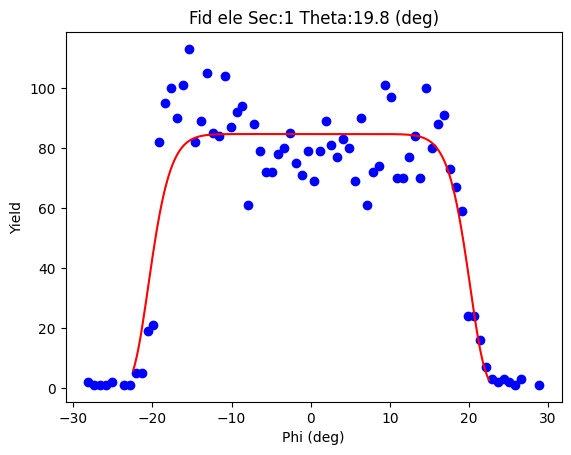

...........Theta: 21.0 ............
Binning| Sec: 0  Ybin: 17
Sum of plot 4217.0
Initial Bounds: [-23.470498563363016, 23.08786736841934]
Sum of initial fit area: 4183.0
max at  116.0
initial max 84.62188040638692
initial guesses: [116.0, -0.19131559747183685, 14.493799933395255, 11.999999999999998]
fit bounds [-23.470498563363016, 23.08786736841934]
(array([76.70980247, -0.17259777, 15.16949644, 12.        ]), array([[ 4.34191909e+00, -2.88391542e-03, -7.82295027e-02,
        -2.04119810e+00],
       [-2.88391542e-03,  8.33788010e-02, -1.19913397e-03,
         1.80567888e-02],
       [-7.82295027e-02, -1.19913397e-03,  5.10320880e-02,
        -1.63588159e-01],
       [-2.04119810e+00,  1.80567888e-02, -1.63588159e-01,
         8.01915119e+00]]))
[76.70980247 -0.17259777 15.16949644 12.        ]
[76.70980247 -0.17259777 15.16949644 12.        ]
New Bounds for next fit: [-24.537049096275137, 24.19185356533386]


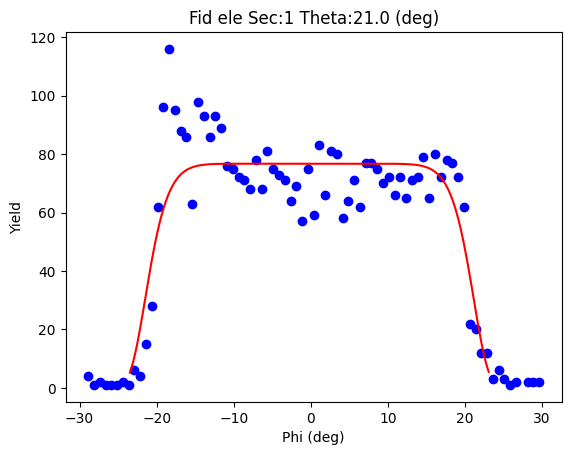

...........Theta: 22.2 ............
Binning| Sec: 0  Ybin: 18
Sum of plot 4038.0
Initial Bounds: [-24.537049096275137, 24.19185356533386]
Sum of initial fit area: 4012.0
max at  98.0
initial max 76.70980246793198
initial guesses: [98.0, -0.17259776547063654, 15.169496437784773, 11.999999999999998]
fit bounds [-24.537049096275137, 24.19185356533386]
(array([71.97870483,  0.09641982, 15.50457791, 12.        ]), array([[ 3.85099537e+00,  2.59155541e-03, -8.20136154e-02,
        -1.84045093e+00],
       [ 2.59155541e-03,  8.64443713e-02,  9.63770062e-04,
        -1.60733734e-02],
       [-8.20136154e-02,  9.63770062e-04,  5.13864423e-02,
        -1.29596598e-01],
       [-1.84045093e+00, -1.60733734e-02, -1.29596598e-01,
         7.49038936e+00]]))
[71.97870483  0.09641982 15.50457791 12.        ]
[71.97870483  0.09641982 15.50457791 12.        ]
New Bounds for next fit: [-24.806221839594397, 24.999061478547883]


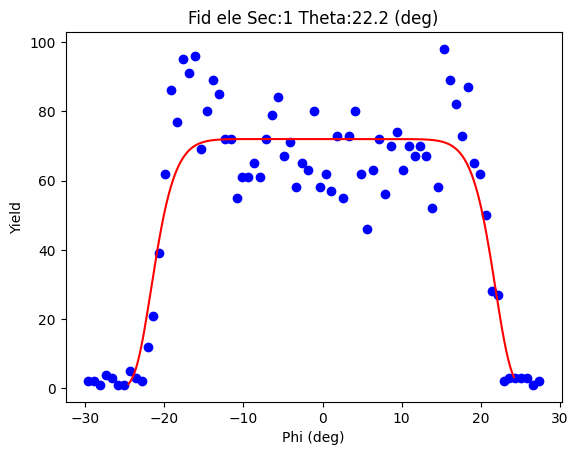

...........Theta: 23.4 ............
Binning| Sec: 0  Ybin: 19
Sum of plot 3784.0
Initial Bounds: [-24.806221839594397, 24.999061478547883]
Sum of initial fit area: 3764.0
max at  99.0
initial max 71.97870482623365
initial guesses: [99.0, 0.09641981947674222, 15.50457791188179, 11.999999999999998]
fit bounds [-24.806221839594397, 24.999061478547883]
(array([65.55314242,  0.12422473, 16.00849203, 12.        ]), array([[ 3.79194181e+00,  1.50537183e-03, -8.85332902e-02,
        -2.03296412e+00],
       [ 1.50537183e-03,  1.09903750e-01,  7.01472084e-04,
        -1.06347142e-02],
       [-8.85332902e-02,  7.01472084e-04,  6.60981933e-02,
        -1.77876391e-01],
       [-2.03296412e+00, -1.06347142e-02, -1.77876391e-01,
         9.19203269e+00]]))
[65.55314242  0.12422473 16.00849203 12.        ]
[65.55314242  0.12422473 16.00849203 12.        ]
New Bounds for next fit: [-25.58777741283808, 25.83622688235029]


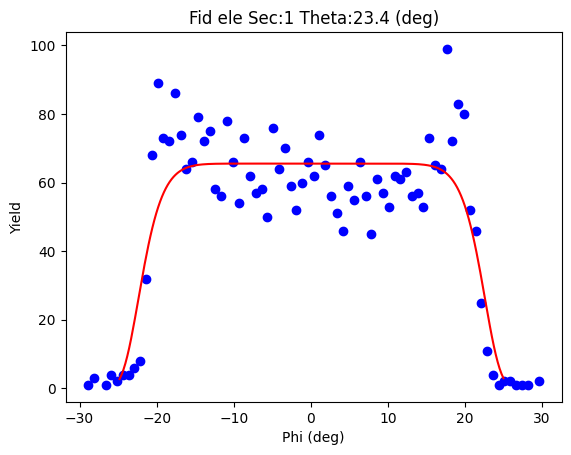

...........Theta: 24.6 ............
Binning| Sec: 0  Ybin: 20
Sum of plot 3622.0
Initial Bounds: [-25.58777741283808, 25.83622688235029]
Sum of initial fit area: 3606.0
max at  86.0
initial max 65.55314242404121
initial guesses: [86.0, 0.12422473475610317, 16.008492031713057, 11.999999999999998]
fit bounds [-25.58777741283808, 25.83622688235029]
(array([61.4211228 ,  0.16145881, 16.35196481, 12.        ]), array([[ 2.79739390e+00,  1.04263635e-03, -7.33714235e-02,
        -1.57178250e+00],
       [ 1.04263635e-03,  9.58362360e-02,  4.87281654e-04,
        -7.62595282e-03],
       [-7.33714235e-02,  4.87281654e-04,  5.70302551e-02,
        -1.37573934e-01],
       [-1.57178250e+00, -7.62595282e-03, -1.37573934e-01,
         7.50309791e+00]]))
[61.4211228   0.16145881 16.35196481 12.        ]
[61.4211228   0.16145881 16.35196481 12.        ]
New Bounds for next fit: [-26.102211330210856, 26.425128959310236]


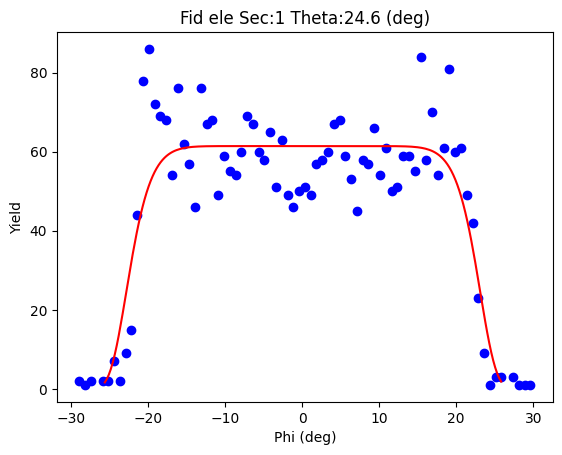

...........Theta: 25.8 ............
Binning| Sec: 0  Ybin: 21
Sum of plot 3439.0
Initial Bounds: [-26.102211330210856, 26.425128959310236]
Sum of initial fit area: 3431.0
max at  73.0
initial max 61.42112279680003
initial guesses: [73.0, 0.1614588145496896, 16.351964807037756, 11.999999999999998]
fit bounds [-26.102211330210856, 26.425128959310236]
(array([57.29697566,  0.19355267, 16.67907089, 12.        ]), array([[ 1.99576964e+00,  5.88596342e-04, -5.84353877e-02,
        -1.18575533e+00],
       [ 5.88596342e-04,  8.14639006e-02,  2.77153489e-04,
        -4.48331907e-03],
       [-5.84353877e-02,  2.77153489e-04,  4.81376376e-02,
        -1.06379676e-01],
       [-1.18575533e+00, -4.48331907e-03, -1.06379676e-01,
         6.02096393e+00]]))
[57.29697566  0.19355267 16.67907089 12.        ]
[57.29697566  0.19355267 16.67907089 12.        ]
New Bounds for next fit: [-26.59549815542468, 26.982603489407936]


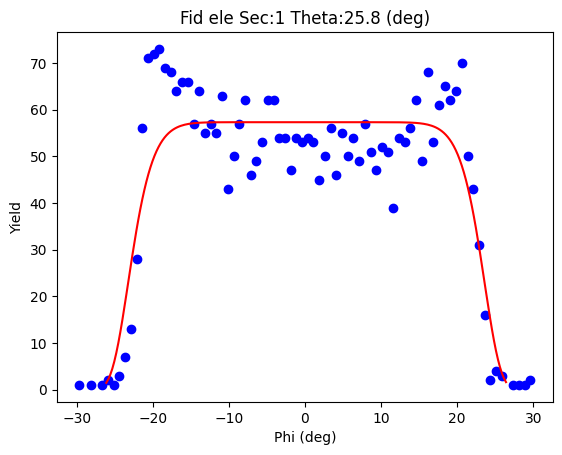

...........Theta: 27.0 ............
Binning| Sec: 0  Ybin: 22
Sum of plot 3227.0
Initial Bounds: [-26.59549815542468, 26.982603489407936]
Sum of initial fit area: 3217.0
max at  78.0
initial max 57.29697565576894
initial guesses: [78.0, 0.19355266699162785, 16.679070893276755, 11.999999999999998]
fit bounds [-26.59549815542468, 26.982603489407936]
(array([52.9093044 ,  0.37459544, 16.93092322, 12.        ]), array([[ 2.54047764e+00, -1.74317994e-06, -8.18501610e-02,
        -1.63370758e+00],
       [-1.74317994e-06,  1.25263621e-01, -8.98181708e-07,
         1.43658834e-05],
       [-8.18501610e-02, -8.98181708e-07,  7.39922523e-02,
        -1.60470274e-01],
       [-1.63370758e+00,  1.43658834e-05, -1.60470274e-01,
         8.97950339e+00]]))
[52.9093044   0.37459544 16.93092322 12.        ]
[52.9093044   0.37459544 16.93092322 12.        ]
New Bounds for next fit: [-26.818967412170576, 27.568158291775614]


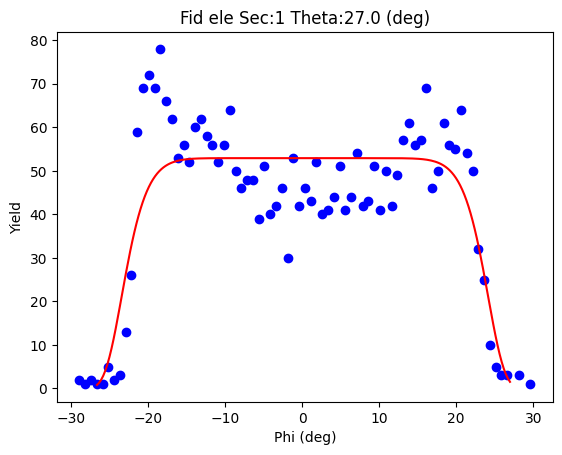

...........Theta: 28.2 ............
Binning| Sec: 0  Ybin: 23
Sum of plot 2699.0
Initial Bounds: [-26.818967412170576, 27.568158291775614]
Sum of initial fit area: 2695.0
max at  71.0
initial max 52.90930440232423
initial guesses: [71.0, 0.37459543980251936, 16.930923221412073, 11.999999999999998]
fit bounds [-26.818967412170576, 27.568158291775614]
(array([43.56231663, -0.09465339, 17.33373599, 12.        ]), array([[ 2.70177868, -0.01752663, -0.09211816, -2.25502478],
       [-0.01752663,  0.24072853, -0.03435841,  0.27893551],
       [-0.09211816, -0.03435841,  0.15247676, -0.50900075],
       [-2.25502478,  0.27893551, -0.50900075, 16.26614226]]))
[43.56231663 -0.09465339 17.33373599 12.        ]
[43.56231663 -0.09465339 17.33373599 12.        ]
New Bounds for next fit: [-27.935193031847998, 27.74588625823758]


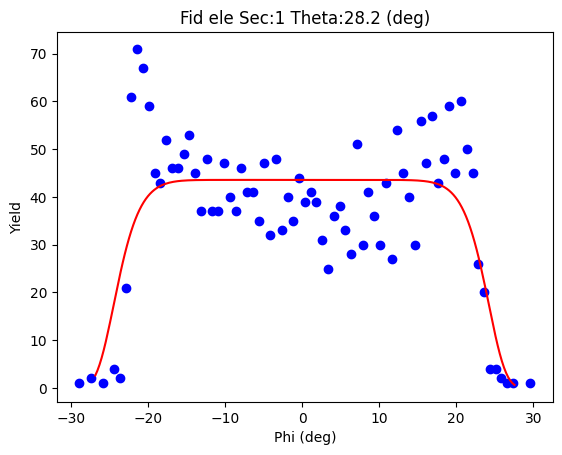

...........Theta: 29.4 ............
Binning| Sec: 0  Ybin: 24
Sum of plot 2478.0
Initial Bounds: [-27.935193031847998, 27.74588625823758]
Sum of initial fit area: 2472.0
max at  62.0
initial max 43.562316630910196
initial guesses: [62.0, -0.09465338680521067, 17.33373599254933, 11.999999999999998]
fit bounds [-27.935193031847998, 27.74588625823758]
(array([40.06730575,  0.06620032, 17.19893432, 12.        ]), array([[ 1.73794534e+00, -5.98913447e-03, -7.04127679e-02,
        -1.51556138e+00],
       [-5.98913447e-03,  1.60472727e-01, -7.37655984e-03,
         8.14859259e-02],
       [-7.04127679e-02, -7.37655984e-03,  9.75411119e-02,
        -2.61392221e-01],
       [-1.51556138e+00,  8.14859259e-02, -2.61392221e-01,
         1.13454774e+01]]))
[40.06730575  0.06620032 17.19893432 12.        ]
[40.06730575  0.06620032 17.19893432 12.        ]
New Bounds for next fit: [-27.557827934450092, 27.69022858432208]


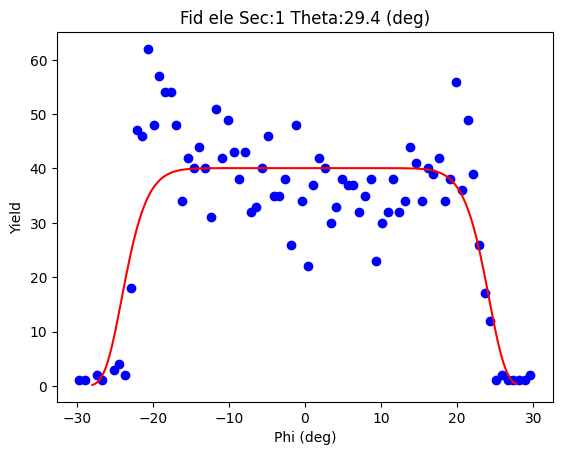

...........Theta: 30.6 ............
Binning| Sec: 0  Ybin: 25
Sum of plot 2113.0
Initial Bounds: [-27.557827934450092, 27.69022858432208]
Sum of initial fit area: 2107.0
max at  53.0
initial max 40.067305750960344
initial guesses: [53.0, 0.06620032493599493, 17.198934323968075, 11.999999999999998]
fit bounds [-27.557827934450092, 27.69022858432208]
(array([33.88053005, -0.10816481, 17.29436205, 12.        ]), array([[ 1.18734432e+00, -8.44062776e-05, -6.23007462e-02,
        -1.17440302e+00],
       [-8.44062776e-05,  1.48580458e-01, -5.91325272e-05,
         1.02859986e-03],
       [-6.23007462e-02, -5.91325272e-05,  8.71857160e-02,
        -1.71988386e-01],
       [-1.17440302e+00,  1.02859986e-03, -1.71988386e-01,
         1.00021666e+01]]))
[33.88053005 -0.10816481 17.29436205 12.        ]
[33.88053005 -0.10816481 17.29436205 12.        ]
New Bounds for next fit: [-27.88546409051808, 27.669134468426282]


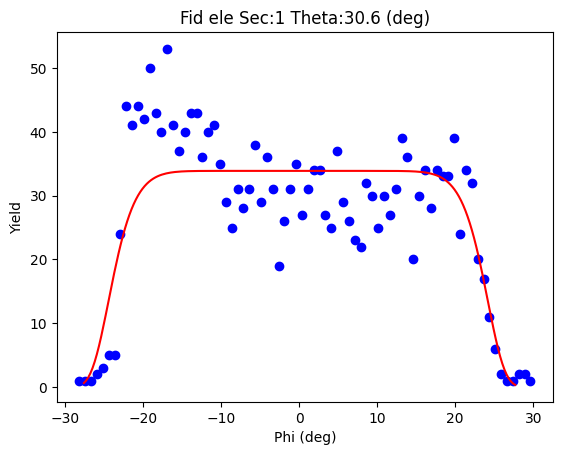

...........Theta: 31.8 ............
Binning| Sec: 0  Ybin: 26
Sum of plot 2083.0
Initial Bounds: [-27.88546409051808, 27.669134468426282]
Sum of initial fit area: 2080.0
max at  53.0
initial max 33.88053005182498
initial guesses: [53.0, -0.10816481104590002, 17.294362050274888, 11.999999999999998]
fit bounds [-27.88546409051808, 27.669134468426282]
(array([33.18350945,  0.06166093, 17.643013  , 12.        ]), array([[ 1.28254657,  0.01735898, -0.03712161, -1.60304041],
       [ 0.01735898,  0.22848892,  0.01994425, -0.26006379],
       [-0.03712161,  0.01994425,  0.17280569, -0.81260099],
       [-1.60304041, -0.26006379, -0.81260099, 16.91800332]]))
[33.18350945  0.06166093 17.643013   12.        ]
[33.18350945  0.06166093 17.643013   12.        ]
New Bounds for next fit: [-28.275623258725272, 28.39894512373853]


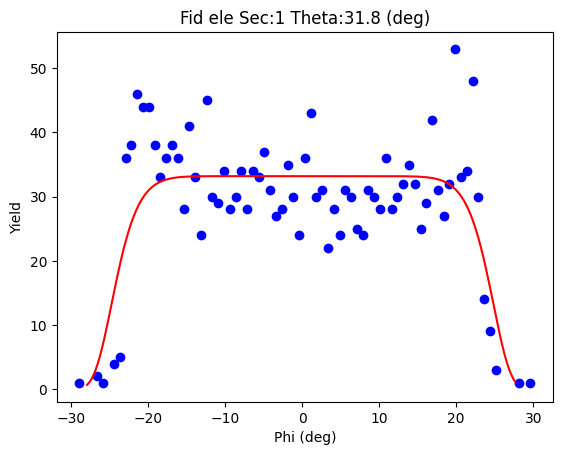

...........Theta: 33.0 ............
Binning| Sec: 0  Ybin: 27
Sum of plot 1761.0
Initial Bounds: [-28.275623258725272, 28.39894512373853]
Sum of initial fit area: 1760.0
max at  47.0
initial max 33.18350944960922
initial guesses: [47.0, 0.06166093250663043, 17.6430130011548, 11.999999999999998]
fit bounds [-28.275623258725272, 28.39894512373853]
(array([28.07301834, -0.12201582, 17.47682892, 12.        ]), array([[ 8.45366682e-01,  4.38301314e-03, -4.82529644e-02,
        -1.07858591e+00],
       [ 4.38301314e-03,  1.62068089e-01,  5.81399845e-03,
        -7.53055740e-02],
       [-4.82529644e-02,  5.81399845e-03,  9.89390854e-02,
        -2.73354575e-01],
       [-1.07858591e+00, -7.53055740e-02, -2.73354575e-01,
         1.15761153e+01]]))
[28.07301834 -0.12201582 17.47682892 12.        ]
[28.07301834 -0.12201582 17.47682892 12.        ]
New Bounds for next fit: [-28.19238384059605, 27.948352193420064]


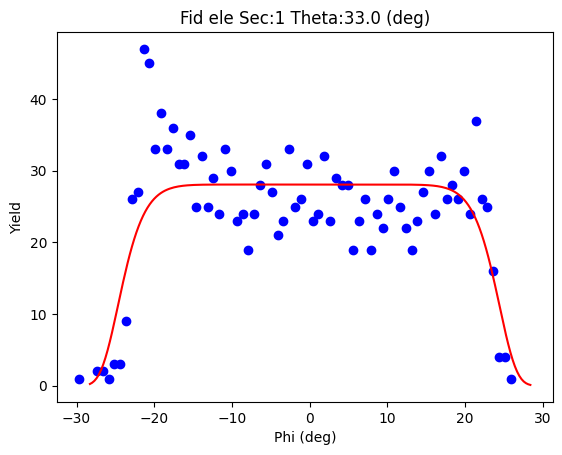

...........Theta: 34.2 ............
Binning| Sec: 0  Ybin: 28
Sum of plot 1452.0
Initial Bounds: [-28.19238384059605, 27.948352193420064]
Sum of initial fit area: 1450.0
max at  37.0
initial max 28.073018341306067
initial guesses: [37.0, -0.12201582358799269, 17.476828920130306, 11.999999999999998]
fit bounds [-28.19238384059605, 27.948352193420064]
(array([23.17716104, -0.05520899, 17.52644414, 12.        ]), array([[ 7.96405017e-01,  4.74411070e-03, -3.84923752e-02,
        -1.38578284e+00],
       [ 4.74411070e-03,  2.64269223e-01,  2.95149862e-02,
        -1.91003055e-01],
       [-3.84923752e-02,  2.95149862e-02,  1.88294963e-01,
        -8.24658994e-01],
       [-1.38578284e+00, -1.91003055e-01, -8.24658994e-01,
         2.00995521e+01]]))
[23.17716104 -0.05520899 17.52644414 12.        ]
[23.17716104 -0.05520899 17.52644414 12.        ]
New Bounds for next fit: [-28.20526637353368, 28.09484840143396]


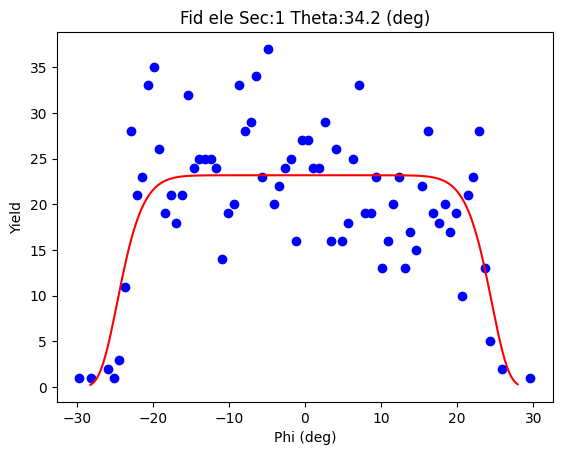

...........Theta: 35.4 ............
Binning| Sec: 0  Ybin: 29
Sum of plot 1292.0
Initial Bounds: [-28.20526637353368, 28.09484840143396]
Sum of initial fit area: 1291.0
max at  33.0
initial max 23.177161041771335
initial guesses: [33.0, -0.055208986049858376, 17.526444140483452, 11.999999999999998]
fit bounds [-28.20526637353368, 28.09484840143396]
(array([20.69917922, -0.24630143, 17.48790996, 12.        ]), array([[ 5.26002297e-01, -2.47557993e-03, -3.78040968e-02,
        -9.21773042e-01],
       [-2.47557993e-03,  2.33213945e-01, -4.22007258e-02,
         2.17135481e-01],
       [-3.78040968e-02, -4.22007258e-02,  1.53878698e-01,
        -5.31126749e-01],
       [-9.21773042e-01,  2.17135481e-01, -5.31126749e-01,
         1.43661267e+01]]))
[20.69917922 -0.24630143 17.48790996 12.        ]
[20.69917922 -0.24630143 17.48790996 12.        ]
New Bounds for next fit: [-28.33446723871969, 27.84186437670825]


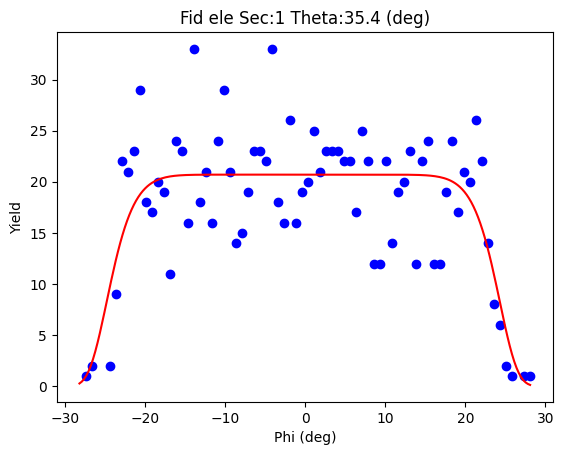

...........Theta: 36.6 ............
Binning| Sec: 0  Ybin: 30
Sum of plot 1138.0
Initial Bounds: [-28.33446723871969, 27.84186437670825]
Sum of initial fit area: 1137.0
max at  27.0
initial max 20.69917921598438
initial guesses: [27.0, -0.24630143100571927, 17.48790996271354, 11.999999999999998]
fit bounds [-28.33446723871969, 27.84186437670825]
(array([1.81334938e+01, 1.63664043e-02, 1.75398866e+01, 1.20000000e+01]), array([[ 5.05813976e-01,  1.18322584e-04, -3.40838076e-02,
        -1.08779848e+00],
       [ 1.18322584e-04,  2.64552297e-01,  7.80289555e-04,
        -5.47007310e-03],
       [-3.40838076e-02,  7.80289555e-04,  1.85183090e-01,
        -7.68736310e-01],
       [-1.08779848e+00, -5.47007310e-03, -7.68736310e-01,
         1.98475341e+01]]))
[1.81334938e+01 1.63664043e-02 1.75398866e+01 1.20000000e+01]
[1.81334938e+01 1.63664043e-02 1.75398866e+01 1.20000000e+01]
New Bounds for next fit: [-28.15528153371825, 28.188014342285573]


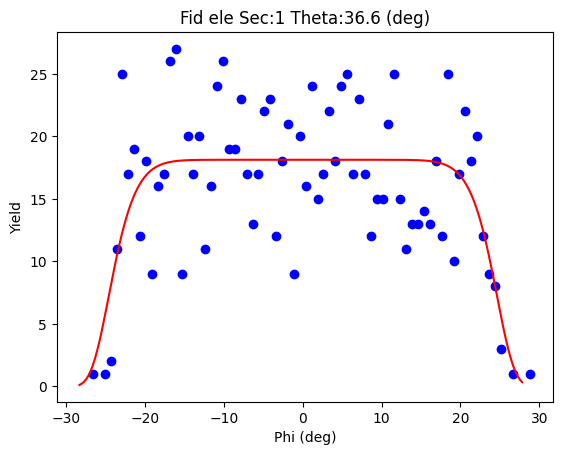

...........Theta: 37.8 ............
Binning| Sec: 0  Ybin: 31
Sum of plot 1002.0
Initial Bounds: [-28.15528153371825, 28.188014342285573]
Sum of initial fit area: 1001.0
max at  27.0
initial max 18.13349380195039
initial guesses: [27.0, 0.016366404283663177, 17.539886584753063, 11.999999999999998]
fit bounds [-28.15528153371825, 28.188014342285573]
(array([16.88339759, -0.79924637, 18.03276575,  5.19287487]), array([[ 0.55643424, -0.04923482, -0.01066245, -0.64920219],
       [-0.04923482,  0.81521497, -0.36754423,  0.48467328],
       [-0.01066245, -0.36754423,  0.91322351, -0.99622929],
       [-0.64920219,  0.48467328, -0.99622929,  3.08070748]]))
[16.88339759 -0.79924637 18.03276575  5.19287487]
[16.88339759 -0.79924637 18.03276575  5.19287487]
New Bounds for next fit: [-35.0207898190113, 33.42229708534089]


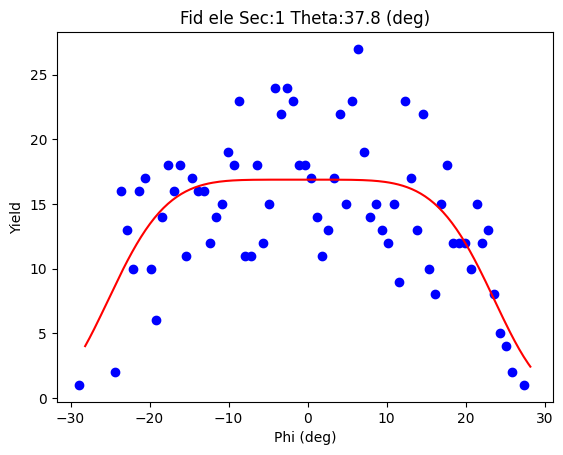

==========Sec  2 ===============
...........Theta: 10.2 ............
Binning| Sec: 1  Ybin: 8
Sum of plot 1616.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 1435.0
max at  75.0
initial max 16.88339758544548
initial guesses: [75.0, -0.7992463668352037, 18.032765746671846, 5.192874871051143]
fit bounds [-10.0, 10.0]
(array([64.06486625, -0.08262328,  7.00481785,  4.30013874]), array([[ 4.60825698, -0.00725012,  0.08752155, -1.41523837],
       [-0.00725012,  0.05958416, -0.00469666,  0.01216462],
       [ 0.08752155, -0.00469666,  0.11937846, -0.2929198 ],
       [-1.41523837,  0.01216462, -0.2929198 ,  1.38904306]]))
[64.06486625 -0.08262328  7.00481785  4.30013874]
[64.06486625 -0.08262328  7.00481785  4.30013874]
New Bounds for next fit: [-14.212879937374913, 14.047633370105524]


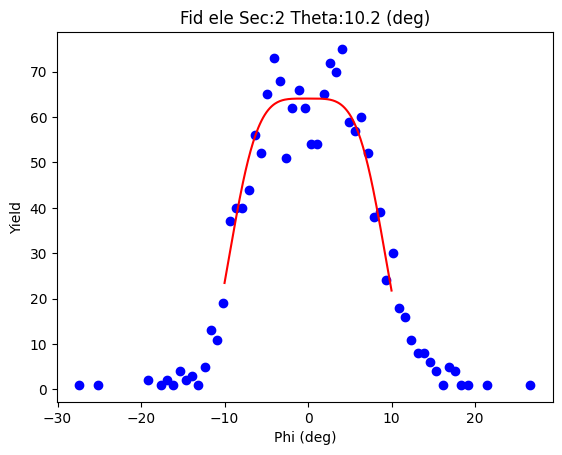

...........Theta: 11.4 ............
Binning| Sec: 1  Ybin: 9
Sum of plot 2071.0
Initial Bounds: [-14.212879937374913, 14.047633370105524]
Sum of initial fit area: 1987.0
max at  84.0
initial max 64.06486625492856
initial guesses: [84.0, -0.0826232836346951, 7.004817850048882, 4.300138743292563]
fit bounds [-14.212879937374913, 14.047633370105524]
(array([66.6408265 , -0.25178569,  8.6400835 ,  5.35344002]), array([[ 3.15363584e+00, -3.69478044e-03, -8.26031571e-02,
        -7.11880030e-01],
       [-3.69478044e-03,  4.00991024e-02, -9.16989081e-04,
         5.56919354e-03],
       [-8.26031571e-02, -9.16989081e-04,  2.79716413e-02,
        -1.99801137e-02],
       [-7.11880030e-01,  5.56919354e-03, -1.99801137e-02,
         6.67042198e-01]]))
[66.6408265  -0.25178569  8.6400835   5.35344002]
[66.6408265  -0.25178569  8.6400835   5.35344002]
New Bounds for next fit: [-16.504445011754513, 16.000873637173804]


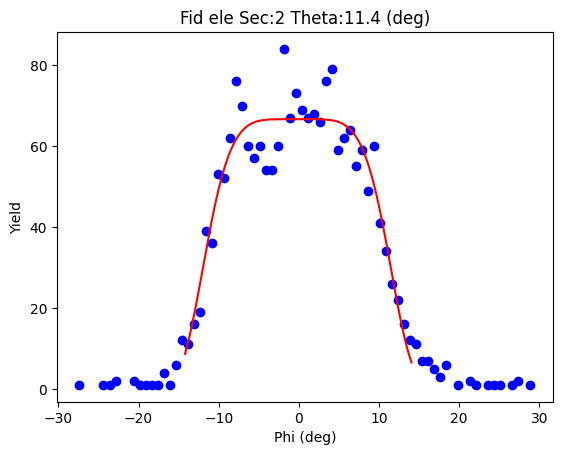

...........Theta: 12.6 ............
Binning| Sec: 1  Ybin: 10
Sum of plot 2406.0
Initial Bounds: [-16.504445011754513, 16.000873637173804]
Sum of initial fit area: 2332.0
max at  85.0
initial max 66.64082650265925
initial guesses: [85.0, -0.2517856872903545, 8.640083503397813, 5.353440017578683]
fit bounds [-16.504445011754513, 16.000873637173804]
(array([66.87952556, -0.15520224,  9.94215963,  6.76563557]), array([[ 3.17456581e+00,  2.78488259e-03, -7.83194873e-02,
        -9.07936243e-01],
       [ 2.78488259e-03,  4.79623097e-02,  7.73855742e-04,
        -6.42385545e-03],
       [-7.83194873e-02,  7.73855742e-04,  3.13072206e-02,
        -3.36334799e-02],
       [-9.07936243e-01, -6.42385545e-03, -3.36334799e-02,
         1.31662608e+00]]))
[66.87952556 -0.15520224  9.94215963  6.76563557]
[66.87952556 -0.15520224  9.94215963  6.76563557]
New Bounds for next fit: [-17.7760691607349, 17.46566467104823]


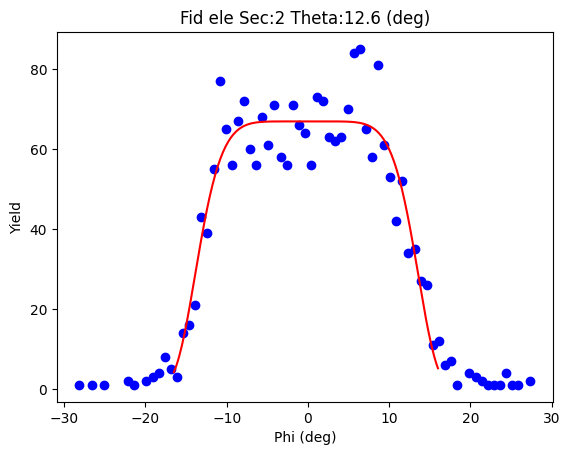

...........Theta: 13.8 ............
Binning| Sec: 1  Ybin: 11
Sum of plot 2781.0
Initial Bounds: [-17.7760691607349, 17.46566467104823]
Sum of initial fit area: 2740.0
max at  84.0
initial max 66.87952556186082
initial guesses: [84.0, -0.15520224484333267, 9.94215962865515, 6.765635570404682]
fit bounds [-17.7760691607349, 17.46566467104823]
(array([70.31293847, -0.39487966, 10.89026022,  8.97742649]), array([[ 2.55764420e+00, -7.74487151e-05, -5.37053529e-02,
        -9.01601089e-01],
       [-7.74487151e-05,  3.55528779e-02, -1.84064441e-05,
         2.71148430e-04],
       [-5.37053529e-02, -1.84064441e-05,  2.15869879e-02,
        -3.30517446e-02],
       [-9.01601089e-01,  2.71148430e-04, -3.30517446e-02,
         2.09628002e+00]]))
[70.31293847 -0.39487966 10.89026022  8.97742649]
[70.31293847 -0.39487966 10.89026022  8.97742649]
New Bounds for next fit: [-18.652010242353192, 17.862250915076714]


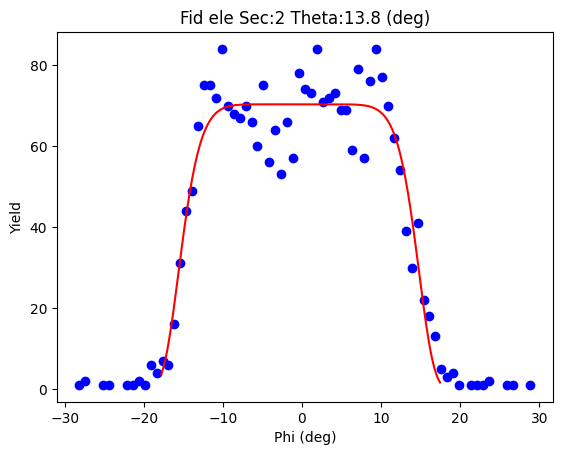

...........Theta: 15.0 ............
Binning| Sec: 1  Ybin: 12
Sum of plot 3191.0
Initial Bounds: [-18.652010242353192, 17.862250915076714]
Sum of initial fit area: 3113.0
max at  96.0
initial max 70.31293847465598
initial guesses: [96.0, -0.39487966363823734, 10.890260223740173, 8.97742649110241]
fit bounds [-18.652010242353192, 17.862250915076714]
(array([71.83496914, -0.17692694, 12.07923644, 10.84720061]), array([[ 3.08560564e+00,  3.91523818e-03, -4.63923245e-02,
        -1.46712358e+00],
       [ 3.91523818e-03,  4.71060503e-02,  1.60913368e-03,
        -2.28549624e-02],
       [-4.63923245e-02,  1.60913368e-03,  3.04249499e-02,
        -1.22563975e-01],
       [-1.46712358e+00, -2.28549624e-02, -1.22563975e-01,
         5.23401220e+00]]))
[71.83496914 -0.17692694 12.07923644 10.84720061]
[71.83496914 -0.17692694 12.07923644 10.84720061]
New Bounds for next fit: [-19.84215061139083, 19.488296732874918]


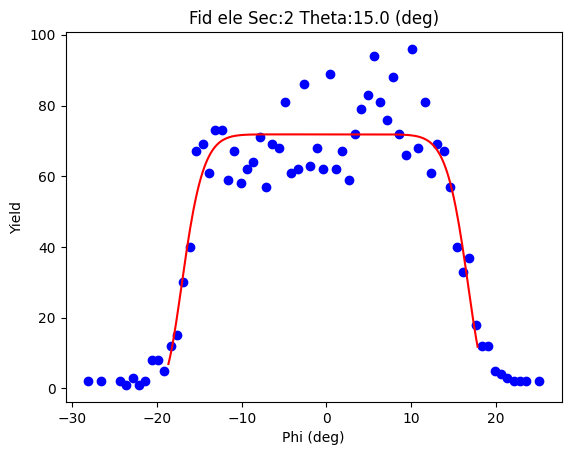

...........Theta: 16.2 ............
Binning| Sec: 1  Ybin: 13
Sum of plot 3414.0
Initial Bounds: [-19.84215061139083, 19.488296732874918]
Sum of initial fit area: 3367.0
max at  97.0
initial max 71.83496913839718
initial guesses: [97.0, -0.17692693925795516, 12.079236442012204, 10.847200610636163]
fit bounds [-19.84215061139083, 19.488296732874918]
(array([73.14035513, -0.18511702, 12.74926408, 12.        ]), array([[ 2.45935164e+00, -1.98623242e-03, -3.85045032e-02,
        -1.22125746e+00],
       [-1.98623242e-03,  3.68203517e-02, -7.37004331e-04,
         1.31063953e-02],
       [-3.85045032e-02, -7.37004331e-04,  2.26465362e-02,
        -8.91401633e-02],
       [-1.22125746e+00,  1.31063953e-02, -8.91401633e-02,
         5.05558439e+00]]))
[73.14035513 -0.18511702 12.74926408 12.        ]
[73.14035513 -0.18511702 12.74926408 12.        ]
New Bounds for next fit: [-20.662317795980993, 20.292083757882335]


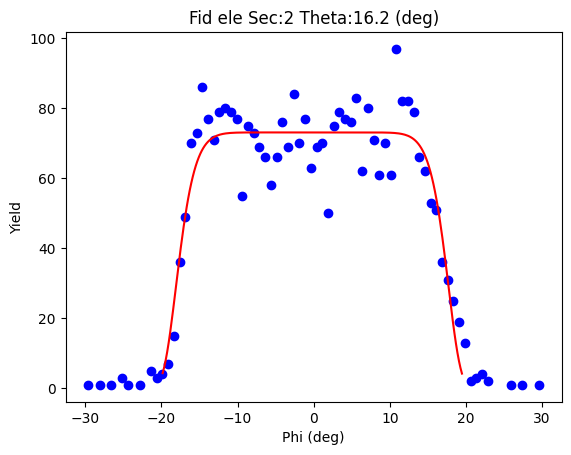

...........Theta: 17.4 ............
Binning| Sec: 1  Ybin: 14
Sum of plot 3784.0
Initial Bounds: [-20.662317795980993, 20.292083757882335]
Sum of initial fit area: 3727.0
max at  91.0
initial max 73.14035513474998
initial guesses: [91.0, -0.1851170190493276, 12.74926408249275, 11.999999999999998]
fit bounds [-20.662317795980993, 20.292083757882335]
(array([75.54049095, -0.11450707, 13.70030579, 12.        ]), array([[ 2.25995635e+00,  4.04380130e-03, -3.12238332e-02,
        -1.16099734e+00],
       [ 4.04380130e-03,  3.81535779e-02,  1.94152441e-03,
        -2.81726685e-02],
       [-3.12238332e-02,  1.94152441e-03,  2.49161990e-02,
        -1.19164100e-01],
       [-1.16099734e+00, -2.81726685e-02, -1.19164100e-01,
         4.88177534e+00]]))
[75.54049095 -0.11450707 13.70030579 12.        ]
[75.54049095 -0.11450707 13.70030579 12.        ]
New Bounds for next fit: [-22.11922127182028, 21.890207136052382]


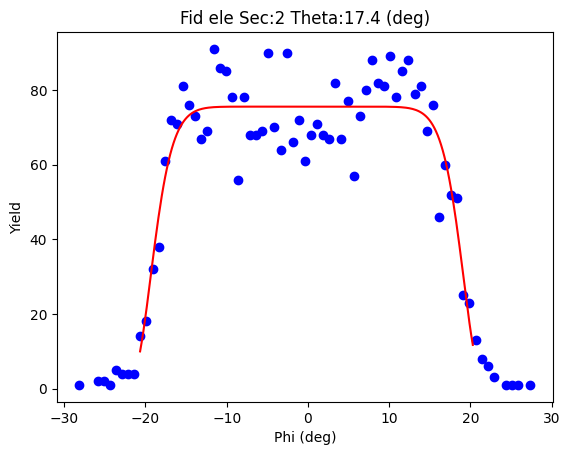

...........Theta: 18.6 ............
Binning| Sec: 1  Ybin: 15
Sum of plot 3757.0
Initial Bounds: [-22.11922127182028, 21.890207136052382]
Sum of initial fit area: 3707.0
max at  94.0
initial max 75.54049094629598
initial guesses: [94.0, -0.11450706788394953, 13.700305793836828, 11.999999999997762]
fit bounds [-22.11922127182028, 21.890207136052382]
(array([73.24583641, -0.13908138, 14.02463771, 12.        ]), array([[ 2.77136195e+00, -9.57823216e-04, -5.14010645e-02,
        -1.31963564e+00],
       [-9.57823216e-04,  4.92561110e-02, -3.35549871e-04,
         5.96368665e-03],
       [-5.14010645e-02, -3.35549871e-04,  2.94829877e-02,
        -8.72520025e-02],
       [-1.31963564e+00,  5.96368665e-03, -8.72520025e-02,
         5.31495827e+00]]))
[73.24583641 -0.13908138 14.02463771 12.        ]
[73.24583641 -0.13908138 14.02463771 12.        ]
New Bounds for next fit: [-22.66472053689287, 22.386557777967315]


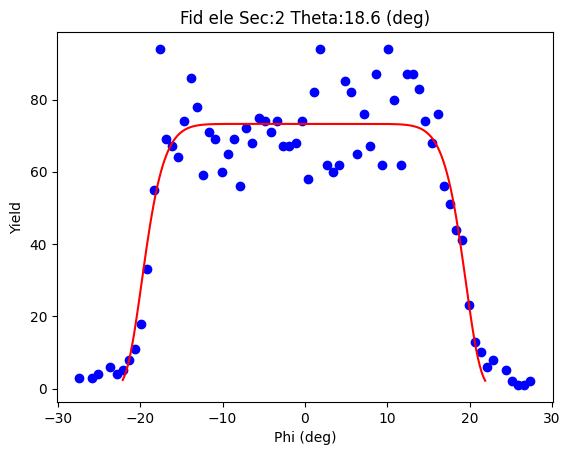

...........Theta: 19.8 ............
Binning| Sec: 1  Ybin: 16
Sum of plot 3826.0
Initial Bounds: [-22.66472053689287, 22.386557777967315]
Sum of initial fit area: 3782.0
max at  94.0
initial max 73.24583641432795
initial guesses: [94.0, -0.1390813794627769, 14.024637711641756, 11.999999999999984]
fit bounds [-22.66472053689287, 22.386557777967315]
(array([72.49893007, -0.27331482, 14.46553265, 12.        ]), array([[ 2.37694221e+00, -1.45863105e-03, -4.60810552e-02,
        -1.14066191e+00],
       [-1.45863105e-03,  4.58991814e-02, -5.29698797e-04,
         9.15617580e-03],
       [-4.60810552e-02, -5.29698797e-04,  2.74458115e-02,
        -7.81611805e-02],
       [-1.14066191e+00,  9.15617580e-03, -7.81611805e-02,
         4.63764602e+00]]))
[72.49893007 -0.27331482 14.46553265 12.        ]
[72.49893007 -0.27331482 14.46553265 12.        ]
New Bounds for next fit: [-23.507096348533285, 22.960466707878066]


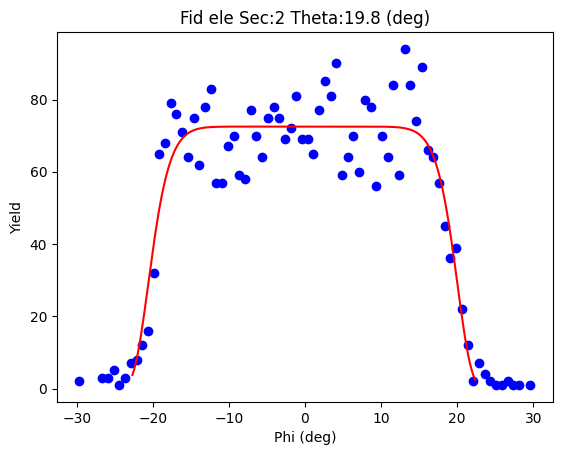

...........Theta: 21.0 ............
Binning| Sec: 1  Ybin: 17
Sum of plot 3804.0
Initial Bounds: [-23.507096348533285, 22.960466707878066]
Sum of initial fit area: 3778.0
max at  96.0
initial max 72.4989300737974
initial guesses: [96.0, -0.273314820327611, 14.465532646030988, 11.999999999999988]
fit bounds [-23.507096348533285, 22.960466707878066]
(array([69.50236706, -0.1106751 , 15.09361617, 12.        ]), array([[ 2.74479495e+00, -1.06263978e-03, -5.60518276e-02,
        -1.40109941e+00],
       [-1.06263978e-03,  6.31075721e-02, -4.55547119e-04,
         7.17073708e-03],
       [-5.60518276e-02, -4.55547119e-04,  3.81809114e-02,
        -1.13881492e-01],
       [-1.40109941e+00,  7.17073708e-03, -1.13881492e-01,
         6.00966256e+00]]))
[69.50236706 -0.1106751  15.09361617 12.        ]
[69.50236706 -0.1106751  15.09361617 12.        ]
New Bounds for next fit: [-24.353251511214108, 24.131901319988163]


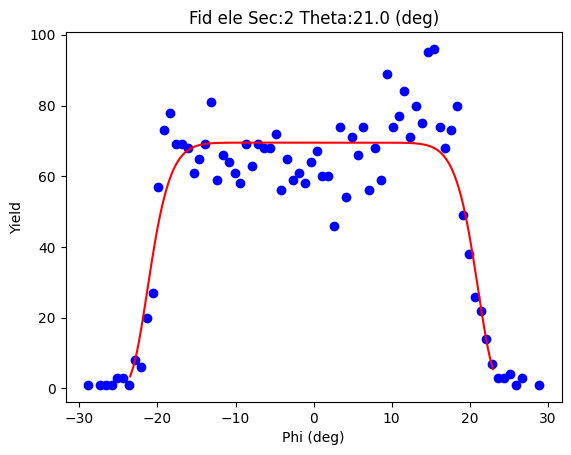

...........Theta: 22.2 ............
Binning| Sec: 1  Ybin: 18
Sum of plot 3562.0
Initial Bounds: [-24.353251511214108, 24.131901319988163]
Sum of initial fit area: 3547.0
max at  87.0
initial max 69.50236706351666
initial guesses: [87.0, -0.11067509561297179, 15.093616169974462, 11.999999999999998]
fit bounds [-24.353251511214108, 24.131901319988163]
(array([64.15704477,  0.12600417, 15.36198158, 12.        ]), array([[ 2.01562278e+00,  5.07042022e-04, -4.78538964e-02,
        -1.07990062e+00],
       [ 5.07042022e-04,  5.57871346e-02,  2.07691871e-04,
        -3.51797594e-03],
       [-4.78538964e-02,  2.07691871e-04,  3.31235422e-02,
        -8.33154391e-02],
       [-1.07990062e+00, -3.51797594e-03, -8.33154391e-02,
         4.92324106e+00]]))
[64.15704477  0.12600417 15.36198158 12.        ]
[64.15704477  0.12600417 15.36198158 12.        ]
New Bounds for next fit: [-24.54760671332313, 24.799615060876807]


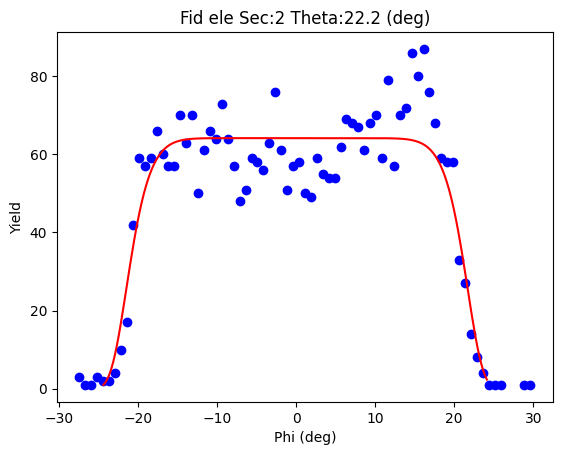

...........Theta: 23.4 ............
Binning| Sec: 1  Ybin: 19
Sum of plot 3794.0
Initial Bounds: [-24.54760671332313, 24.799615060876807]
Sum of initial fit area: 3772.0
max at  85.0
initial max 64.15704477086472
initial guesses: [85.0, 0.12600417377683676, 15.36198157624557, 11.999999999999998]
fit bounds [-24.54760671332313, 24.799615060876807]
(array([ 6.68671475e+01, -2.82512771e-02,  1.56749098e+01,  1.20000000e+01]), array([[ 2.19165686e+00, -6.41967674e-05, -5.20936746e-02,
        -1.10969684e+00],
       [-6.41967674e-05,  5.79327097e-02, -2.32637465e-05,
         4.12534228e-04],
       [-5.20936746e-02, -2.32637465e-05,  3.41408394e-02,
        -7.80381359e-02],
       [-1.10969684e+00,  4.12534228e-04, -7.80381359e-02,
         4.81329631e+00]]))
[ 6.68671475e+01 -2.82512771e-02  1.56749098e+01  1.20000000e+01]
[ 6.68671475e+01 -2.82512771e-02  1.56749098e+01  1.20000000e+01]
New Bounds for next fit: [-25.20447102903473, 25.147968474908183]


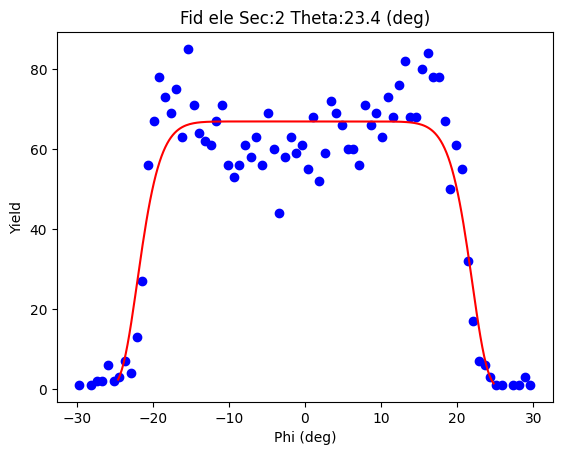

...........Theta: 24.6 ............
Binning| Sec: 1  Ybin: 20
Sum of plot 3630.0
Initial Bounds: [-25.20447102903473, 25.147968474908183]
Sum of initial fit area: 3616.0
max at  85.0
initial max 66.86714750540226
initial guesses: [85.0, -0.028251277063274145, 15.674909755162838, 11.999999999999998]
fit bounds [-25.20447102903473, 25.147968474908183]
(array([62.69524704,  0.07297186, 16.02370756, 12.        ]), array([[ 2.13804509e+00,  1.02235673e-04, -5.58839382e-02,
        -1.14732348e+00],
       [ 1.02235673e-04,  6.71089866e-02,  3.79393038e-05,
        -6.85962426e-04],
       [-5.58839382e-02,  3.79393038e-05,  3.94408963e-02,
        -8.55436930e-02],
       [-1.14732348e+00, -6.85962426e-04, -8.55436930e-02,
         5.29060189e+00]]))
[62.69524704  0.07297186 16.02370756 12.        ]
[62.69524704  0.07297186 16.02370756 12.        ]
New Bounds for next fit: [-25.663468666154362, 25.809412384671074]


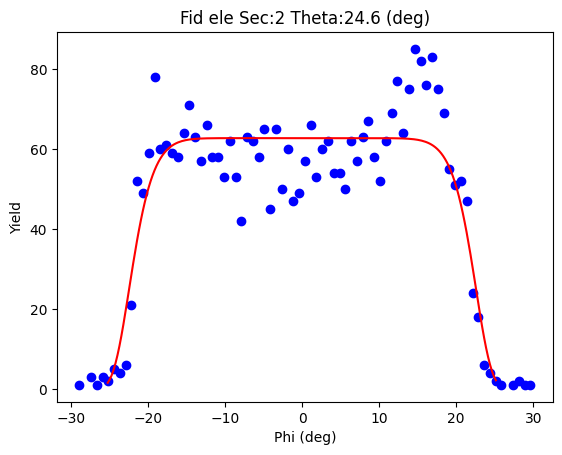

...........Theta: 25.8 ............
Binning| Sec: 1  Ybin: 21
Sum of plot 3191.0
Initial Bounds: [-25.663468666154362, 25.809412384671074]
Sum of initial fit area: 3179.0
max at  67.0
initial max 62.69524703979304
initial guesses: [67.0, 0.0729718592583563, 16.023707555355685, 11.999999999999998]
fit bounds [-25.663468666154362, 25.809412384671074]
(array([53.43314786, -0.0749325 , 16.57918219, 12.        ]), array([[ 1.66507129e+00, -6.02306158e-04, -4.81952730e-02,
        -1.11036305e+00],
       [-6.02306158e-04,  7.82656202e-02, -3.76995580e-04,
         5.32965719e-03],
       [-4.81952730e-02, -3.76995580e-04,  4.74951100e-02,
        -1.31607897e-01],
       [-1.11036305e+00,  5.32965719e-03, -1.31607897e-01,
         6.21197095e+00]]))
[53.43314786 -0.0749325  16.57918219 12.        ]
[53.43314786 -0.0749325  16.57918219 12.        ]
New Bounds for next fit: [-26.703547323608635, 26.553682315046263]


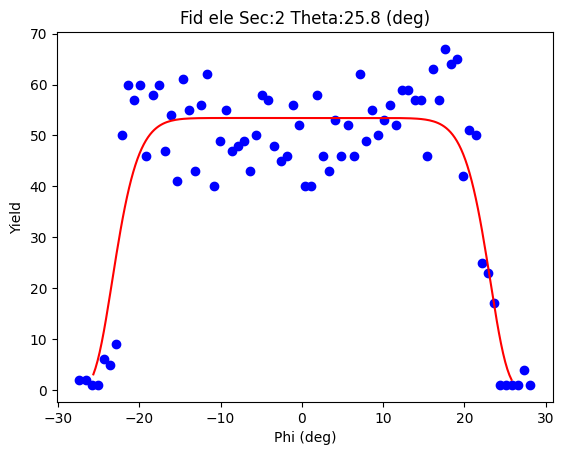

...........Theta: 27.0 ............
Binning| Sec: 1  Ybin: 22
Sum of plot 2910.0
Initial Bounds: [-26.703547323608635, 26.553682315046263]
Sum of initial fit area: 2893.0
max at  60.0
initial max 53.43314785560932
initial guesses: [60.0, -0.07493250428118658, 16.57918219296066, 11.999999999999998]
fit bounds [-26.703547323608635, 26.553682315046263]
(array([ 4.80776117e+01, -2.37994848e-02,  1.67017454e+01,  1.20000000e+01]), array([[ 1.18662146e+00,  3.54349094e-04, -4.20185172e-02,
        -8.32228472e-01],
       [ 3.54349094e-04,  6.88548162e-02,  1.83142344e-04,
        -3.12541625e-03],
       [-4.20185172e-02,  1.83142344e-04,  4.05118526e-02,
        -8.53533920e-02],
       [-8.32228472e-01, -3.12541625e-03, -8.53533920e-02,
         5.01108793e+00]]))
[ 4.80776117e+01 -2.37994848e-02  1.67017454e+01  1.20000000e+01]
[ 4.80776117e+01 -2.37994848e-02  1.67017454e+01  1.20000000e+01]
New Bounds for next fit: [-26.849268984249196, 26.8016700146887]


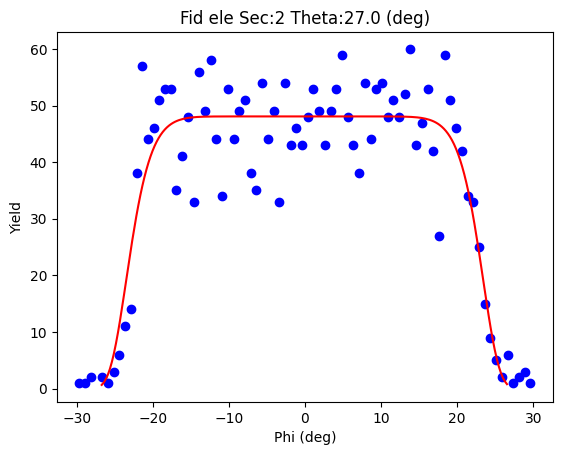

...........Theta: 28.2 ............
Binning| Sec: 1  Ybin: 23
Sum of plot 3001.0
Initial Bounds: [-26.849268984249196, 26.8016700146887]
Sum of initial fit area: 2989.0
max at  67.0
initial max 48.07761169958239
initial guesses: [67.0, -0.023799484780248795, 16.70174544417544, 11.999999999999998]
fit bounds [-26.849268984249196, 26.8016700146887]
(array([ 4.93823797e+01, -3.26136226e-02,  1.68171307e+01,  1.20000000e+01]), array([[ 1.39303120e+00, -3.60896800e-03, -4.45330671e-02,
        -9.97730334e-01],
       [-3.60896800e-03,  7.94574554e-02, -2.48627409e-03,
         3.45572597e-02],
       [-4.45330671e-02, -2.48627409e-03,  4.81053247e-02,
        -1.30491994e-01],
       [-9.97730334e-01,  3.45572597e-02, -1.30491994e-01,
         6.03873132e+00]]))
[ 4.93823797e+01 -3.26136226e-02  1.68171307e+01  1.20000000e+01]
[ 4.93823797e+01 -3.26136226e-02  1.68171307e+01  1.20000000e+01]
New Bounds for next fit: [-27.0434089126971, 26.978181667546846]


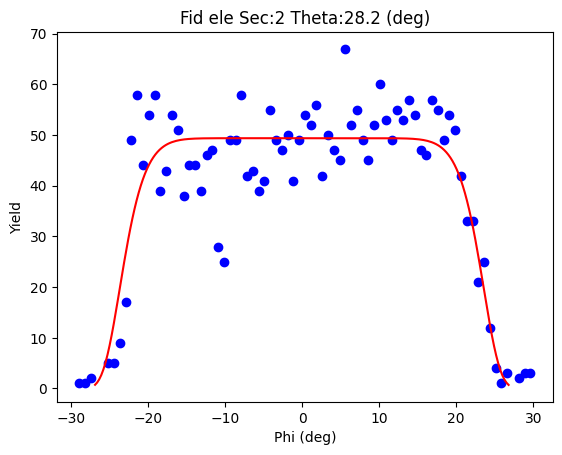

...........Theta: 29.4 ............
Binning| Sec: 1  Ybin: 24
Sum of plot 2980.0
Initial Bounds: [-27.0434089126971, 26.978181667546846]
Sum of initial fit area: 2973.0
max at  63.0
initial max 49.382379736420994
initial guesses: [63.0, -0.03261362257512791, 16.817130719343822, 11.99999999999788]
fit bounds [-27.0434089126971, 26.978181667546846]
(array([ 4.92811415e+01, -1.67921412e-02,  1.67540843e+01,  1.20000000e+01]), array([[ 1.39112883e+00,  5.13759075e-04, -4.80295799e-02,
        -9.54338336e-01],
       [ 5.13759075e-04,  7.73537087e-02,  2.66866760e-04,
        -4.46077825e-03],
       [-4.80295799e-02,  2.66866760e-04,  4.55671055e-02,
        -9.69900506e-02],
       [-9.54338336e-01, -4.46077825e-03, -9.69900506e-02,
         5.61401144e+00]]))
[ 4.92811415e+01 -1.67921412e-02  1.67540843e+01  1.20000000e+01]
[ 4.92811415e+01 -1.67921412e-02  1.67540843e+01  1.20000000e+01]
New Bounds for next fit: [-26.92632563454602, 26.892741352144586]


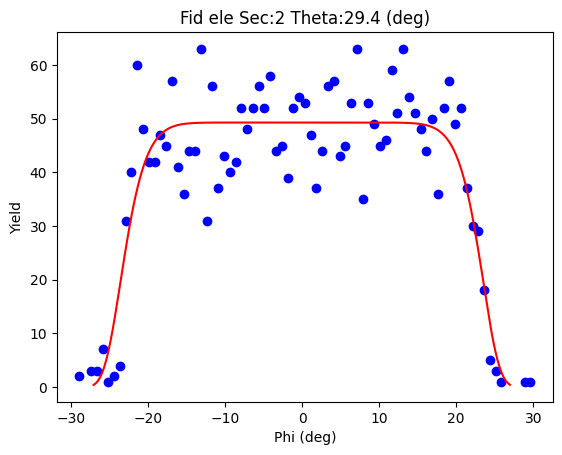

...........Theta: 30.6 ............
Binning| Sec: 1  Ybin: 25
Sum of plot 2911.0
Initial Bounds: [-26.92632563454602, 26.892741352144586]
Sum of initial fit area: 2903.0
max at  64.0
initial max 49.28114154350062
initial guesses: [64.0, -0.016792141200718223, 16.754084338999682, 11.999999999999998]
fit bounds [-26.92632563454602, 26.892741352144586]
(array([48.11086999,  0.11821252, 16.78349625, 12.        ]), array([[ 1.61798615e+00,  7.05559552e-05, -5.80864470e-02,
        -1.12597406e+00],
       [ 7.05559552e-05,  9.45546803e-02,  3.31002855e-05,
        -6.01492801e-04],
       [-5.80864470e-02,  3.31002855e-05,  5.54646480e-02,
        -1.12272284e-01],
       [-1.12597406e+00, -6.01492801e-04, -1.12272284e-01,
         6.75037357e+00]]))
[48.11086999  0.11821252 16.78349625 12.        ]
[48.11086999  0.11821252 16.78349625 12.        ]
New Bounds for next fit: [-26.838560837773127, 27.07498588229868]


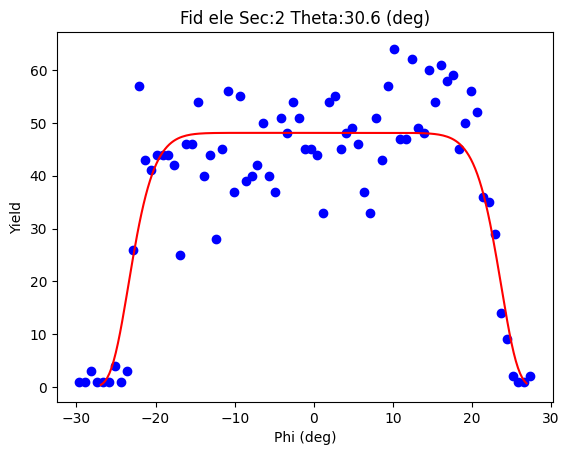

...........Theta: 31.8 ............
Binning| Sec: 1  Ybin: 26
Sum of plot 2481.0
Initial Bounds: [-26.838560837773127, 27.07498588229868]
Sum of initial fit area: 2479.0
max at  57.0
initial max 48.11086999481803
initial guesses: [57.0, 0.1182125222627774, 16.78349624652655, 11.999999999999998]
fit bounds [-26.838560837773127, 27.07498588229868]
(array([40.32866476, -0.15660081, 17.32514351, 12.        ]), array([[ 1.28847671e+00, -6.15032409e-03, -2.29163610e-02,
        -1.41394475e+00],
       [-6.15032409e-03,  1.55761343e-01, -2.93655784e-02,
         1.66919250e-01],
       [-2.29163610e-02, -2.93655784e-02,  1.23665747e-01,
        -6.35845368e-01],
       [-1.41394475e+00,  1.66919250e-01, -6.35845368e-01,
         1.26062694e+01]]))
[40.32866476 -0.15660081 17.32514351 12.        ]
[40.32866476 -0.15660081 17.32514351 12.        ]
New Bounds for next fit: [-27.98333965519944, 27.67013802928781]


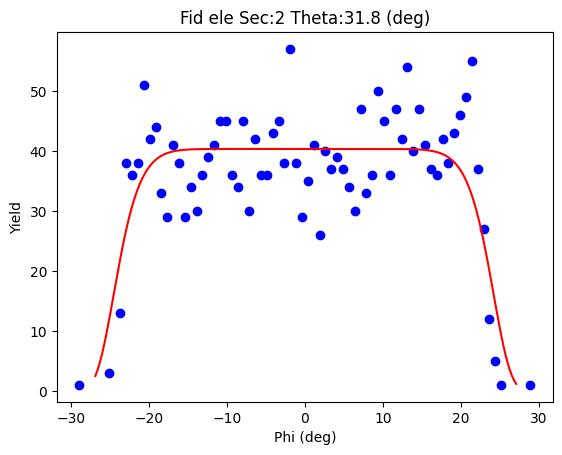

...........Theta: 33.0 ............
Binning| Sec: 1  Ybin: 27
Sum of plot 1973.0
Initial Bounds: [-27.98333965519944, 27.67013802928781]
Sum of initial fit area: 1971.0
max at  44.0
initial max 40.32866475930354
initial guesses: [44.0, -0.15660081295581504, 17.325143505648718, 11.999999999999998]
fit bounds [-27.98333965519944, 27.67013802928781]
(array([32.212264  ,  0.11273588, 17.05898969, 12.        ]), array([[ 8.06258943e-01,  7.96631429e-04, -3.53278569e-02,
        -9.31791452e-01],
       [ 7.96631429e-04,  1.15715554e-01,  1.54042762e-03,
        -1.50661157e-02],
       [-3.53278569e-02,  1.54042762e-03,  7.42404505e-02,
        -2.58208845e-01],
       [-9.31791452e-01, -1.50661157e-02, -2.58208845e-01,
         9.04241726e+00]]))
[32.212264    0.11273588 17.05898969 12.        ]
[32.212264    0.11273588 17.05898969 12.        ]
New Bounds for next fit: [-27.286520622475916, 27.511992389804288]


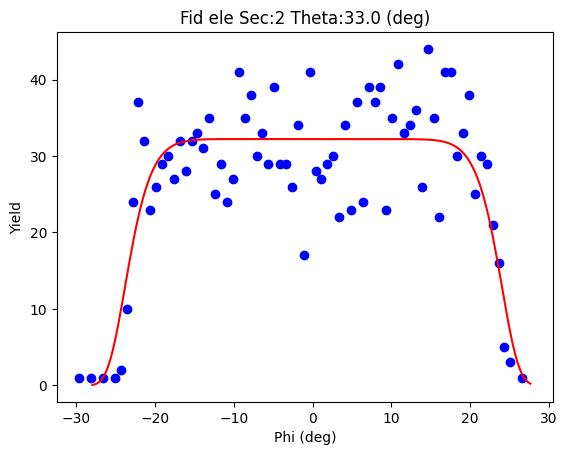

...........Theta: 34.2 ............
Binning| Sec: 1  Ybin: 28
Sum of plot 1528.0
Initial Bounds: [-27.286520622475916, 27.511992389804288]
Sum of initial fit area: 1527.0
max at  38.0
initial max 32.21226400271445
initial guesses: [38.0, 0.11273588366418598, 17.058989686435087, 11.999999999999998]
fit bounds [-27.286520622475916, 27.511992389804288]
(array([24.61036114,  0.14831705, 17.38528684, 12.        ]), array([[ 5.56645695e-01, -1.73220088e-03, -2.40578159e-02,
        -9.17784499e-01],
       [-1.73220088e-03,  1.62749844e-01,  8.27210450e-03,
        -1.17581836e-02],
       [-2.40578159e-02,  8.27210450e-03,  1.19392441e-01,
        -5.42092922e-01],
       [-9.17784499e-01, -1.17581836e-02, -5.42092922e-01,
         1.26975773e+01]]))
[24.61036114  0.14831705 17.38528684 12.        ]
[24.61036114  0.14831705 17.38528684 12.        ]
New Bounds for next fit: [-27.775020868914382, 28.071654976837216]


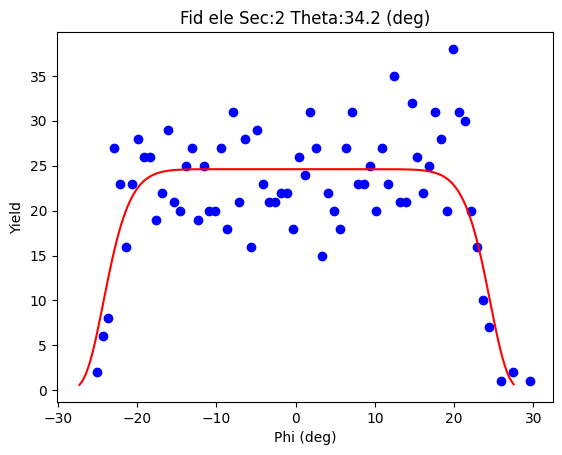

...........Theta: 35.4 ............
Binning| Sec: 1  Ybin: 29
Sum of plot 1050.0
Initial Bounds: [-27.775020868914382, 28.071654976837216]
Sum of initial fit area: 1049.0
max at  28.0
initial max 24.610361144586502
initial guesses: [28.0, 0.14831705396141687, 17.38528684274453, 11.999999999999998]
fit bounds [-27.775020868914382, 28.071654976837216]
(array([16.63041647, -0.29969875, 17.61852453, 12.        ]), array([[ 3.32939010e-01, -1.80693171e-03, -3.24587931e-02,
        -7.07594183e-01],
       [-1.80693171e-03,  1.99598864e-01, -1.69835160e-02,
         1.08665909e-01],
       [-3.24587931e-02, -1.69835160e-02,  1.24201142e-01,
        -3.56752573e-01],
       [-7.07594183e-01,  1.08665909e-01, -3.56752573e-01,
         1.30079057e+01]]))
[16.63041647 -0.29969875 17.61852453 12.        ]
[16.63041647 -0.29969875 17.61852453 12.        ]
New Bounds for next fit: [-28.59765084214213, 27.998253339270498]


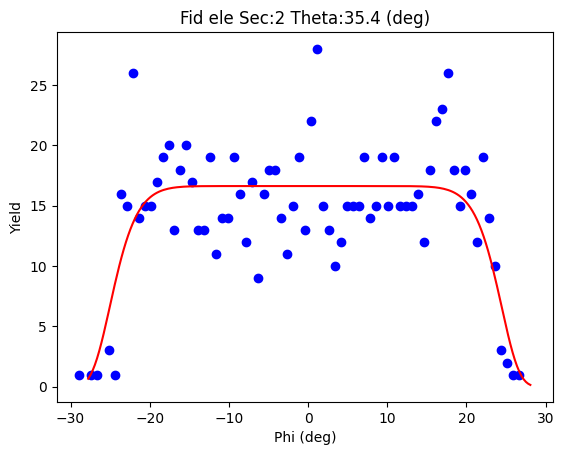

==========Sec  3 ===============
...........Theta: 9.0 ............
Binning| Sec: 2  Ybin: 7
Sum of plot 1395.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 1325.0
max at  78.0
initial max 16.630416468065935
initial guesses: [78.0, -0.2996987514358145, 17.61852453019715, 11.999999999999998]
fit bounds [-10.0, 10.0]
(array([72.84563597,  0.85244634,  5.63324448,  2.8793417 ]), array([[ 8.25542136e+00,  2.93355094e-02, -2.16859971e-01,
        -8.69969547e-01],
       [ 2.93355094e-02,  4.21889732e-02,  4.81946735e-03,
        -1.35567831e-02],
       [-2.16859971e-01,  4.81946735e-03,  3.98101570e-02,
        -6.37367508e-03],
       [-8.69969547e-01, -1.35567831e-02, -6.37367508e-03,
         2.39656209e-01]]))
[72.84563597  0.85244634  5.63324448  2.8793417 ]
[72.84563597  0.85244634  5.63324448  2.8793417 ]
New Bounds for next fit: [-12.687591847592703, 14.392484518619789]


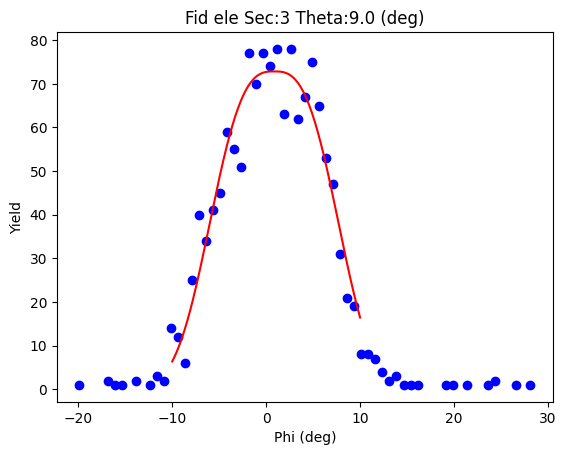

...........Theta: 10.2 ............
Binning| Sec: 2  Ybin: 8
Sum of plot 2283.0
Initial Bounds: [-12.687591847592703, 14.392484518619789]
Sum of initial fit area: 2237.0
max at  104.0
initial max 72.84563596573177
initial guesses: [104.0, 0.8524463355135432, 5.633244475309367, 2.879341704231721]
fit bounds [-12.687591847592703, 14.392484518619789]
(array([88.18771231, -0.46912395,  7.3359979 ,  4.84551769]), array([[ 5.52761821e+00, -6.70488228e-03, -1.15301160e-01,
        -7.77946984e-01],
       [-6.70488228e-03,  2.95329315e-02, -7.98589991e-04,
         5.78131374e-03],
       [-1.15301160e-01, -7.98589991e-04,  2.03344658e-02,
        -3.23454230e-03],
       [-7.77946984e-01,  5.78131374e-03, -3.23454230e-03,
         4.31937890e-01]]))
[88.18771231 -0.46912395  7.3359979   4.84551769]
[88.18771231 -0.46912395  7.3359979   4.84551769]
New Bounds for next fit: [-14.687578195911117, 13.749330295606628]


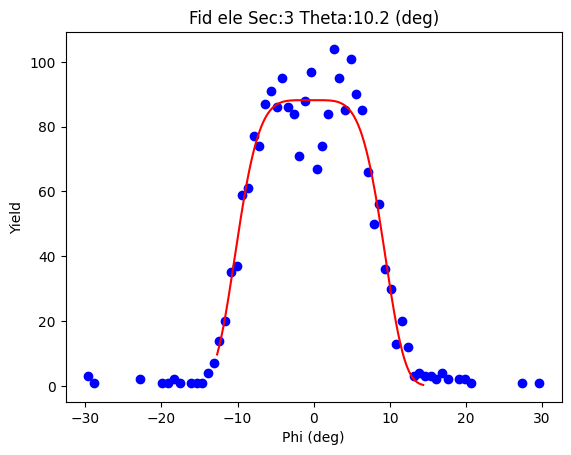

...........Theta: 11.4 ............
Binning| Sec: 2  Ybin: 9
Sum of plot 2920.0
Initial Bounds: [-14.687578195911117, 13.749330295606628]
Sum of initial fit area: 2844.0
max at  109.0
initial max 88.18771231366415
initial guesses: [109.0, -0.4691239501522451, 7.335997901879194, 4.845517694317496]
fit bounds [-14.687578195911117, 13.749330295606628]
(array([93.03320501, -0.73833013,  8.71977919,  6.65941761]), array([[ 3.74663983e+00,  1.11560811e-04, -6.06622460e-02,
        -7.46813552e-01],
       [ 1.11560811e-04,  2.25191155e-02,  1.82737702e-05,
        -1.75496872e-04],
       [-6.06622460e-02,  1.82737702e-05,  1.46102584e-02,
        -1.51510851e-02],
       [-7.46813552e-01, -1.75496872e-04, -1.51510851e-02,
         7.47262046e-01]]))
[93.03320501 -0.73833013  8.71977919  6.65941761]
[93.03320501 -0.73833013  8.71977919  6.65941761]
New Bounds for next fit: [-16.24846710596385, 14.77180684926492]


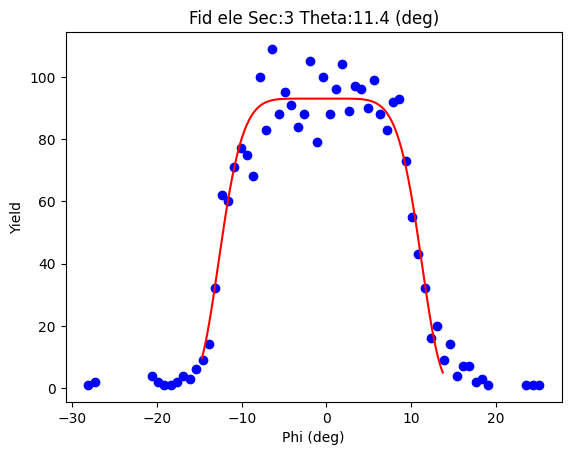

...........Theta: 12.6 ............
Binning| Sec: 2  Ybin: 10
Sum of plot 3519.0
Initial Bounds: [-16.24846710596385, 14.77180684926492]
Sum of initial fit area: 3449.0
max at  118.0
initial max 93.03320500941666
initial guesses: [118.0, -0.7383301283494648, 8.719779185452447, 6.6594176149593425]
fit bounds [-16.24846710596385, 14.77180684926492]
(array([97.54761629, -0.82788152,  9.90042129,  8.98112705]), array([[ 3.94833851e+00, -6.21755517e-04, -5.21306617e-02,
        -1.03157481e+00],
       [-6.21755517e-04,  2.37128339e-02, -1.10218189e-04,
         1.64147926e-03],
       [-5.21306617e-02, -1.10218189e-04,  1.46001717e-02,
        -2.92590968e-02],
       [-1.03157481e+00,  1.64147926e-03, -2.92590968e-02,
         1.75858042e+00]]))
[97.54761629 -0.82788152  9.90042129  8.98112705]
[97.54761629 -0.82788152  9.90042129  8.98112705]
New Bounds for next fit: [-17.424419294833367, 15.768656259957135]


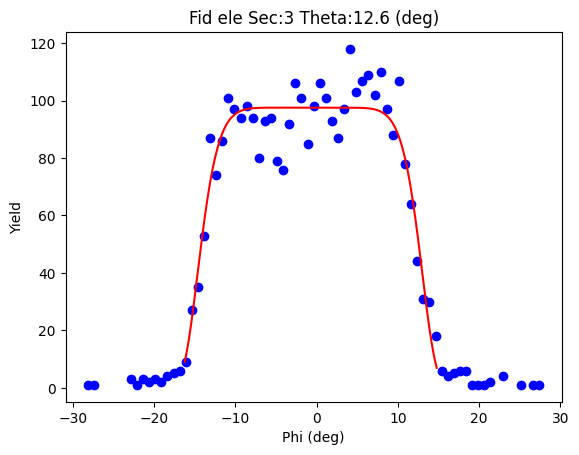

...........Theta: 13.8 ............
Binning| Sec: 2  Ybin: 11
Sum of plot 4043.0
Initial Bounds: [-17.424419294833367, 15.768656259957135]
Sum of initial fit area: 3948.0
max at  116.0
initial max 97.54761629199746
initial guesses: [116.0, -0.8278815174381163, 9.900421292484054, 8.981127053931504]
fit bounds [-17.424419294833367, 15.768656259957135]
(array([99.81344599, -0.94277371, 10.98270157, 12.        ]), array([[ 3.27078149e+00, -3.53924826e-03, -2.67326683e-02,
        -1.28446397e+00],
       [-3.53924826e-03,  2.03554362e-02, -1.02510533e-03,
         1.86278662e-02],
       [-2.67326683e-02, -1.02510533e-03,  1.33990378e-02,
        -8.21862647e-02],
       [-1.28446397e+00,  1.86278662e-02, -8.21862647e-02,
         4.10923901e+00]]))
[99.81344599 -0.94277371 10.98270157 12.        ]
[99.81344599 -0.94277371 10.98270157 12.        ]
New Bounds for next fit: [-18.5826142309435, 16.697066811233192]


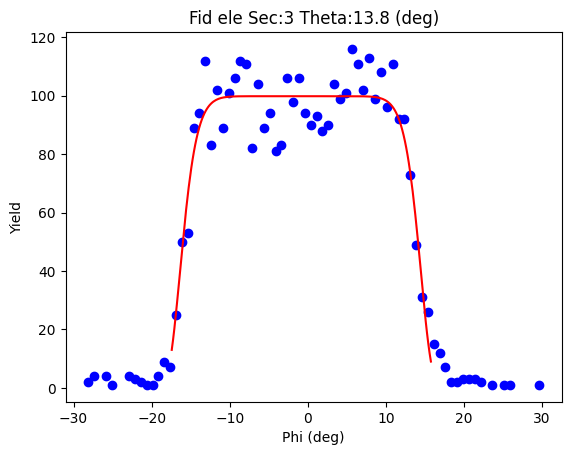

...........Theta: 15.0 ............
Binning| Sec: 2  Ybin: 12
Sum of plot 4547.0
Initial Bounds: [-18.5826142309435, 16.697066811233192]
Sum of initial fit area: 4439.0
max at  122.0
initial max 99.81344599200976
initial guesses: [122.0, -0.9427737098551544, 10.982701572656469, 11.999999999999078]
fit bounds [-18.5826142309435, 16.697066811233192]
(array([104.04515607,  -0.95183721,  11.87819389,  12.        ]), array([[ 3.10269019e+00,  3.88151942e-03, -2.04927054e-02,
        -1.25140168e+00],
       [ 3.88151942e-03,  2.17140668e-02,  1.38771397e-03,
        -2.10961194e-02],
       [-2.04927054e-02,  1.38771397e-03,  1.55261411e-02,
        -1.07258570e-01],
       [-1.25140168e+00, -2.10961194e-02, -1.07258570e-01,
         4.03920957e+00]]))
[104.04515607  -0.95183721  11.87819389  12.        ]
[104.04515607  -0.95183721  11.87819389  12.        ]
New Bounds for next fit: [-20.02997061853987, 18.12629620446816]


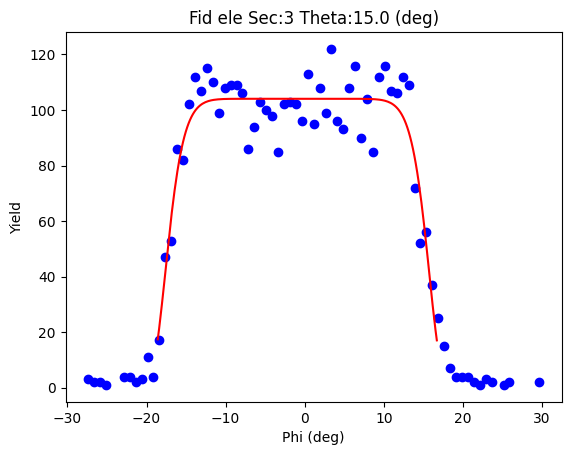

...........Theta: 16.2 ............
Binning| Sec: 2  Ybin: 13
Sum of plot 5081.0
Initial Bounds: [-20.02997061853987, 18.12629620446816]
Sum of initial fit area: 4999.0
max at  132.0
initial max 104.04515606759962
initial guesses: [132.0, -0.9518372070358558, 11.87819388567513, 11.999999999999487]
fit bounds [-20.02997061853987, 18.12629620446816]
(array([109.85827083,  -1.13541195,  12.63296897,  12.        ]), array([[ 3.57338919e+00, -1.50990360e-04, -3.40054370e-02,
        -1.22704558e+00],
       [-1.50990360e-04,  2.35944349e-02, -4.10483446e-05,
         6.91280163e-04],
       [-3.40054370e-02, -4.10483446e-05,  1.49663844e-02,
        -6.90113949e-02],
       [-1.22704558e+00,  6.91280163e-04, -6.90113949e-02,
         3.46414539e+00]]))
[109.85827083  -1.13541195  12.63296897  12.        ]
[109.85827083  -1.13541195  12.63296897  12.        ]
New Bounds for next fit: [-21.42582561288356, 19.155001703786656]


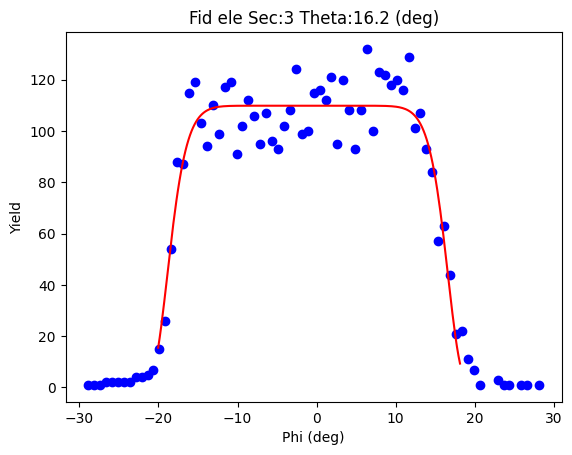

...........Theta: 17.4 ............
Binning| Sec: 2  Ybin: 14
Sum of plot 5627.0
Initial Bounds: [-21.42582561288356, 19.155001703786656]
Sum of initial fit area: 5550.0
max at  137.0
initial max 109.85827083268508
initial guesses: [137.0, -1.1354119545484536, 12.632968973208179, 11.999999999999998]
fit bounds [-21.42582561288356, 19.155001703786656]
(array([114.78907775,  -0.74333141,  13.43048286,  12.        ]), array([[ 4.95780791e+00,  4.64376179e-03, -5.23378139e-02,
        -1.56140333e+00],
       [ 4.64376179e-03,  3.36107663e-02,  1.16739150e-03,
        -1.95842582e-02],
       [-5.23378139e-02,  1.16739150e-03,  2.06319362e-02,
        -7.66962547e-02],
       [-1.56140333e+00, -1.95842582e-02, -7.66962547e-02,
         4.11762619e+00]]))
[114.78907775  -0.74333141  13.43048286  12.        ]
[114.78907775  -0.74333141  13.43048286  12.        ]
New Bounds for next fit: [-22.3146701346636, 20.8280073190423]


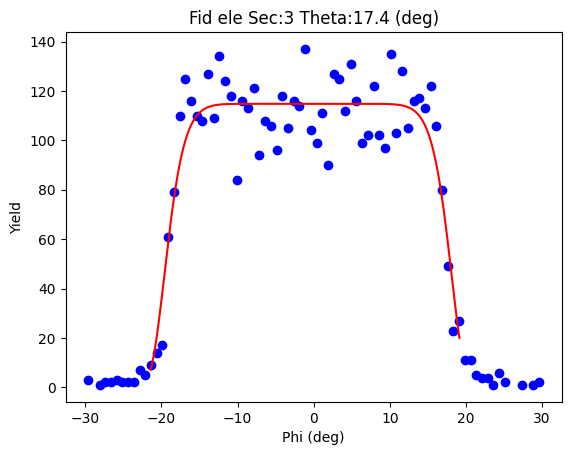

...........Theta: 18.6 ............
Binning| Sec: 2  Ybin: 15
Sum of plot 5957.0
Initial Bounds: [-22.3146701346636, 20.8280073190423]
Sum of initial fit area: 5902.0
max at  140.0
initial max 114.78907774988822
initial guesses: [140.0, -0.7433314078106512, 13.43048285932568, 11.999999999999998]
fit bounds [-22.3146701346636, 20.8280073190423]
(array([116.81545847,  -0.73449594,  14.0268088 ,  12.        ]), array([[ 5.67194687e+00,  1.36939366e-04, -6.61206178e-02,
        -1.69161905e+00],
       [ 1.36939366e-04,  3.96099829e-02,  2.98809043e-05,
        -5.33330519e-04],
       [-6.61206178e-02,  2.98809043e-05,  2.36900460e-02,
        -6.95922146e-02],
       [-1.69161905e+00, -5.33330519e-04, -6.95922146e-02,
         4.26800123e+00]]))
[116.81545847  -0.73449594  14.0268088   12.        ]
[116.81545847  -0.73449594  14.0268088   12.        ]
New Bounds for next fit: [-23.263622188744268, 21.794630302101684]


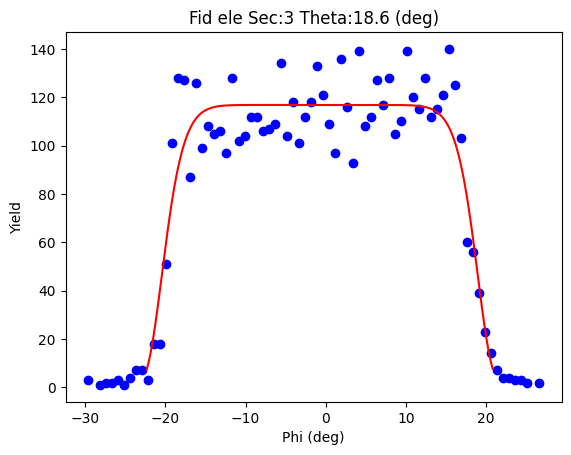

...........Theta: 19.8 ............
Binning| Sec: 2  Ybin: 16
Sum of plot 6438.0
Initial Bounds: [-23.263622188744268, 21.794630302101684]
Sum of initial fit area: 6375.0
max at  164.0
initial max 116.81545846709412
initial guesses: [164.0, -0.7344959433212922, 14.026808799681792, 11.999999999999998]
fit bounds [-23.263622188744268, 21.794630302101684]
(array([123.83497962,  -0.93722626,  14.28422269,  12.        ]), array([[ 5.70777903e+00, -7.01365527e-04, -6.63522621e-02,
        -1.56699993e+00],
       [-7.01365527e-04,  3.65699430e-02, -1.28424907e-04,
         2.45581808e-03],
       [-6.63522621e-02, -1.28424907e-04,  2.15949204e-02,
        -5.53462914e-02],
       [-1.56699993e+00,  2.45581808e-03, -5.53462914e-02,
         3.67875617e+00]]))
[123.83497962  -0.93722626  14.28422269  12.        ]
[123.83497962  -0.93722626  14.28422269  12.        ]
New Bounds for next fit: [-23.87979722192932, 22.005344706292473]


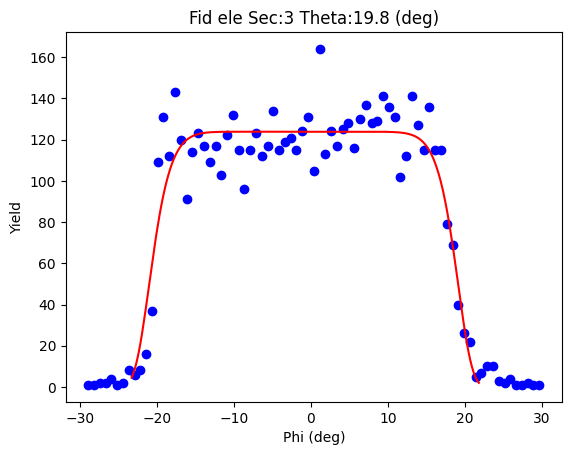

...........Theta: 21.0 ............
Binning| Sec: 2  Ybin: 17
Sum of plot 6628.0
Initial Bounds: [-23.87979722192932, 22.005344706292473]
Sum of initial fit area: 6572.0
max at  142.0
initial max 123.83497961951026
initial guesses: [142.0, -0.9372262578184228, 14.28422268937722, 11.999999999999998]
fit bounds [-23.87979722192932, 22.005344706292473]
(array([123.547543  ,  -0.51338958,  14.79810483,  12.        ]), array([[ 4.01325793e+00,  4.59272921e-03, -4.36936034e-02,
        -1.16761885e+00],
       [ 4.59272921e-03,  2.85994307e-02,  1.18581763e-03,
        -1.80095300e-02],
       [-4.36936034e-02,  1.18581763e-03,  1.75091767e-02,
        -5.83534507e-02],
       [-1.16761885e+00, -1.80095300e-02, -5.83534507e-02,
         2.85699409e+00]]))
[123.547543    -0.51338958  14.79810483  12.        ]
[123.547543    -0.51338958  14.79810483  12.        ]
New Bounds for next fit: [-24.28133115371543, 23.25455198683004]


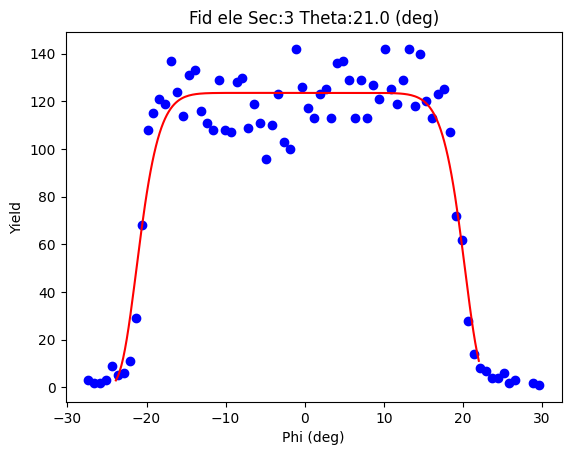

...........Theta: 22.2 ............
Binning| Sec: 2  Ybin: 18
Sum of plot 6793.0
Initial Bounds: [-24.28133115371543, 23.25455198683004]
Sum of initial fit area: 6757.0
max at  138.0
initial max 123.54754300022968
initial guesses: [138.0, -0.5133895834426956, 14.79810483266991, 11.999999999999998]
fit bounds [-24.28133115371543, 23.25455198683004]
(array([123.31069104,  -0.35366244,  15.22430958,  12.        ]), array([[ 3.97401818e+00,  1.21495879e-04, -4.77193058e-02,
        -1.12145485e+00],
       [ 1.21495879e-04,  2.93341981e-02,  2.72757361e-05,
        -4.48336609e-04],
       [-4.77193058e-02,  2.72757361e-05,  1.75340781e-02,
        -4.72167061e-02],
       [-1.12145485e+00, -4.48336609e-04, -4.72167061e-02,
         2.67879999e+00]]))
[123.31069104  -0.35366244  15.22430958  12.        ]
[123.31069104  -0.35366244  15.22430958  12.        ]
New Bounds for next fit: [-24.806151765053258, 24.098826891632584]


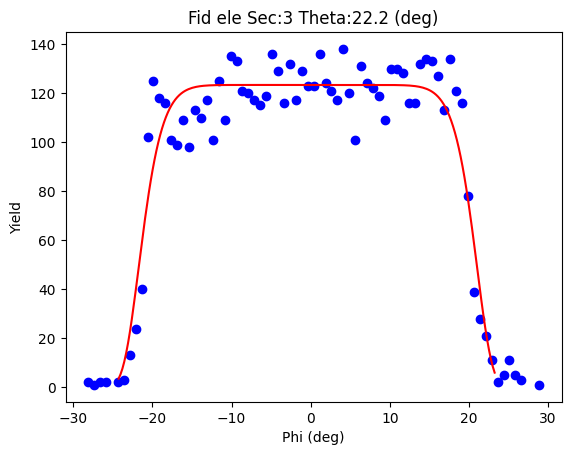

...........Theta: 23.4 ............
Binning| Sec: 2  Ybin: 19
Sum of plot 6741.0
Initial Bounds: [-24.806151765053258, 24.098826891632584]
Sum of initial fit area: 6710.0
max at  141.0
initial max 123.31069104176919
initial guesses: [141.0, -0.3536624367103363, 15.224309578122568, 11.999999999999998]
fit bounds [-24.806151765053258, 24.098826891632584]
(array([119.37414555,  -0.42531187,  15.60749773,  12.        ]), array([[ 4.69943299e+00, -2.57125280e-04, -6.09393606e-02,
        -1.35305561e+00],
       [-2.57125280e-04,  3.87722284e-02, -5.75095570e-05,
         9.58846343e-04],
       [-6.09393606e-02, -5.75095570e-05,  2.30184662e-02,
        -5.69206302e-02],
       [-1.35305561e+00,  9.58846343e-04, -5.69206302e-02,
         3.31475921e+00]]))
[119.37414555  -0.42531187  15.60749773  12.        ]
[119.37414555  -0.42531187  15.60749773  12.        ]
New Bounds for next fit: [-25.493257948625185, 24.64263421546464]


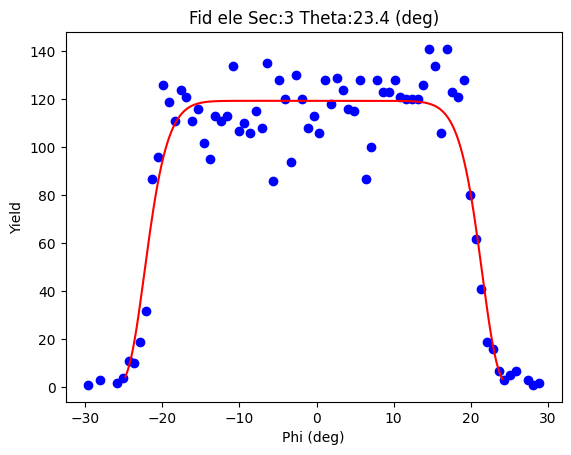

...........Theta: 24.6 ............
Binning| Sec: 2  Ybin: 20
Sum of plot 6300.0
Initial Bounds: [-25.493257948625185, 24.64263421546464]
Sum of initial fit area: 6286.0
max at  126.0
initial max 119.37414554732376
initial guesses: [126.0, -0.425311866580274, 15.607497728191396, 11.999999999999998]
fit bounds [-25.493257948625185, 24.64263421546464]
(array([110.17544235,  -0.12914267,  15.84865518,  12.        ]), array([[ 2.81545420e+00,  3.53433880e-04, -4.11359461e-02,
        -8.63951431e-01],
       [ 3.53433880e-04,  2.80237603e-02,  7.75552955e-05,
        -1.37200655e-03],
       [-4.11359461e-02,  7.75552955e-05,  1.65066469e-02,
        -3.71101951e-02],
       [-8.63951431e-01, -1.37200655e-03, -3.71101951e-02,
         2.27304957e+00]]))
[110.17544235  -0.12914267  15.84865518  12.        ]
[110.17544235  -0.12914267  15.84865518  12.        ]
New Bounds for next fit: [-25.58442322682517, 25.32613788677624]


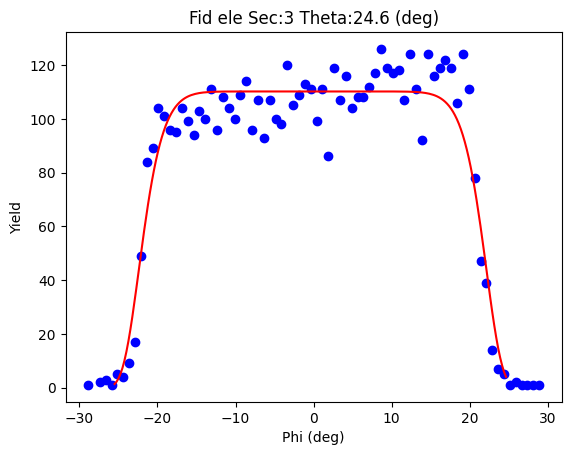

...........Theta: 25.8 ............
Binning| Sec: 2  Ybin: 21
Sum of plot 6034.0
Initial Bounds: [-25.58442322682517, 25.32613788677624]
Sum of initial fit area: 6011.0
max at  130.0
initial max 110.17544234989273
initial guesses: [130.0, -0.12914267002446514, 15.848655177430176, 11.999999999999998]
fit bounds [-25.58442322682517, 25.32613788677624]
(array([103.26762231,  -0.11714116,  16.18797916,  12.        ]), array([[ 3.97487772e+00, -3.66739831e-04, -6.28800189e-02,
        -1.30747028e+00],
       [-3.66739831e-04,  4.70190634e-02, -9.13808519e-05,
         1.54062389e-03],
       [-6.28800189e-02, -9.13808519e-05,  2.77527440e-02,
        -6.24598988e-02],
       [-1.30747028e+00,  1.54062389e-03, -6.24598988e-02,
         3.67881307e+00]]))
[103.26762231  -0.11714116  16.18797916  12.        ]
[103.26762231  -0.11714116  16.18797916  12.        ]
New Bounds for next fit: [-26.117426141943376, 25.88314381787194]


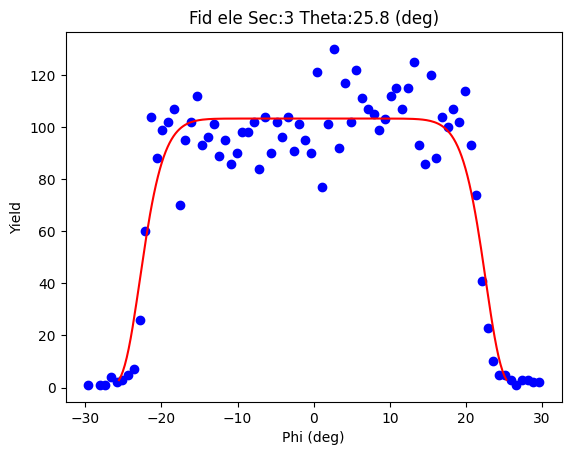

...........Theta: 27.0 ............
Binning| Sec: 2  Ybin: 22
Sum of plot 5667.0
Initial Bounds: [-26.117426141943376, 25.88314381787194]
Sum of initial fit area: 5658.0
max at  129.0
initial max 103.26762231066664
initial guesses: [129.0, -0.1171411620357191, 16.187979159844062, 11.999999999999998]
fit bounds [-26.117426141943376, 25.88314381787194]
(array([96.43387191,  0.15014647, 16.31730691, 12.        ]), array([[ 3.39016584e+00,  9.39435426e-05, -5.90243637e-02,
        -1.17717374e+00],
       [ 9.39435426e-05,  4.66119347e-02,  2.13948428e-05,
        -3.99649685e-04],
       [-5.90243637e-02,  2.13948428e-05,  2.73433634e-02,
        -5.69641407e-02],
       [-1.17717374e+00, -3.99649685e-04, -5.69641407e-02,
         3.52111479e+00]]))
[96.43387191  0.15014647 16.31730691 12.        ]
[96.43387191  0.15014647 16.31730691 12.        ]
New Bounds for next fit: [-26.057857978226863, 26.35815090970776]


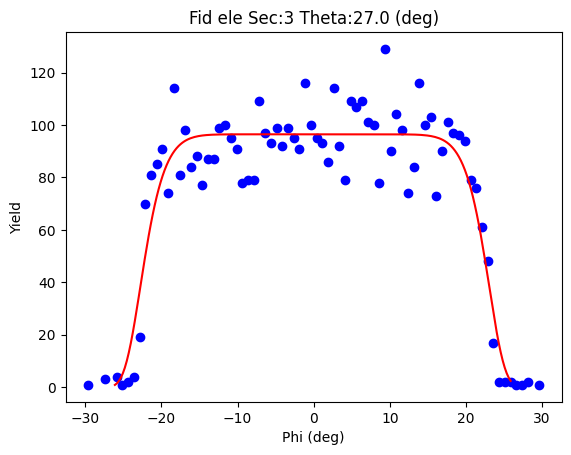

...........Theta: 28.2 ............
Binning| Sec: 2  Ybin: 23
Sum of plot 5266.0
Initial Bounds: [-26.057857978226863, 26.35815090970776]
Sum of initial fit area: 5244.0
max at  118.0
initial max 96.4338719125813
initial guesses: [118.0, 0.15014646574044718, 16.31730690982412, 11.999999999999998]
fit bounds [-26.057857978226863, 26.35815090970776]
(array([8.84618525e+01, 2.32410370e-02, 1.64827608e+01, 1.20000000e+01]), array([[ 3.06329904e+00,  3.14068774e-05, -5.84147920e-02,
        -1.16439263e+00],
       [ 3.14068774e-05,  5.10981478e-02,  8.45254705e-06,
        -1.49079583e-04],
       [-5.84147920e-02,  8.45254705e-06,  3.00241935e-02,
        -6.31380279e-02],
       [-1.16439263e+00, -1.49079583e-04, -6.31380279e-02,
         3.80431983e+00]]))
[8.84618525e+01 2.32410370e-02 1.64827608e+01 1.20000000e+01]
[8.84618525e+01 2.32410370e-02 1.64827608e+01 1.20000000e+01]
New Bounds for next fit: [-26.450506737826185, 26.496988811882193]


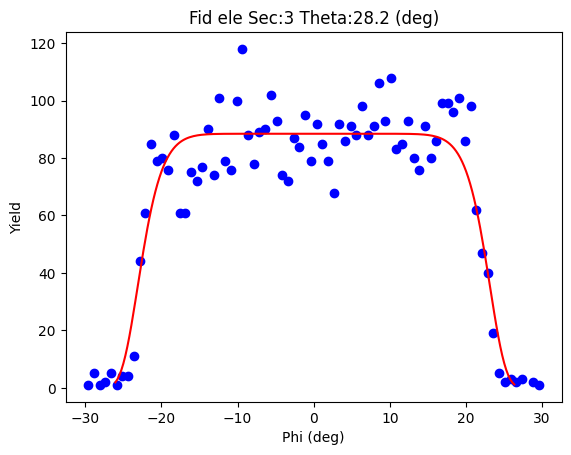

...........Theta: 29.4 ............
Binning| Sec: 2  Ybin: 24
Sum of plot 4603.0
Initial Bounds: [-26.450506737826185, 26.496988811882193]
Sum of initial fit area: 4596.0
max at  94.0
initial max 88.46185252150364
initial guesses: [94.0, 0.023241037028003262, 16.482760769487143, 11.999999999999998]
fit bounds [-26.450506737826185, 26.496988811882193]
(array([76.67759018,  0.1765701 , 16.68603252, 12.        ]), array([[ 2.25098378e+00,  4.62017472e-04, -4.92527354e-02,
        -9.99621769e-01],
       [ 4.62017472e-04,  5.13481409e-02,  1.62941430e-04,
        -2.63143946e-03],
       [-4.92527354e-02,  1.62941430e-04,  3.03453613e-02,
        -6.71080310e-02],
       [-9.99621769e-01, -2.63143946e-03, -6.71080310e-02,
         3.79334599e+00]]))
[76.67759018  0.1765701  16.68603252 12.        ]
[76.67759018  0.1765701  16.68603252 12.        ]
New Bounds for next fit: [-26.623662121502896, 26.976802316679617]


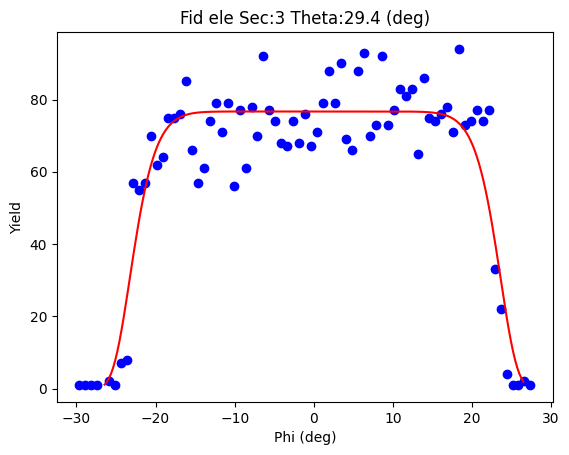

...........Theta: 30.6 ............
Binning| Sec: 2  Ybin: 25
Sum of plot 4039.0
Initial Bounds: [-26.623662121502896, 26.976802316679617]
Sum of initial fit area: 4029.0
max at  85.0
initial max 76.6775901752454
initial guesses: [85.0, 0.17657009758836123, 16.686032517600946, 11.999999999999998]
fit bounds [-26.623662121502896, 26.976802316679617]
(array([ 6.67607056e+01, -6.19917929e-02,  1.68091410e+01,  1.20000000e+01]), array([[ 1.66737912e+00, -2.03205145e-04, -4.16011508e-02,
        -8.58852300e-01],
       [-2.03205145e-04,  5.10277344e-02, -8.81510194e-05,
         1.35832612e-03],
       [-4.16011508e-02, -8.81510194e-05,  3.03043370e-02,
        -6.97876435e-02],
       [-8.58852300e-01,  1.35832612e-03, -6.97876435e-02,
         3.76354564e+00]]))
[ 6.67607056e+01 -6.19917929e-02  1.68091410e+01  1.20000000e+01]
[ 6.67607056e+01 -6.19917929e-02  1.68091410e+01  1.20000000e+01]
New Bounds for next fit: [-27.059954467798562, 26.935970882063003]


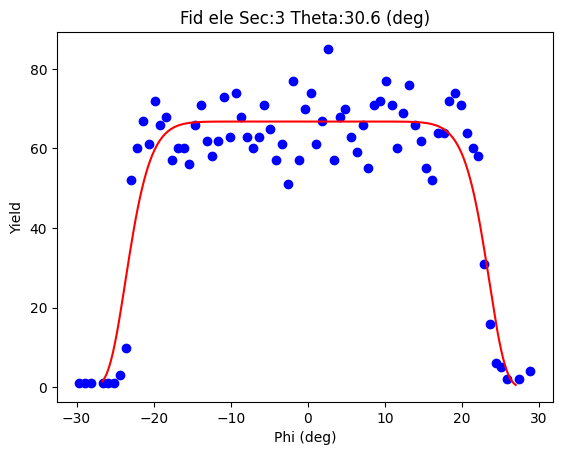

...........Theta: 31.8 ............
Binning| Sec: 2  Ybin: 26
Sum of plot 3438.0
Initial Bounds: [-27.059954467798562, 26.935970882063003]
Sum of initial fit area: 3435.0
max at  77.0
initial max 66.76070562419815
initial guesses: [77.0, -0.06199179286777949, 16.8091410335603, 11.999999999999998]
fit bounds [-27.059954467798562, 26.935970882063003]
(array([56.49172305,  0.11796044, 16.94911932, 12.        ]), array([[ 1.86891217e+00,  6.50345724e-03, -5.00835409e-02,
        -1.19699479e+00],
       [ 6.50345724e-03,  8.43866709e-02,  4.41962579e-03,
        -5.68309595e-02],
       [-5.00835409e-02,  4.41962579e-03,  5.19849794e-02,
        -1.57660006e-01],
       [-1.19699479e+00, -5.68309595e-02, -1.57660006e-01,
         6.44982218e+00]]))
[56.49172305  0.11796044 16.94911932 12.        ]
[56.49172305  0.11796044 16.94911932 12.        ]
New Bounds for next fit: [-27.104828033299075, 27.340748906342686]


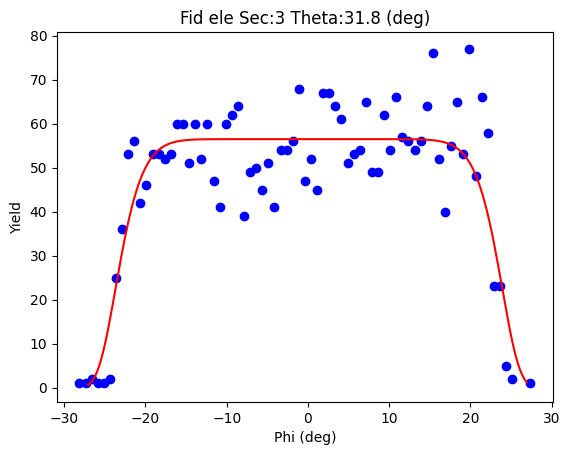

...........Theta: 33.0 ............
Binning| Sec: 2  Ybin: 27
Sum of plot 2817.0
Initial Bounds: [-27.104828033299075, 27.340748906342686]
Sum of initial fit area: 2817.0
max at  62.0
initial max 56.49172304949266
initial guesses: [62.0, 0.11796043652180485, 16.949119317840214, 11.999999999999998]
fit bounds [-27.104828033299075, 27.340748906342686]
(array([45.78059904,  0.14599235, 17.20374766, 12.        ]), array([[ 1.25782662e+00, -7.52265497e-03, -3.19534697e-02,
        -1.08694118e+00],
       [-7.52265497e-03,  9.96157105e-02, -1.22391884e-02,
         1.08392807e-01],
       [-3.19534697e-02, -1.22391884e-02,  6.86854617e-02,
        -2.96931958e-01],
       [-1.08694118e+00,  1.08392807e-01, -2.96931958e-01,
         7.86639977e+00]]))
[45.78059904  0.14599235 17.20374766 12.        ]
[45.78059904  0.14599235 17.20374766 12.        ]
New Bounds for next fit: [-27.48576683169967, 27.777751531934918]


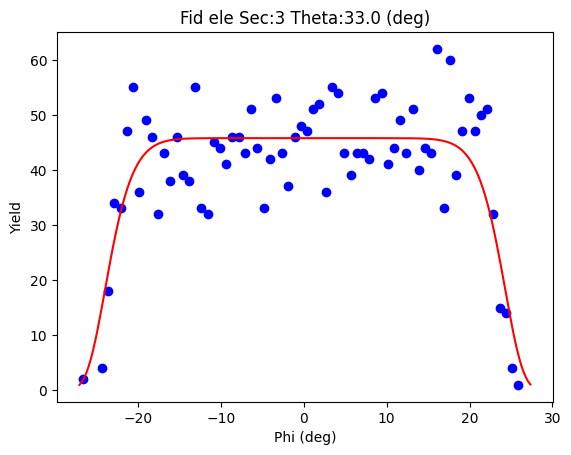

...........Theta: 34.2 ............
Binning| Sec: 2  Ybin: 28
Sum of plot 2086.0
Initial Bounds: [-27.48576683169967, 27.777751531934918]
Sum of initial fit area: 2086.0
max at  46.0
initial max 45.780599043647854
initial guesses: [46.0, 0.1459923501176227, 17.203747656256528, 11.999999999999998]
fit bounds [-27.48576683169967, 27.777751531934918]
(array([33.91256144, -0.1980512 , 17.22809119, 12.        ]), array([[ 8.38455491e-01, -8.21665403e-03, -3.10982131e-02,
        -9.46173471e-01],
       [-8.21665403e-03,  1.29372378e-01, -2.34551020e-02,
         1.82525029e-01],
       [-3.10982131e-02, -2.34551020e-02,  8.73302665e-02,
        -3.55465826e-01],
       [-9.46173471e-01,  1.82525029e-01, -3.55465826e-01,
         9.21473723e+00]]))
[33.91256144 -0.1980512  17.22809119 12.        ]
[33.91256144 -0.1980512  17.22809119 12.        ]
New Bounds for next fit: [-27.868909691656548, 27.472807286811147]


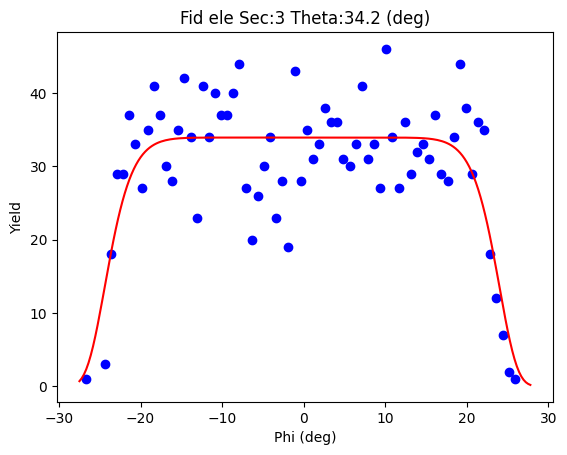

...........Theta: 35.4 ............
Binning| Sec: 2  Ybin: 29
Sum of plot 1484.0
Initial Bounds: [-27.868909691656548, 27.472807286811147]
Sum of initial fit area: 1484.0
max at  37.0
initial max 33.912561437391844
initial guesses: [37.0, -0.1980512024227016, 17.228091188418297, 11.999999999999998]
fit bounds [-27.868909691656548, 27.472807286811147]
(array([23.93648342,  0.11726254, 17.38270407, 12.        ]), array([[ 4.06651826e-01, -7.81798667e-03, -1.06761614e-02,
        -7.50369725e-01],
       [-7.81798667e-03,  1.35463975e-01, -2.34163486e-02,
         2.08235458e-01],
       [-1.06761614e-02, -2.34163486e-02,  1.10189227e-01,
        -5.98030662e-01],
       [-7.50369725e-01,  2.08235458e-01, -5.98030662e-01,
         1.14393426e+01]]))
[23.93648342  0.11726254 17.38270407 12.        ]
[23.93648342  0.11726254 17.38270407 12.        ]
New Bounds for next fit: [-27.801927073134404, 28.036452149534593]


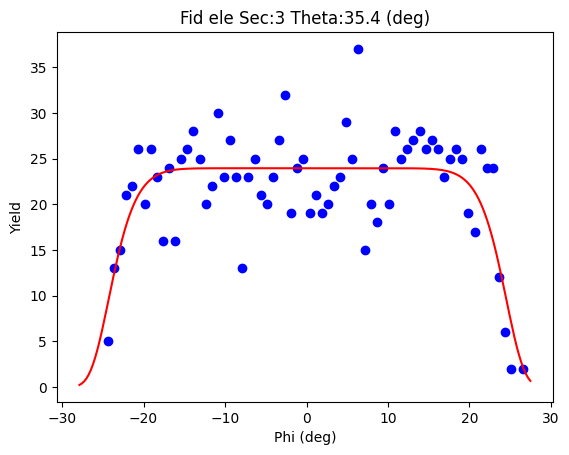

...........Theta: 36.6 ............
Binning| Sec: 2  Ybin: 30
Sum of plot 1185.0
Initial Bounds: [-27.801927073134404, 28.036452149534593]
Sum of initial fit area: 1185.0
max at  30.0
initial max 23.936483422088788
initial guesses: [30.0, 0.1172625382000949, 17.382704071792944, 11.999999999999998]
fit bounds [-27.801927073134404, 28.036452149534593]
(array([18.96732723,  0.12595016, 17.43887994, 12.        ]), array([[ 4.50635185e-01, -4.28804638e-03, -2.41087059e-02,
        -9.94035741e-01],
       [-4.28804638e-03,  2.05311984e-01, -1.27377388e-02,
         1.29493654e-01],
       [-2.41087059e-02, -1.27377388e-02,  1.46938378e-01,
        -6.89065095e-01],
       [-9.94035741e-01,  1.29493654e-01, -6.89065095e-01,
         1.76054841e+01]]))
[18.96732723  0.12595016 17.43887994 12.        ]
[18.96732723  0.12595016 17.43887994 12.        ]
New Bounds for next fit: [-27.88346618689196, 28.135366505276384]


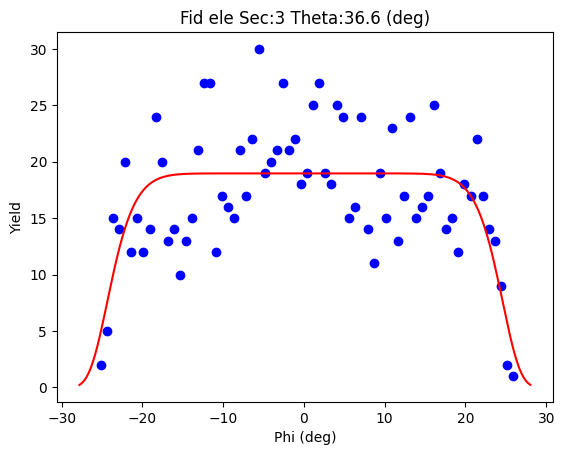

...........Theta: 37.8 ............
Binning| Sec: 2  Ybin: 31
Sum of plot 918.0
Initial Bounds: [-27.88346618689196, 28.135366505276384]
Sum of initial fit area: 916.0
max at  26.0
initial max 18.967327231886827
initial guesses: [26.0, 0.12595015919221256, 17.438879936900186, 11.999999999998465]
fit bounds [-27.88346618689196, 28.135366505276384]
(array([16.30802741,  0.16893515, 16.76641734,  4.9662475 ]), array([[ 0.56073629,  0.00345886, -0.06636485, -0.57674522],
       [ 0.00345886,  0.52017018,  0.01376821, -0.02433438],
       [-0.06636485,  0.01376821,  0.48502693, -0.4365023 ],
       [-0.57674522, -0.02433438, -0.4365023 ,  2.250324  ]]))
[16.30802741  0.16893515 16.76641734  4.9662475 ]
[16.30802741  0.16893515 16.76641734  4.9662475 ]
New Bounds for next fit: [-32.07929915643767, 32.41716946160713]


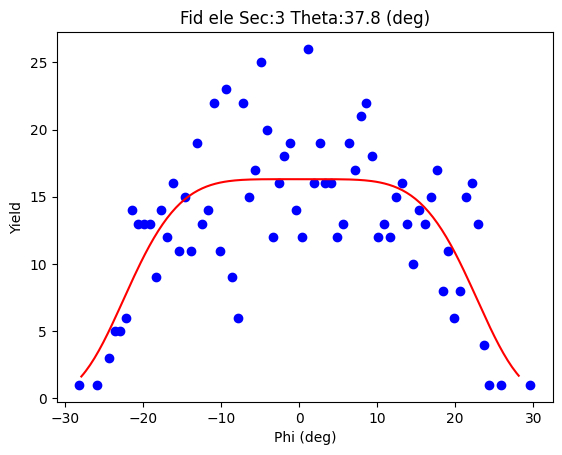

==========Sec  4 ===============
...........Theta: 9.0 ............
Binning| Sec: 3  Ybin: 7
Sum of plot 1190.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 1118.0
max at  76.0
initial max 16.308027413402083
initial guesses: [76.0, 0.16893515258473163, 16.766417343366577, 4.966247504049429]
fit bounds [-10.0, 10.0]
(array([63.95115979,  1.30734234,  5.49355917,  2.57382648]), array([[ 5.98747578e+00,  2.99828182e-02, -2.02865087e-01,
        -6.11547923e-01],
       [ 2.99828182e-02,  3.83858258e-02,  5.91798497e-03,
        -1.33090290e-02],
       [-2.02865087e-01,  5.91798497e-03,  3.86037695e-02,
        -9.20582021e-04],
       [-6.11547923e-01, -1.33090290e-02, -9.20582021e-04,
         1.54210814e-01]]))
[63.95115979  1.30734234  5.49355917  2.57382648]
[63.95115979  1.30734234  5.49355917  2.57382648]
New Bounds for next fit: [-12.754990789117581, 15.369675475158449]


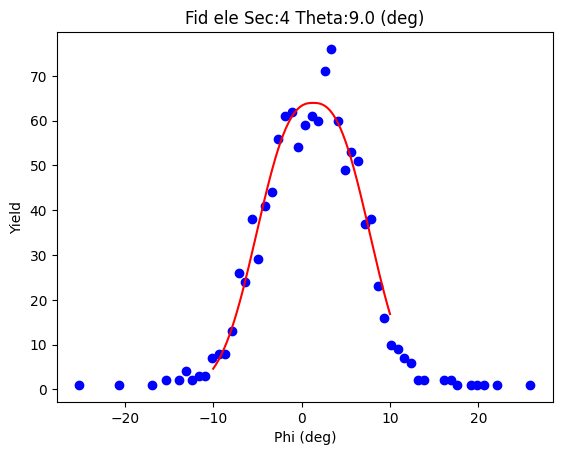

...........Theta: 10.2 ............
Binning| Sec: 3  Ybin: 8
Sum of plot 2191.0
Initial Bounds: [-12.754990789117581, 15.369675475158449]
Sum of initial fit area: 2150.0
max at  100.0
initial max 63.951159794292984
initial guesses: [100.0, 1.3073423430204345, 5.493559169308848, 2.573826478341141]
fit bounds [-12.754990789117581, 15.369675475158449]
(array([82.67461693,  0.32509656,  7.64494511,  4.10264248]), array([[ 6.23719818e+00, -9.10836664e-03, -1.69111455e-01,
        -7.79110063e-01],
       [-9.10836664e-03,  4.26966356e-02, -1.17820812e-03,
         6.14903698e-03],
       [-1.69111455e-01, -1.17820812e-03,  3.12629839e-02,
         8.12371640e-04],
       [-7.79110063e-01,  6.14903698e-03,  8.12371640e-04,
         3.35597441e-01]]))
[82.67461693  0.32509656  7.64494511  4.10264248]
[82.67461693  0.32509656  7.64494511  4.10264248]
New Bounds for next fit: [-15.362355679553717, 16.01254879235848]


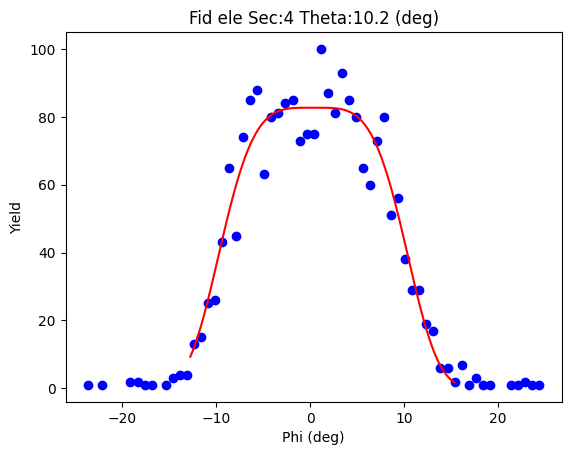

...........Theta: 11.4 ............
Binning| Sec: 3  Ybin: 9
Sum of plot 3076.0
Initial Bounds: [-15.362355679553717, 16.01254879235848]
Sum of initial fit area: 3015.0
max at  109.0
initial max 82.67461693040191
initial guesses: [109.0, 0.3250965564023806, 7.644945109085166, 4.102642477440524]
fit bounds [-15.362355679553717, 16.01254879235848]
(array([94.07588696, -0.18744074,  9.1665734 ,  6.2388419 ]), array([[ 4.63844173e+00, -4.81003561e-03, -8.51964226e-02,
        -8.35811022e-01],
       [-4.81003561e-03,  3.11160057e-02, -7.83705395e-04,
         6.52032994e-03],
       [-8.51964226e-02, -7.83705395e-04,  2.02900583e-02,
        -1.44469081e-02],
       [-8.35811022e-01,  6.52032994e-03, -1.44469081e-02,
         7.22389398e-01]]))
[94.07588696 -0.18744074  9.1665734   6.2388419 ]
[94.07588696 -0.18744074  9.1665734   6.2388419 ]
New Bounds for next fit: [-16.746326907290328, 16.37144542994133]


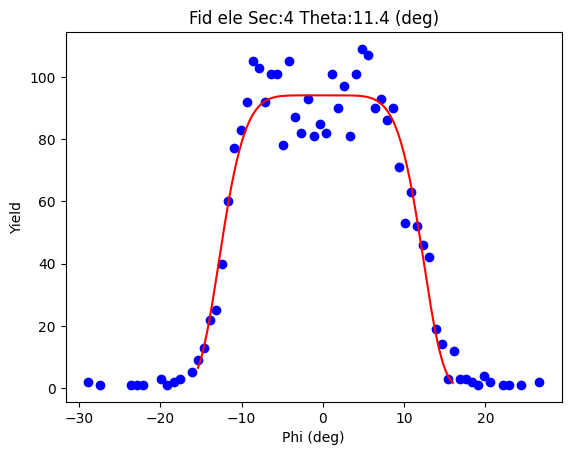

...........Theta: 12.6 ............
Binning| Sec: 3  Ybin: 10
Sum of plot 3746.0
Initial Bounds: [-16.746326907290328, 16.37144542994133]
Sum of initial fit area: 3680.0
max at  127.0
initial max 94.07588696248773
initial guesses: [127.0, -0.18744073867449934, 9.1665733955182, 6.238841900288037]
fit bounds [-16.746326907290328, 16.37144542994133]
(array([101.37101941,  -0.51420396,  10.23538824,   8.04686888]), array([[ 5.79277997e+00, -5.98560118e-03, -8.29594267e-02,
        -1.30614610e+00],
       [-5.98560118e-03,  3.71067801e-02, -1.13283190e-03,
         1.26439180e-02],
       [-8.29594267e-02, -1.13283190e-03,  2.33846063e-02,
        -3.74692713e-02],
       [-1.30614610e+00,  1.26439180e-02, -3.74692713e-02,
         1.74553777e+00]]))
[101.37101941  -0.51420396  10.23538824   8.04686888]
[101.37101941  -0.51420396  10.23538824   8.04686888]
New Bounds for next fit: [-18.01436904506172, 16.985961130705064]


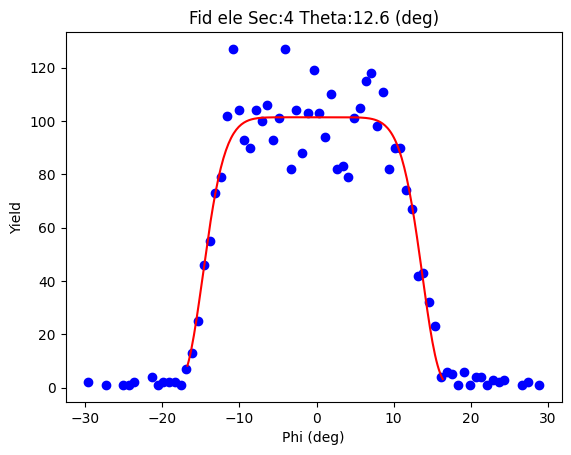

...........Theta: 13.8 ............
Binning| Sec: 3  Ybin: 11
Sum of plot 4543.0
Initial Bounds: [-18.01436904506172, 16.985961130705064]
Sum of initial fit area: 4455.0
max at  140.0
initial max 101.37101940912525
initial guesses: [140.0, -0.5142039571783272, 10.235388237064102, 8.04686888253378]
fit bounds [-18.01436904506172, 16.985961130705064]
(array([108.71363228,  -0.64099728,  11.57897195,   8.73247827]), array([[ 5.95113708e+00, -8.49198688e-03, -6.03786013e-02,
        -1.56179292e+00],
       [-8.49198688e-03,  4.31543599e-02, -2.53995343e-03,
         2.28478773e-02],
       [-6.03786013e-02, -2.53995343e-03,  3.03099650e-02,
        -9.72618741e-02],
       [-1.56179292e+00,  2.28478773e-02, -9.72618741e-02,
         2.50697349e+00]]))
[108.71363228  -0.64099728  11.57897195   8.73247827]
[108.71363228  -0.64099728  11.57897195   8.73247827]
New Bounds for next fit: [-20.145577072747518, 18.863582512684406]


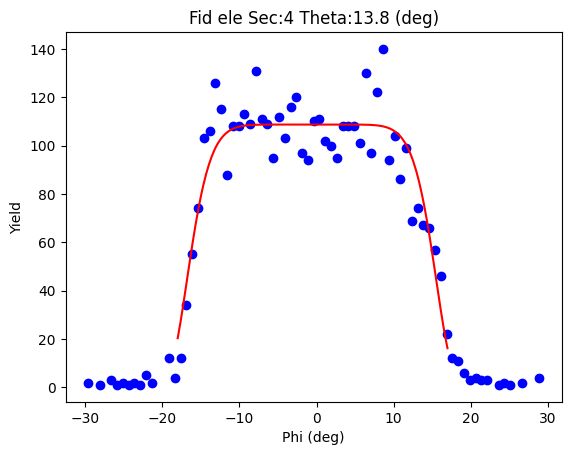

...........Theta: 15.0 ............
Binning| Sec: 3  Ybin: 12
Sum of plot 5199.0
Initial Bounds: [-20.145577072747518, 18.863582512684406]
Sum of initial fit area: 5140.0
max at  128.0
initial max 108.71363227868275
initial guesses: [128.0, -0.6409972800315541, 11.578971950485338, 8.73247827154805]
fit bounds [-20.145577072747518, 18.863582512684406]
(array([114.08282691,  -0.48657692,  12.48971864,  12.        ]), array([[ 2.80180290e+00,  8.68845919e-04, -3.01517072e-02,
        -8.48447456e-01],
       [ 8.68845919e-04,  1.62502181e-02,  1.65083419e-04,
        -3.40727331e-03],
       [-3.01517072e-02,  1.65083419e-04,  9.67719369e-03,
        -3.08077199e-02],
       [-8.48447456e-01, -3.40727331e-03, -3.08077199e-02,
         2.18276359e+00]]))
[114.08282691  -0.48657692  12.48971864  12.        ]
[114.08282691  -0.48657692  12.48971864  12.        ]
New Bounds for next fit: [-20.546909389618577, 19.573755544608936]


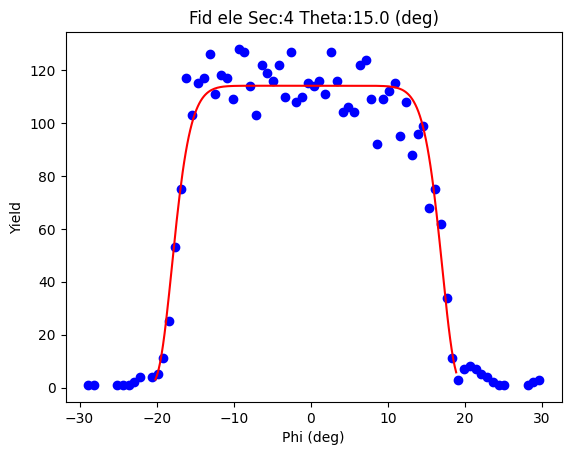

...........Theta: 16.2 ............
Binning| Sec: 3  Ybin: 13
Sum of plot 5995.0
Initial Bounds: [-20.546909389618577, 19.573755544608936]
Sum of initial fit area: 5914.0
max at  138.0
initial max 114.08282690990187
initial guesses: [138.0, -0.48657692250482015, 12.489718638396788, 11.999999999999998]
fit bounds [-20.546909389618577, 19.573755544608936]
(array([125.15765094,  -0.69809545,  13.14278169,  12.        ]), array([[ 3.05616037e+00, -3.62226815e-03, -2.56213025e-02,
        -9.30426088e-01],
       [-3.62226815e-03,  1.72020930e-02, -9.66182251e-04,
         1.49726934e-02],
       [-2.56213025e-02, -9.66182251e-04,  1.10353732e-02,
        -5.18712067e-02],
       [-9.30426088e-01,  1.49726934e-02, -5.18712067e-02,
         2.33443201e+00]]))
[125.15765094  -0.69809545  13.14278169  12.        ]
[125.15765094  -0.69809545  13.14278169  12.        ]
New Bounds for next fit: [-21.807343614859008, 20.411152719970566]


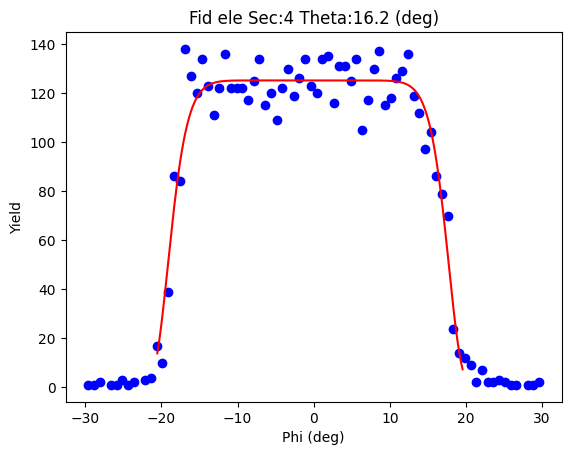

...........Theta: 17.4 ............
Binning| Sec: 3  Ybin: 14
Sum of plot 6524.0
Initial Bounds: [-21.807343614859008, 20.411152719970566]
Sum of initial fit area: 6474.0
max at  151.0
initial max 125.1576509371399
initial guesses: [151.0, -0.6980954474442193, 13.14278169174516, 11.999999999999996]
fit bounds [-21.807343614859008, 20.411152719970566]
(array([130.21388703,  -0.67022143,  13.80739562,  12.        ]), array([[ 4.42191418e+00,  1.04044067e-03, -4.04945647e-02,
        -1.25710764e+00],
       [ 1.04044067e-03,  2.46459816e-02,  2.49614604e-04,
        -3.94898048e-03],
       [-4.04945647e-02,  2.49614604e-04,  1.53880807e-02,
        -6.03933030e-02],
       [-1.25710764e+00, -3.94898048e-03, -6.03933030e-02,
         2.95801064e+00]]))
[130.21388703  -0.67022143  13.80739562  12.        ]
[130.21388703  -0.67022143  13.80739562  12.        ]
New Bounds for next fit: [-22.84693770852854, 21.506494845609243]


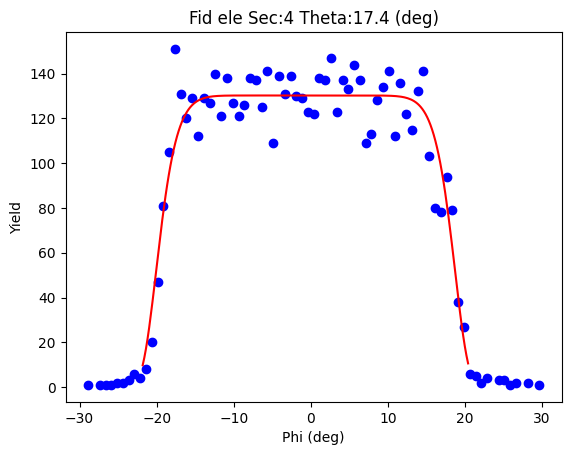

...........Theta: 18.6 ............
Binning| Sec: 3  Ybin: 15
Sum of plot 6664.0
Initial Bounds: [-22.84693770852854, 21.506494845609243]
Sum of initial fit area: 6616.0
max at  153.0
initial max 130.2138870316364
initial guesses: [153.0, -0.6702214314596492, 13.807395619101435, 11.999999999999993]
fit bounds [-22.84693770852854, 21.506494845609243]
(array([128.81630099,  -0.78316244,  14.25257086,  12.        ]), array([[ 4.64232379e+00, -2.71373326e-03, -4.89096417e-02,
        -1.26727710e+00],
       [-2.71373326e-03,  2.77407705e-02, -5.77630193e-04,
         9.78181831e-03],
       [-4.89096417e-02, -5.77630193e-04,  1.67068074e-02,
        -5.12644015e-02],
       [-1.26727710e+00,  9.78181831e-03, -5.12644015e-02,
         2.92254227e+00]]))
[128.81630099  -0.78316244  14.25257086  12.        ]
[128.81630099  -0.78316244  14.25257086  12.        ]
New Bounds for next fit: [-23.674895891752826, 22.10857101527977]


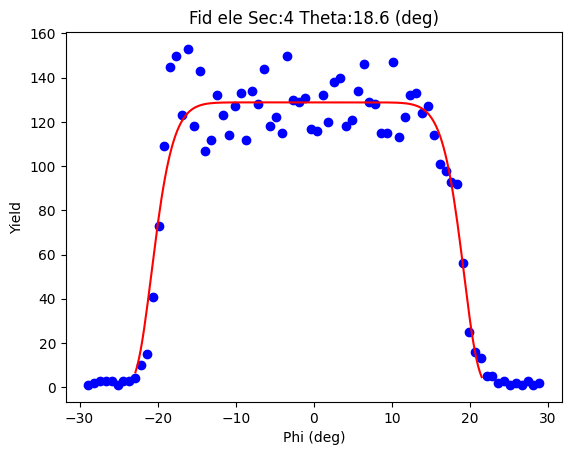

...........Theta: 19.8 ............
Binning| Sec: 3  Ybin: 16
Sum of plot 6902.0
Initial Bounds: [-23.674895891752826, 22.10857101527977]
Sum of initial fit area: 6862.0
max at  158.0
initial max 128.8163009851828
initial guesses: [158.0, -0.7831624382365282, 14.252570860842278, 11.999999999999998]
fit bounds [-23.674895891752826, 22.10857101527977]
(array([130.9321853 ,  -0.79120313,  14.53891648,  12.        ]), array([[ 4.46532147e+00,  1.05002933e-03, -4.95206944e-02,
        -1.16609226e+00],
       [ 1.05002933e-03,  2.65667817e-02,  1.92839340e-04,
        -3.52687085e-03],
       [-4.95206944e-02,  1.92839340e-04,  1.57367382e-02,
        -4.08995513e-02],
       [-1.16609226e+00, -3.52687085e-03, -4.08995513e-02,
         2.59849045e+00]]))
[130.9321853   -0.79120313  14.53891648  12.        ]
[130.9321853   -0.79120313  14.53891648  12.        ]
New Bounds for next fit: [-24.142849939758516, 22.560443677199547]


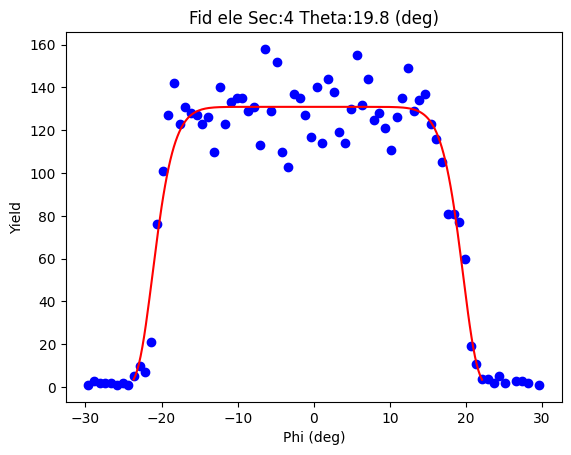

...........Theta: 21.0 ............
Binning| Sec: 3  Ybin: 17
Sum of plot 7301.0
Initial Bounds: [-24.142849939758516, 22.560443677199547]
Sum of initial fit area: 7252.0
max at  156.0
initial max 130.93218529919733
initial guesses: [156.0, -0.7912031312794835, 14.53891648402387, 11.999999999999998]
fit bounds [-24.142849939758516, 22.560443677199547]
(array([134.82489632,  -0.60419405,  14.93817074,  12.        ]), array([[ 3.54743197e+00,  5.93222290e-04, -3.85272685e-02,
        -9.10984056e-01],
       [ 5.93222290e-04,  2.10666089e-02,  1.16666835e-04,
        -1.98461106e-03],
       [-3.85272685e-02,  1.16666835e-04,  1.25578327e-02,
        -3.36778064e-02],
       [-9.10984056e-01, -1.98461106e-03, -3.36778064e-02,
         1.98472921e+00]]))
[134.82489632  -0.60419405  14.93817074  12.        ]
[134.82489632  -0.60419405  14.93817074  12.        ]
New Bounds for next fit: [-24.597102155606414, 23.388714059352672]


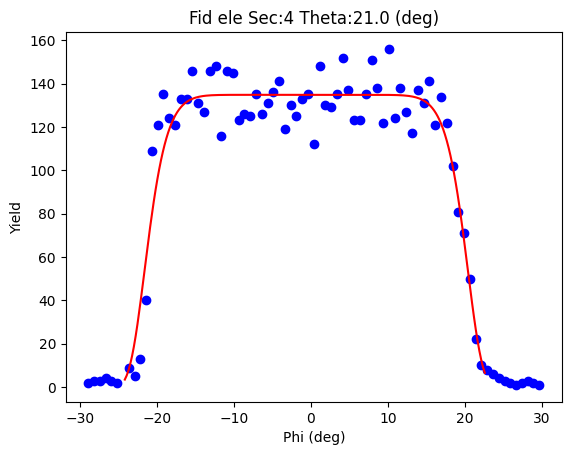

...........Theta: 22.2 ............
Binning| Sec: 3  Ybin: 18
Sum of plot 7530.0
Initial Bounds: [-24.597102155606414, 23.388714059352672]
Sum of initial fit area: 7485.0
max at  156.0
initial max 134.8248963215219
initial guesses: [156.0, -0.6041940481268707, 14.9381707442082, 11.999999999999998]
fit bounds [-24.597102155606414, 23.388714059352672]
(array([136.51308142,  -0.7522416 ,  15.21832102,  12.        ]), array([[ 4.85386524e+00, -5.92502272e-06, -5.47807910e-02,
        -1.20515945e+00],
       [-5.92502272e-06,  2.90217935e-02, -1.03030510e-06,
         1.87019272e-05],
       [-5.47807910e-02, -1.03030510e-06,  1.71115917e-02,
        -4.05039264e-02],
       [-1.20515945e+00,  1.87019272e-05, -4.05039264e-02,
         2.56195635e+00]]))
[136.51308142  -0.7522416   15.21832102  12.        ]
[136.51308142  -0.7522416   15.21832102  12.        ]
New Bounds for next fit: [-25.195112416773114, 23.690629213098973]


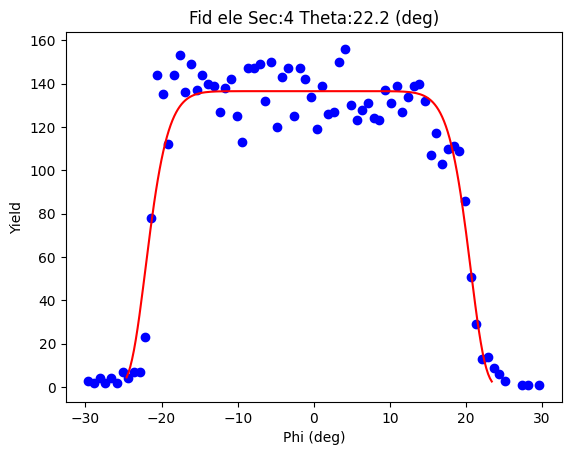

...........Theta: 23.4 ............
Binning| Sec: 3  Ybin: 19
Sum of plot 7836.0
Initial Bounds: [-25.195112416773114, 23.690629213098973]
Sum of initial fit area: 7801.0
max at  177.0
initial max 136.5130814212834
initial guesses: [177.0, -0.7522416018370692, 15.218321017047199, 11.999999999999998]
fit bounds [-25.195112416773114, 23.690629213098973]
(array([140.51278797,  -0.56639823,  15.40755196,  12.        ]), array([[ 4.24936808e+00,  1.11911279e-04, -4.79012512e-02,
        -1.01334820e+00],
       [ 1.11911279e-04,  2.45379756e-02,  1.66962533e-05,
        -3.27895982e-04],
       [-4.79012512e-02,  1.66962533e-05,  1.43983113e-02,
        -3.18712208e-02],
       [-1.01334820e+00, -3.27895982e-04, -3.18712208e-02,
         2.08092773e+00]]))
[140.51278797  -0.56639823  15.40755196  12.        ]
[140.51278797  -0.56639823  15.40755196  12.        ]
New Bounds for next fit: [-25.31320187586193, 24.18040542228199]


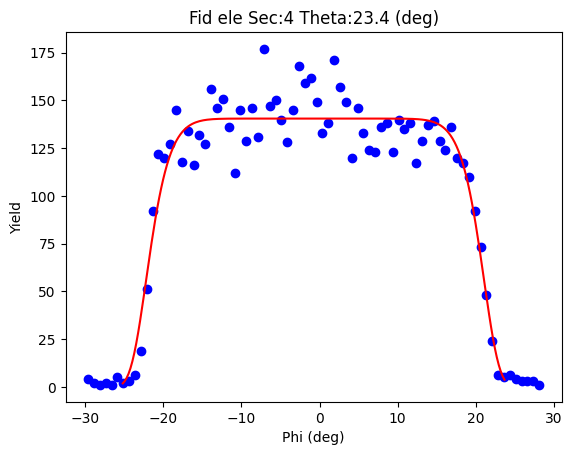

...........Theta: 24.6 ............
Binning| Sec: 3  Ybin: 20
Sum of plot 7915.0
Initial Bounds: [-25.31320187586193, 24.18040542228199]
Sum of initial fit area: 7887.0
max at  164.0
initial max 140.51278796906297
initial guesses: [164.0, -0.5663982267899706, 15.40755195773828, 11.999999999999888]
fit bounds [-25.31320187586193, 24.18040542228199]
(array([139.23713883,  -0.52253152,  15.72126701,  12.        ]), array([[ 3.45778069e+00,  4.85956529e-04, -3.92516010e-02,
        -8.45606821e-01],
       [ 4.85956529e-04,  2.12375723e-02,  8.86296400e-05,
        -1.52242527e-03],
       [-3.92516010e-02,  8.86296400e-05,  1.25514329e-02,
        -2.94776882e-02],
       [-8.45606821e-01, -1.52242527e-03, -2.94776882e-02,
         1.76726539e+00]]))
[139.23713883  -0.52253152  15.72126701  12.        ]
[139.23713883  -0.52253152  15.72126701  12.        ]
New Bounds for next fit: [-25.77320787725716, 24.728144831466818]


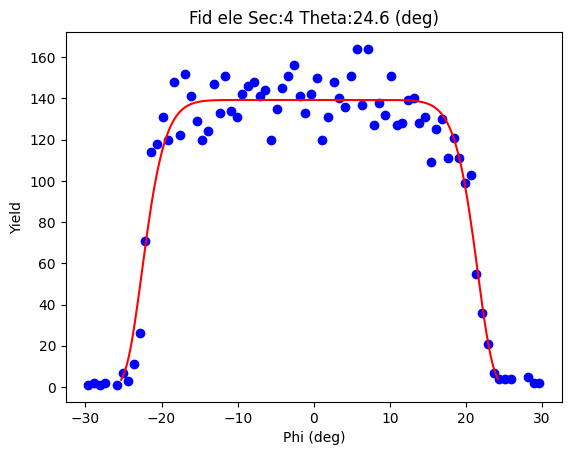

...........Theta: 25.8 ............
Binning| Sec: 3  Ybin: 21
Sum of plot 7959.0
Initial Bounds: [-25.77320787725716, 24.728144831466818]
Sum of initial fit area: 7935.0
max at  173.0
initial max 139.23713882677697
initial guesses: [173.0, -0.5225315228951698, 15.721267013506052, 11.999999999999998]
fit bounds [-25.77320787725716, 24.728144831466818]
(array([138.46195476,  -0.34465201,  15.90518534,  12.        ]), array([[ 3.38397693e+00,  5.01181643e-05, -3.94361040e-02,
        -8.27119452e-01],
       [ 5.01181643e-05,  2.14773671e-02,  8.87661678e-06,
        -1.55394197e-04],
       [-3.94361040e-02,  8.87661678e-06,  1.26547972e-02,
        -2.84526874e-02],
       [-8.27119452e-01, -1.55394197e-04, -2.84526874e-02,
         1.73220802e+00]]))
[138.46195476  -0.34465201  15.90518534  12.        ]
[138.46195476  -0.34465201  15.90518534  12.        ]
New Bounds for next fit: [-25.890728356215458, 25.201424331566773]


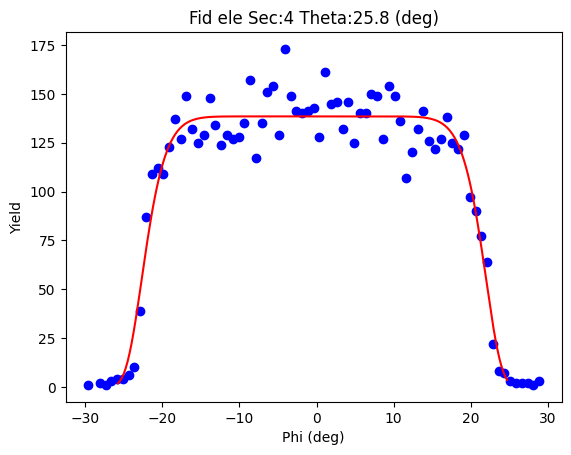

...........Theta: 27.0 ............
Binning| Sec: 3  Ybin: 22
Sum of plot 7516.0
Initial Bounds: [-25.890728356215458, 25.201424331566773]
Sum of initial fit area: 7496.0
max at  166.0
initial max 138.46195476283933
initial guesses: [166.0, -0.3446520123243415, 15.905185338940216, 11.999999999999998]
fit bounds [-25.890728356215458, 25.201424331566773]
(array([128.3109014 ,  -0.38870132,  16.22740269,  12.        ]), array([[ 5.03287159e+00, -1.90445022e-05, -6.52096445e-02,
        -1.31788177e+00],
       [-1.90445022e-05,  3.86726278e-02, -3.44130058e-06,
         6.21179786e-05],
       [-6.52096445e-02, -3.44130058e-06,  2.27158589e-02,
        -4.83386079e-02],
       [-1.31788177e+00,  6.21179786e-05, -4.83386079e-02,
         2.96740730e+00]]))
[128.3109014   -0.38870132  16.22740269  12.        ]
[128.3109014   -0.38870132  16.22740269  12.        ]
New Bounds for next fit: [-26.452306299498563, 25.67490366659879]


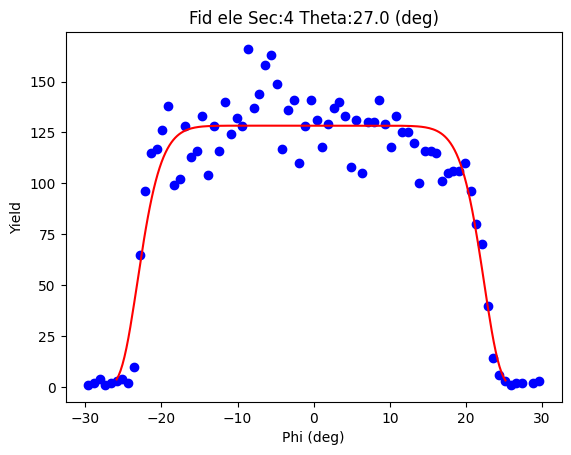

...........Theta: 28.2 ............
Binning| Sec: 3  Ybin: 23
Sum of plot 6810.0
Initial Bounds: [-26.452306299498563, 25.67490366659879]
Sum of initial fit area: 6792.0
max at  144.0
initial max 128.3109013958153
initial guesses: [144.0, -0.3887013164498844, 16.227402685087736, 11.999999999999998]
fit bounds [-26.452306299498563, 25.67490366659879]
(array([114.82075921,  -0.41076216,  16.43568783,  12.        ]), array([[ 3.41806948e+00, -8.91981656e-05, -4.93639167e-02,
        -1.01140320e+00],
       [-8.91981656e-05,  3.37127109e-02, -2.03431901e-05,
         3.37282139e-04],
       [-4.93639167e-02, -2.03431901e-05,  1.99000229e-02,
        -4.41405000e-02],
       [-1.01140320e+00,  3.37282139e-04, -4.41405000e-02,
         2.55959862e+00]]))
[114.82075921  -0.41076216  16.43568783  12.        ]
[114.82075921  -0.41076216  16.43568783  12.        ]
New Bounds for next fit: [-26.808903842395377, 25.98737952266733]


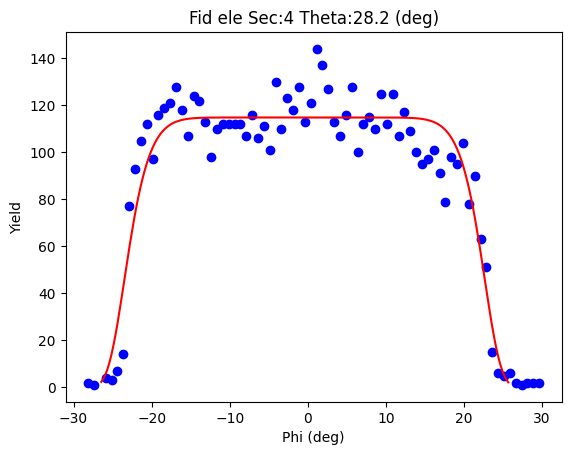

...........Theta: 29.4 ............
Binning| Sec: 3  Ybin: 24
Sum of plot 6364.0
Initial Bounds: [-26.808903842395377, 25.98737952266733]
Sum of initial fit area: 6357.0
max at  132.0
initial max 114.82075921369969
initial guesses: [132.0, -0.410762159864025, 16.4356878297934, 11.999999999999996]
fit bounds [-26.808903842395377, 25.98737952266733]
(array([107.13220145,  -0.44228749,  16.46813348,  12.        ]), array([[ 3.52120517e+00, -2.43212379e-05, -5.58034012e-02,
        -1.09885245e+00],
       [-2.43212379e-05,  3.99486649e-02, -4.83035404e-06,
         9.19106741e-05],
       [-5.58034012e-02, -4.83035404e-06,  2.34208065e-02,
        -4.79987459e-02],
       [-1.09885245e+00,  9.19106741e-05, -4.79987459e-02,
         2.95646996e+00]]))
[107.13220145  -0.44228749  16.46813348  12.        ]
[107.13220145  -0.44228749  16.46813348  12.        ]
New Bounds for next fit: [-26.892541666993424, 26.007966693339675]


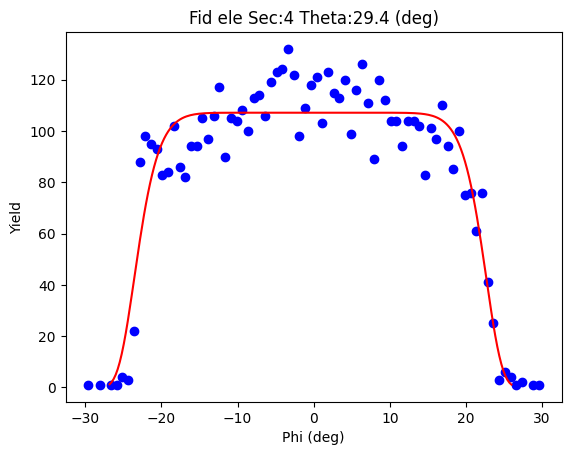

...........Theta: 30.6 ............
Binning| Sec: 3  Ybin: 25
Sum of plot 5792.0
Initial Bounds: [-26.892541666993424, 26.007966693339675]
Sum of initial fit area: 5785.0
max at  117.0
initial max 107.13220145322396
initial guesses: [117.0, -0.4422874868268748, 16.468133475151983, 11.999999999998725]
fit bounds [-26.892541666993424, 26.007966693339675]
(array([98.09829026, -0.41000711, 16.41980502, 10.91495435]), array([[ 3.04768653e+00, -2.74554486e-05, -5.78918900e-02,
        -9.37948426e-01],
       [-2.74554486e-05,  4.36922730e-02, -6.21592361e-06,
         9.59094059e-05],
       [-5.78918900e-02, -6.21592361e-06,  2.58231517e-02,
        -4.13779261e-02],
       [-9.37948426e-01,  9.59094059e-05, -4.13779261e-02,
         2.28335876e+00]]))
[98.09829026 -0.41000711 16.41980502 10.91495435]
[98.09829026 -0.41000711 16.41980502 10.91495435]
New Bounds for next fit: [-27.118406046771113, 26.298391831097362]


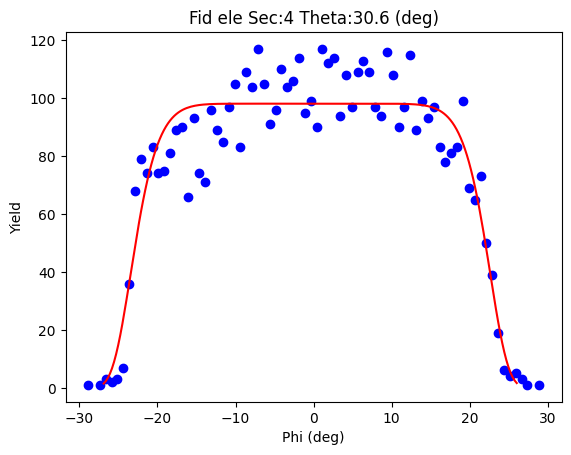

...........Theta: 31.8 ............
Binning| Sec: 3  Ybin: 26
Sum of plot 5198.0
Initial Bounds: [-27.118406046771113, 26.298391831097362]
Sum of initial fit area: 5189.0
max at  108.0
initial max 98.09829026359814
initial guesses: [108.0, -0.41000710783687444, 16.419805021005363, 10.914954351910742]
fit bounds [-27.118406046771113, 26.298391831097362]
(array([86.43594809, -0.2701838 , 16.66938644, 12.        ]), array([[ 2.15392647e+00,  8.29324767e-05, -4.25883585e-02,
        -8.36763456e-01],
       [ 8.29324767e-05,  3.84833113e-02,  2.26695534e-05,
        -4.00369114e-04],
       [-4.25883585e-02,  2.26695534e-05,  2.25996019e-02,
        -4.66920486e-02],
       [-8.36763456e-01, -4.00369114e-04, -4.66920486e-02,
         2.79611576e+00]]))
[86.43594809 -0.2701838  16.66938644 12.        ]
[86.43594809 -0.2701838  16.66938644 12.        ]
New Bounds for next fit: [-27.04367995281312, 26.50331235520394]


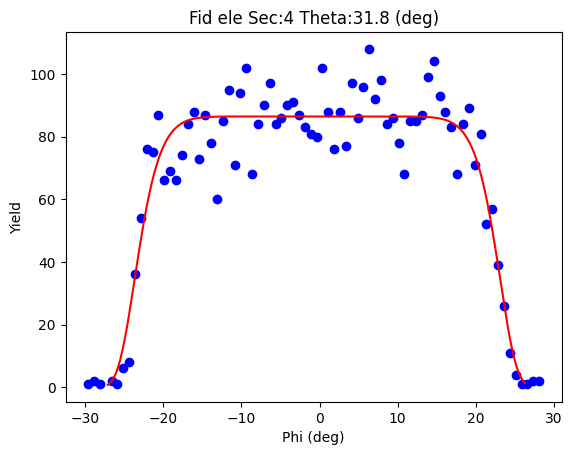

...........Theta: 33.0 ............
Binning| Sec: 3  Ybin: 27
Sum of plot 4388.0
Initial Bounds: [-27.04367995281312, 26.50331235520394]
Sum of initial fit area: 4384.0
max at  93.0
initial max 86.43594809227237
initial guesses: [93.0, -0.27018379880459265, 16.66938643604031, 11.999999999999991]
fit bounds [-27.04367995281312, 26.50331235520394]
(array([ 7.40248886e+01, -1.72153855e-02,  1.65867722e+01,  1.04345318e+01]), array([[ 2.24895613, -0.00716425, -0.04976926, -0.96013185],
       [-0.00716425,  0.06355746, -0.00438731,  0.0394188 ],
       [-0.04976926, -0.00438731,  0.04040174, -0.09999667],
       [-0.96013185,  0.0394188 , -0.09999667,  3.04597606]]))
[ 7.40248886e+01 -1.72153855e-02  1.65867722e+01  1.04345318e+01]
[ 7.40248886e+01 -1.72153855e-02  1.65867722e+01  1.04345318e+01]
New Bounds for next fit: [-27.171567874668238, 27.137137103696265]


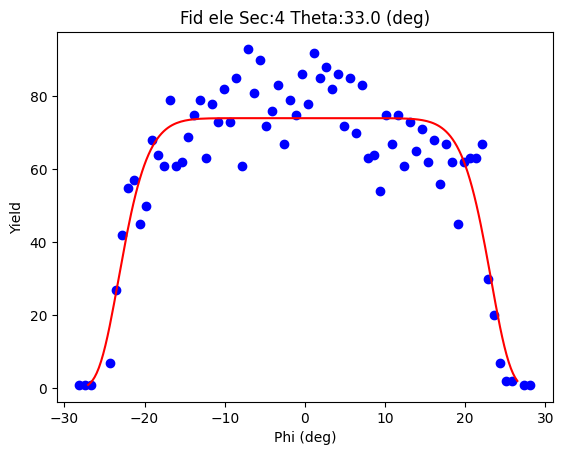

...........Theta: 34.2 ............
Binning| Sec: 3  Ybin: 28
Sum of plot 3682.0
Initial Bounds: [-27.171567874668238, 27.137137103696265]
Sum of initial fit area: 3680.0
max at  89.0
initial max 74.02488862956103
initial guesses: [89.0, -0.017215385485985234, 16.58677221929189, 10.434531764318523]
fit bounds [-27.171567874668238, 27.137137103696265]
(array([6.25303941e+01, 3.98280934e-02, 1.65776382e+01, 8.82944150e+00]), array([[ 1.63275746e+00, -1.39437681e-03, -5.80544752e-02,
        -6.47104540e-01],
       [-1.39437681e-03,  6.75313584e-02, -6.38504981e-04,
         5.53562369e-03],
       [-5.80544752e-02, -6.38504981e-04,  4.14847795e-02,
        -4.51261231e-02],
       [-6.47104540e-01,  5.53562369e-03, -4.51261231e-02,
         1.65617259e+00]]))
[6.25303941e+01 3.98280934e-02 1.65776382e+01 8.82944150e+00]
[6.25303941e+01 3.98280934e-02 1.65776382e+01 8.82944150e+00]
New Bounds for next fit: [-27.831339807640024, 27.910995994452907]


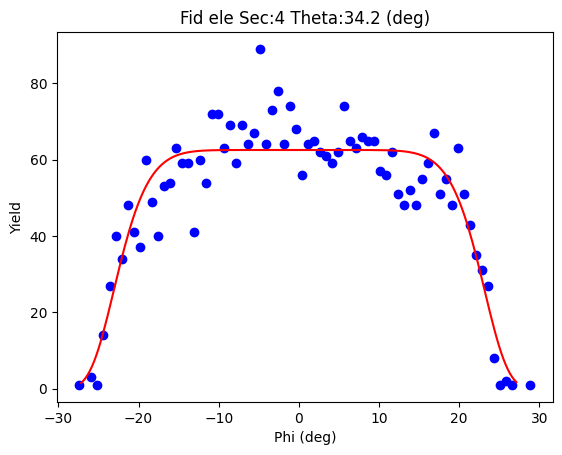

...........Theta: 35.4 ............
Binning| Sec: 3  Ybin: 29
Sum of plot 3109.0
Initial Bounds: [-27.831339807640024, 27.910995994452907]
Sum of initial fit area: 3109.0
max at  71.0
initial max 62.530394127420806
initial guesses: [71.0, 0.03982809340644169, 16.577638197525335, 8.829441504476808]
fit bounds [-27.831339807640024, 27.910995994452907]
(array([53.86494794, -0.27896008, 16.71039117,  6.59015108]), array([[ 2.02033783, -0.02583296, -0.07427792, -0.79092972],
       [-0.02583296,  0.15800873, -0.02698946,  0.0883711 ],
       [-0.07427792, -0.02698946,  0.11880365, -0.15660553],
       [-0.79092972,  0.0883711 , -0.15660553,  1.52653959]]))
[53.86494794 -0.27896008 16.71039117  6.59015108]
[53.86494794 -0.27896008 16.71039117  6.59015108]
New Bounds for next fit: [-30.073972340056304, 29.516052187732075]


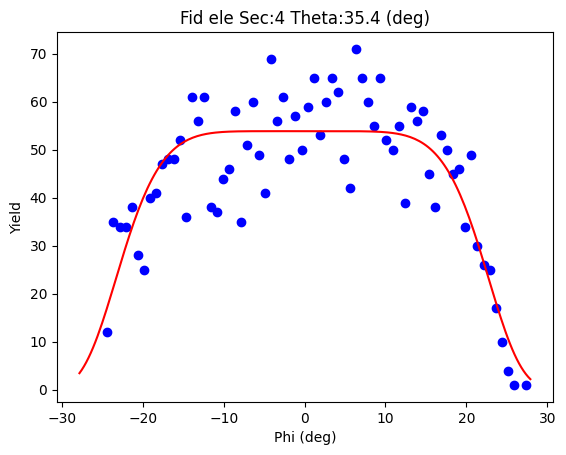

...........Theta: 36.6 ............
Binning| Sec: 3  Ybin: 30
Sum of plot 2586.0
Initial Bounds: [-30.073972340056304, 29.516052187732075]
Sum of initial fit area: 2586.0
max at  59.0
initial max 53.86494793717358
initial guesses: [59.0, -0.27896007616211566, 16.710391167970137, 6.590151077417278]
fit bounds [-30.073972340056304, 29.516052187732075]
(array([42.64041947,  0.16739147, 16.86365925, 12.        ]), array([[ 9.51303691e-01,  5.68945970e-03, -2.64827405e-02,
        -8.76022035e-01],
       [ 5.68945970e-03,  8.11014249e-02,  8.39239443e-03,
        -8.18539112e-02],
       [-2.64827405e-02,  8.39239443e-03,  5.49009662e-02,
        -2.33840029e-01],
       [-8.76022035e-01, -8.18539112e-02, -2.33840029e-01,
         6.71728340e+00]]))
[42.64041947  0.16739147 16.86365925 12.        ]
[42.64041947  0.16739147 16.86365925 12.        ]
New Bounds for next fit: [-26.918135507633437, 27.252918453980655]


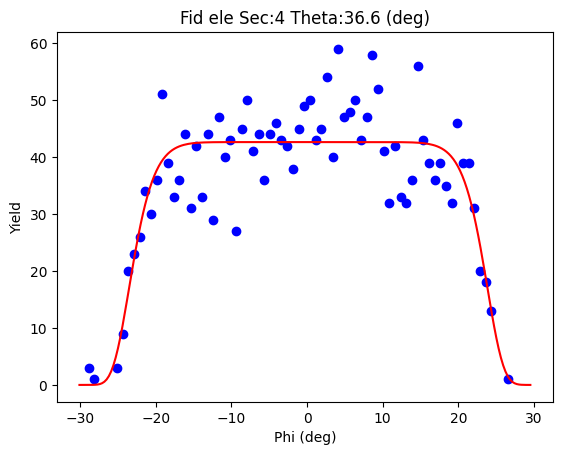

...........Theta: 37.8 ............
Binning| Sec: 3  Ybin: 31
Sum of plot 2007.0
Initial Bounds: [-26.918135507633437, 27.252918453980655]
Sum of initial fit area: 2003.0
max at  51.0
initial max 42.64041946874565
initial guesses: [51.0, 0.16739147317360772, 16.863659249784938, 11.999999999949589]
fit bounds [-26.918135507633437, 27.252918453980655]
(array([39.48018964,  0.6346876 , 16.76187333,  2.53936029]), array([[ 1.88986389,  0.02726686, -0.10381254, -0.41078646],
       [ 0.02726686,  0.2925111 ,  0.04186617, -0.02265142],
       [-0.10381254,  0.04186617,  0.46328457, -0.13321878],
       [-0.41078646, -0.02265142, -0.13321878,  0.20427109]]))
[39.48018964  0.6346876  16.76187333  2.53936029]
[39.48018964  0.6346876  16.76187333  2.53936029]
New Bounds for next fit: [-42.619054011743415, 43.88842921175822]


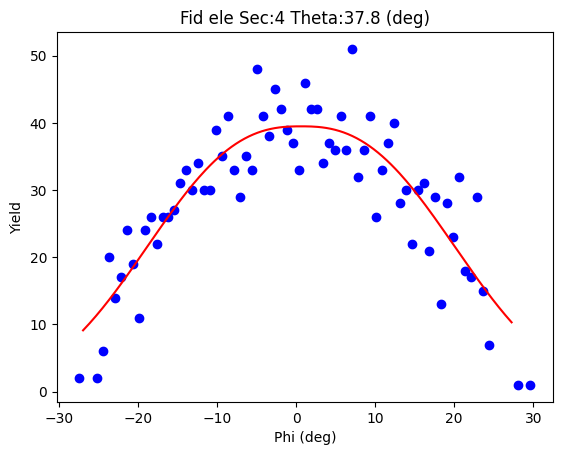

...........Theta: 39.0 ............
Binning| Sec: 3  Ybin: 32
Sum of plot 1506.0
Initial Bounds: [-42.619054011743415, 43.88842921175822]
Sum of initial fit area: 1506.0
max at  38.0
initial max 39.48018963816897
initial guesses: [38.0, 0.6346876000074022, 16.761873329950156, 2.539360286906211]
fit bounds [-42.619054011743415, 43.88842921175822]
(array([26.29546169, -0.17617829, 17.13509005,  5.27226787]), array([[ 0.73836661, -0.01433127, -0.00939762, -0.57512288],
       [-0.01433127,  0.29469687, -0.0420497 ,  0.07518849],
       [-0.00939762, -0.0420497 ,  0.34079537, -0.43856354],
       [-0.57512288,  0.07518849, -0.43856354,  1.73000786]]))
[26.29546169 -0.17617829 17.13509005  5.27226787]
[26.29546169 -0.17617829 17.13509005  5.27226787]
New Bounds for next fit: [-32.550473622817066, 32.19811704877348]


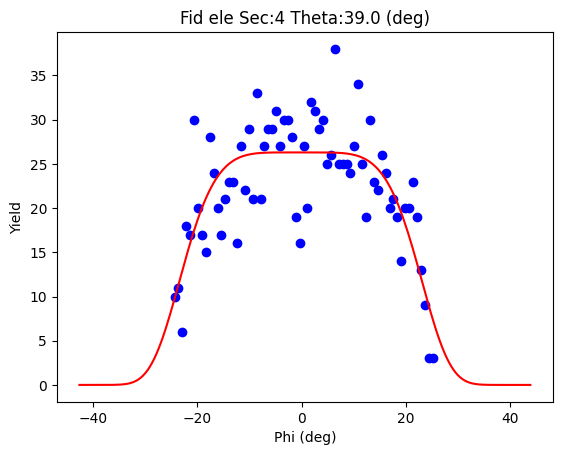

...........Theta: 40.2 ............
Binning| Sec: 3  Ybin: 33
Sum of plot 1025.0
Initial Bounds: [-32.550473622817066, 32.19811704877348]
Sum of initial fit area: 1025.0
max at  26.0
initial max 26.295461690749537
initial guesses: [26.0, -0.1761782870217893, 17.135090048450717, 5.2722678652733]
fit bounds [-32.550473622817066, 32.19811704877348]
(array([19.69837947,  1.47205812, 16.53298904,  3.01806942]), array([[ 0.55201023,  0.02079711, -0.08259703, -0.27257714],
       [ 0.02079711,  0.35860062,  0.06400443, -0.04737224],
       [-0.08259703,  0.06400443,  0.42727551, -0.14173503],
       [-0.27257714, -0.04737224, -0.14173503,  0.35166803]]))
[19.69837947  1.47205812 16.53298904  3.01806942]
[19.69837947  1.47205812 16.53298904  3.01806942]
New Bounds for next fit: [-37.30944479476783, 40.25356102546519]


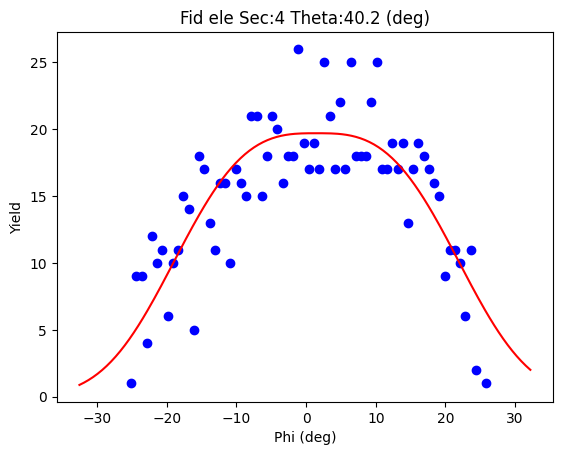

==========Sec  5 ===============
...........Theta: 10.2 ............
Binning| Sec: 4  Ybin: 8
Sum of plot 1151.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 974.0
max at  59.0
initial max 19.69837947024709
initial guesses: [59.0, 1.472058115348679, 16.53298903797202, 3.0180694233434804]
fit bounds [-10.0, 10.0]
(array([50.01380339,  2.77429455,  6.64054288,  2.95592069]), array([[ 5.81160194, -0.01896486, -0.29910285, -0.93314212],
       [-0.01896486,  0.21484554,  0.13326829, -0.07065392],
       [-0.29910285,  0.13326829,  0.19902718, -0.06013507],
       [-0.93314212, -0.07065392, -0.06013507,  0.43044323]]))
[50.01380339  2.77429455  6.64054288  2.95592069]
[50.01380339  2.77429455  6.64054288  2.95592069]
New Bounds for next fit: [-12.969060783910841, 18.51764989096269]


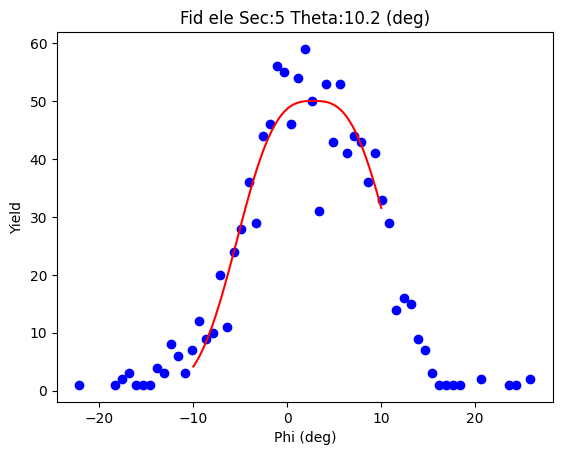

...........Theta: 11.4 ............
Binning| Sec: 4  Ybin: 9
Sum of plot 1585.0
Initial Bounds: [-12.969060783910841, 18.51764989096269]
Sum of initial fit area: 1549.0
max at  68.0
initial max 50.01380339255198
initial guesses: [68.0, 2.774294553525924, 6.640542877904834, 2.955920685707659]
fit bounds [-12.969060783910841, 18.51764989096269]
(array([55.03348294,  2.49740028,  8.05419836,  5.06211678]), array([[ 2.38648172e+00, -1.65166838e-04, -8.97335523e-02,
        -5.35583969e-01],
       [-1.65166838e-04,  3.84153118e-02, -2.03811909e-05,
         2.14884025e-04],
       [-8.97335523e-02, -2.03811909e-05,  2.56473004e-02,
         2.00421903e-03],
       [-5.35583969e-01,  2.14884025e-04,  2.00421903e-03,
         4.99635265e-01]]))
[55.03348294  2.49740028  8.05419836  5.06211678]
[55.03348294  2.49740028  8.05419836  5.06211678]
New Bounds for next fit: [-12.903947593124222, 17.898748145455702]


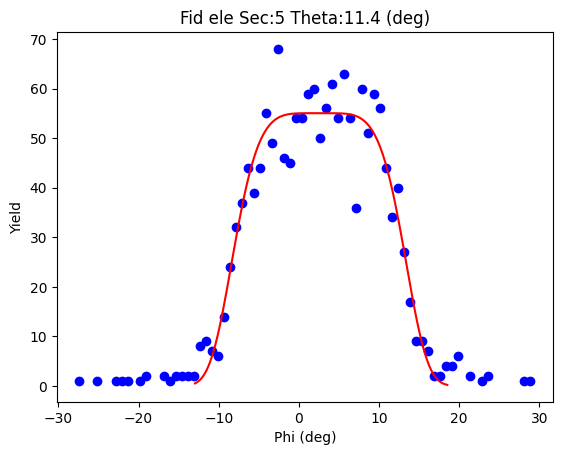

...........Theta: 12.6 ............
Binning| Sec: 4  Ybin: 10
Sum of plot 1530.0
Initial Bounds: [-12.903947593124222, 17.898748145455702]
Sum of initial fit area: 1474.0
max at  60.0
initial max 55.033482939546545
initial guesses: [60.0, 2.49740027616574, 8.054198358387115, 5.0621167761427035]
fit bounds [-12.903947593124222, 17.898748145455702]
(array([44.44937083,  1.90631553,  9.40771778,  7.29463976]), array([[ 1.70169249, -0.00559305, -0.05551291, -0.79050331],
       [-0.00559305,  0.05096696, -0.00230413,  0.02267054],
       [-0.05551291, -0.00230413,  0.03278447, -0.04690502],
       [-0.79050331,  0.02267054, -0.04690502,  2.00246273]]))
[44.44937083  1.90631553  9.40771778  7.29463976]
[44.44937083  1.90631553  9.40771778  7.29463976]
New Bounds for next fit: [-14.496621359199384, 18.3092524180131]


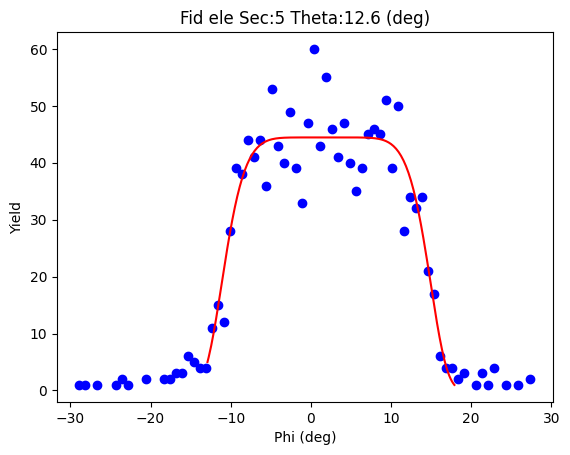

...........Theta: 13.8 ............
Binning| Sec: 4  Ybin: 11
Sum of plot 1292.0
Initial Bounds: [-14.496621359199384, 18.3092524180131]
Sum of initial fit area: 1230.0
max at  49.0
initial max 44.44937083471869
initial guesses: [49.0, 1.9063155294068566, 9.407717778326015, 7.294639764995781]
fit bounds [-14.496621359199384, 18.3092524180131]
(array([32.87726435,  1.85377136, 10.63116572,  8.03076354]), array([[ 1.55411695e+00, -6.67533176e-04, -4.61928049e-02,
        -1.27723934e+00],
       [-6.67533176e-04,  1.09547648e-01, -6.36598284e-04,
         5.16671540e-03],
       [-4.61928049e-02, -6.36598284e-04,  8.15701107e-02,
        -2.65911432e-01],
       [-1.27723934e+00,  5.16671540e-03, -2.65911432e-01,
         5.89734425e+00]]))
[32.87726435  1.85377136 10.63116572  8.03076354]
[32.87726435  1.85377136 10.63116572  8.03076354]
New Bounds for next fit: [-16.330001940159836, 20.037544664495496]


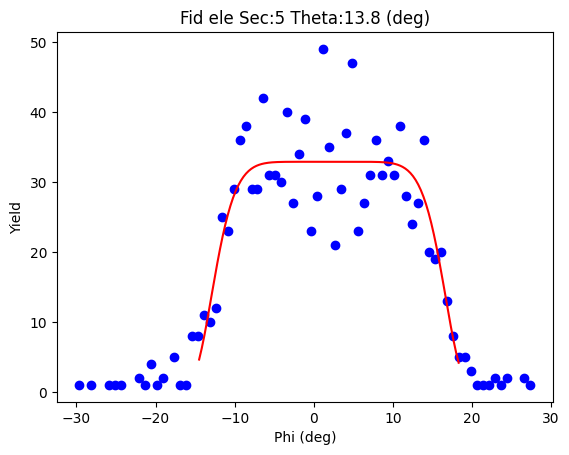

...........Theta: 15.0 ............
Binning| Sec: 4  Ybin: 12
Sum of plot 1990.0
Initial Bounds: [-16.330001940159836, 20.037544664495496]
Sum of initial fit area: 1948.0
max at  63.0
initial max 32.87726434728922
initial guesses: [63.0, 1.853771362167829, 10.631165716976344, 8.03076354306118]
fit bounds [-16.330001940159836, 20.037544664495496]
(array([48.42050346,  1.95219381, 11.16290616,  9.63227793]), array([[ 1.50259854e+00,  6.56435041e-05, -4.48154881e-02,
        -8.15220459e-01],
       [ 6.56435041e-05,  4.42334371e-02,  1.96261949e-05,
        -3.61265217e-04],
       [-4.48154881e-02,  1.96261949e-05,  2.64364518e-02,
        -4.31276653e-02],
       [-8.15220459e-01, -3.61265217e-04, -4.31276653e-02,
         3.13260495e+00]]))
[48.42050346  1.95219381 11.16290616  9.63227793]
[48.42050346  1.95219381 11.16290616  9.63227793]
New Bounds for next fit: [-16.546831568151966, 20.451219195636483]


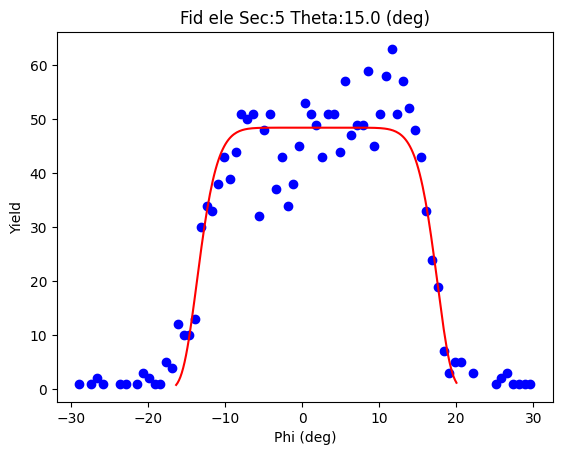

...........Theta: 16.2 ............
Binning| Sec: 4  Ybin: 13
Sum of plot 3203.0
Initial Bounds: [-16.546831568151966, 20.451219195636483]
Sum of initial fit area: 3110.0
max at  86.0
initial max 48.420503455479846
initial guesses: [86.0, 1.9521938137422576, 11.16290615569779, 9.632277932661573]
fit bounds [-16.546831568151966, 20.451219195636483]
(array([70.79848659,  1.66229673, 12.22618292, 12.        ]), array([[ 1.92570934e+00, -3.17130413e-03, -2.48184805e-02,
        -1.06389874e+00],
       [-3.17130413e-03,  2.95246369e-02, -1.45583186e-03,
         2.36214867e-02],
       [-2.48184805e-02, -1.45583186e-03,  1.94168861e-02,
        -1.06475301e-01],
       [-1.06389874e+00,  2.36214867e-02, -1.06475301e-01,
         4.79472994e+00]]))
[70.79848659  1.66229673 12.22618292 12.        ]
[70.79848659  1.66229673 12.22618292 12.        ]
New Bounds for next fit: [-17.974758459590745, 21.299351916226477]


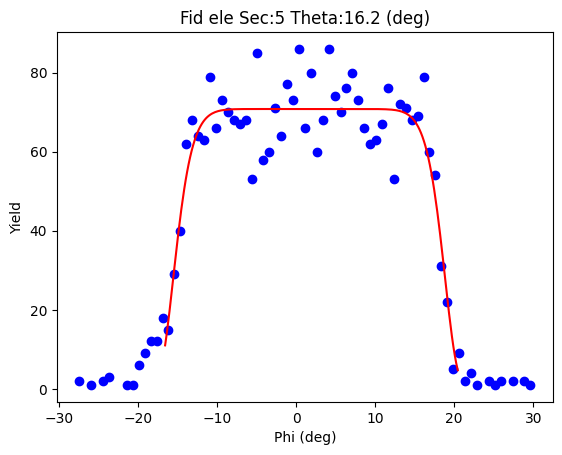

...........Theta: 17.4 ............
Binning| Sec: 4  Ybin: 14
Sum of plot 3829.0
Initial Bounds: [-17.974758459590745, 21.299351916226477]
Sum of initial fit area: 3731.0
max at  93.0
initial max 70.79848658583639
initial guesses: [93.0, 1.6622967283178665, 12.226182920234333, 11.999999999999982]
fit bounds [-17.974758459590745, 21.299351916226477]
(array([78.24228862,  0.97587946, 13.37563548, 12.        ]), array([[ 2.60481433, -0.0166124 , -0.01214156, -1.52648406],
       [-0.0166124 ,  0.05048166, -0.01327892,  0.14413808],
       [-0.01214156, -0.01327892,  0.0411602 , -0.3025017 ],
       [-1.52648406,  0.14413808, -0.3025017 ,  7.23342787]]))
[78.24228862  0.97587946 13.37563548 12.        ]
[78.24228862  0.97587946 13.37563548 12.        ]
New Bounds for next fit: [-20.507366280616193, 22.459125204522284]


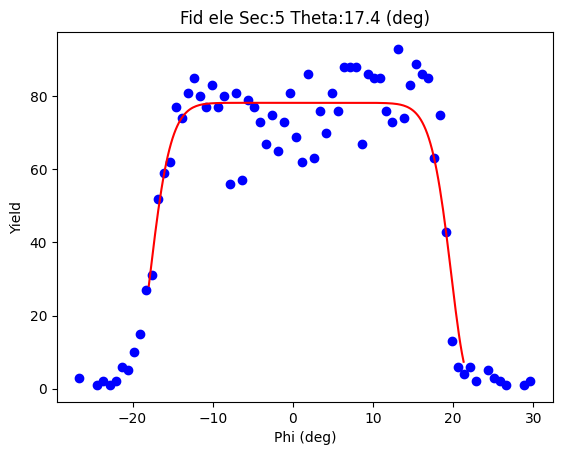

...........Theta: 18.6 ............
Binning| Sec: 4  Ybin: 15
Sum of plot 3862.0
Initial Bounds: [-20.507366280616193, 22.459125204522284]
Sum of initial fit area: 3811.0
max at  93.0
initial max 78.2422886245793
initial guesses: [93.0, 0.9758794619530452, 13.375635483813634, 11.999999999999998]
fit bounds [-20.507366280616193, 22.459125204522284]
(array([75.26253421,  0.5581792 , 14.08197956, 12.        ]), array([[ 2.48556694e+00, -7.73347711e-03, -3.71405287e-02,
        -1.25149330e+00],
       [-7.73347711e-03,  4.52725485e-02, -3.83382869e-03,
         5.40363564e-02],
       [-3.71405287e-02, -3.83382869e-03,  2.89760823e-02,
        -1.27882785e-01],
       [-1.25149330e+00,  5.40363564e-02, -1.27882785e-01,
         5.23896357e+00]]))
[75.26253421  0.5581792  14.08197956 12.        ]
[75.26253421  0.5581792  14.08197956 12.        ]
New Bounds for next fit: [-22.059559433130673, 23.17591783056062]


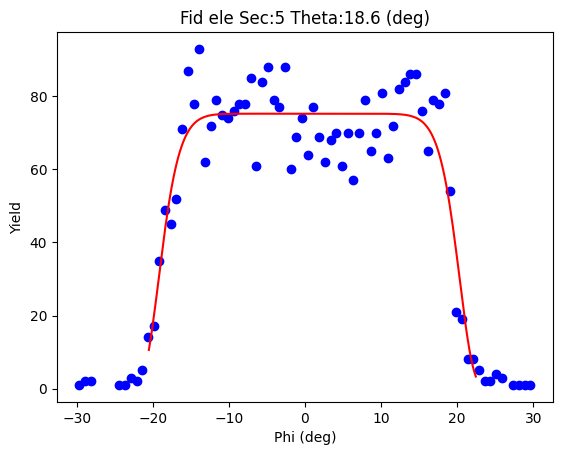

...........Theta: 19.8 ............
Binning| Sec: 4  Ybin: 16
Sum of plot 3737.0
Initial Bounds: [-22.059559433130673, 23.17591783056062]
Sum of initial fit area: 3709.0
max at  93.0
initial max 75.2625342088669
initial guesses: [93.0, 0.5581791987149725, 14.081979558995496, 11.999999999999995]
fit bounds [-22.059559433130673, 23.17591783056062]
(array([69.3670387 ,  0.30769501, 14.89629304, 12.        ]), array([[ 3.19386153e+00, -9.58215986e-03, -5.34067929e-02,
        -1.76681745e+00],
       [-9.58215986e-03,  7.62265066e-02, -5.49595739e-03,
         7.29171528e-02],
       [-5.34067929e-02, -5.49595739e-03,  4.93088478e-02,
        -2.11886338e-01],
       [-1.76681745e+00,  7.29171528e-02, -2.11886338e-01,
         8.06299461e+00]]))
[69.3670387   0.30769501 14.89629304 12.        ]
[69.3670387   0.30769501 14.89629304 12.        ]
New Bounds for next fit: [-23.617951323827786, 24.233341349843972]


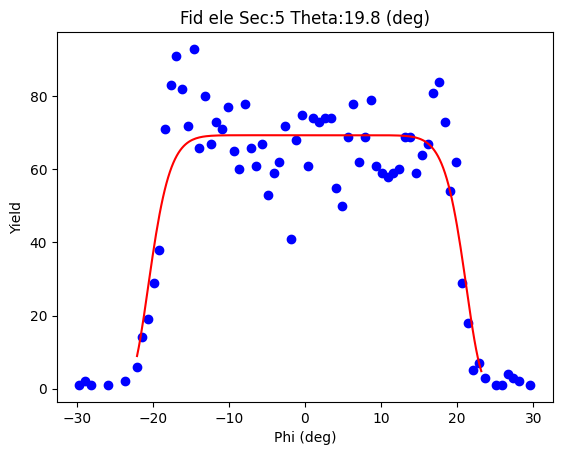

...........Theta: 21.0 ............
Binning| Sec: 4  Ybin: 17
Sum of plot 3852.0
Initial Bounds: [-23.617951323827786, 24.233341349843972]
Sum of initial fit area: 3822.0
max at  83.0
initial max 69.36703869964931
initial guesses: [83.0, 0.30769501300809343, 14.896293043933943, 11.999999999999998]
fit bounds [-23.617951323827786, 24.233341349843972]
(array([69.0953031 ,  0.32260201, 15.37910387, 12.        ]), array([[ 2.23656020e+00, -4.58106090e-04, -4.61704976e-02,
        -1.15713839e+00],
       [-4.58106090e-04,  5.41463549e-02, -2.07095520e-04,
         3.14305049e-03],
       [-4.61704976e-02, -2.07095520e-04,  3.29264291e-02,
        -9.97419940e-02],
       [-1.15713839e+00,  3.14305049e-03, -9.97419940e-02,
         5.01576447e+00]]))
[69.0953031   0.32260201 15.37910387 12.        ]
[69.0953031   0.32260201 15.37910387 12.        ]
New Bounds for next fit: [-24.378509801834387, 25.023713825581854]


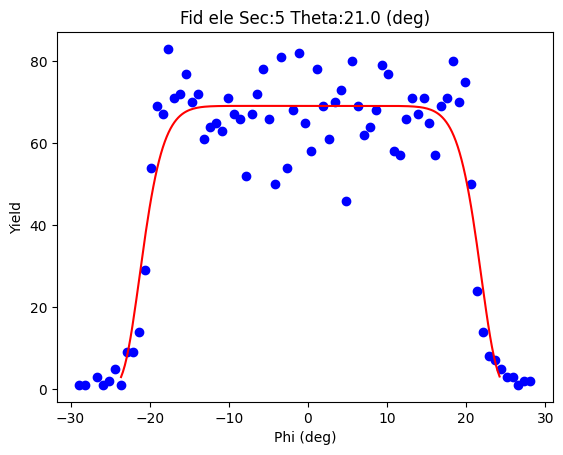

...........Theta: 22.2 ............
Binning| Sec: 4  Ybin: 18
Sum of plot 3841.0
Initial Bounds: [-24.378509801834387, 25.023713825581854]
Sum of initial fit area: 3811.0
max at  91.0
initial max 69.0953030976403
initial guesses: [91.0, 0.32260201187373455, 15.379103866526357, 11.999999999999998]
fit bounds [-24.378509801834387, 25.023713825581854]
(array([67.5636312 ,  0.09263739, 15.69070036, 12.        ]), array([[ 2.40460595e+00,  2.44923103e-04, -5.65074879e-02,
        -1.20668266e+00],
       [ 2.44923103e-04,  6.24036733e-02,  8.89584354e-05,
        -1.56387217e-03],
       [-5.65074879e-02,  8.89584354e-05,  3.68004391e-02,
        -8.46432268e-02],
       [-1.20668266e+00, -1.56387217e-03, -8.46432268e-02,
         5.18408236e+00]]))
[67.5636312   0.09263739 15.69070036 12.        ]
[67.5636312   0.09263739 15.69070036 12.        ]
New Bounds for next fit: [-25.108944409454207, 25.29421919204356]


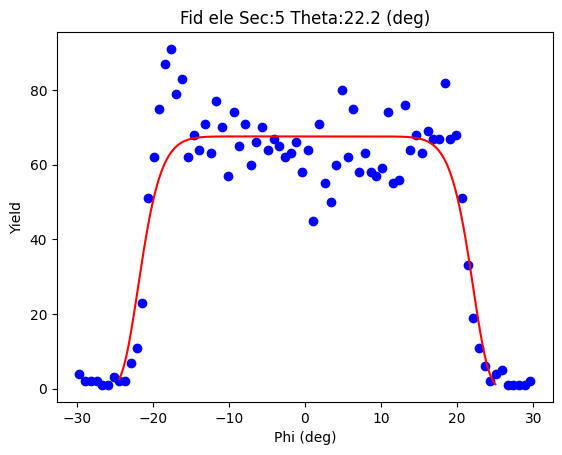

...........Theta: 23.4 ............
Binning| Sec: 4  Ybin: 19
Sum of plot 3771.0
Initial Bounds: [-25.108944409454207, 25.29421919204356]
Sum of initial fit area: 3758.0
max at  88.0
initial max 67.56363120303027
initial guesses: [88.0, 0.09263739129467757, 15.690700363511063, 11.999999999999998]
fit bounds [-25.108944409454207, 25.29421919204356]
(array([65.38254523, -0.13657012, 16.01437761, 12.        ]), array([[ 2.95424490e+00, -2.67881559e-03, -7.10009281e-02,
        -1.56132208e+00],
       [-2.67881559e-03,  8.59076747e-02, -1.16556715e-03,
         1.84771990e-02],
       [-7.10009281e-02, -1.16556715e-03,  5.12024497e-02,
        -1.28111294e-01],
       [-1.56132208e+00,  1.84771990e-02, -1.28111294e-01,
         7.01604993e+00]]))
[65.38254523 -0.13657012 16.01437761 12.        ]
[65.38254523 -0.13657012 16.01437761 12.        ]
New Bounds for next fit: [-25.85802538353449, 25.584885142265072]


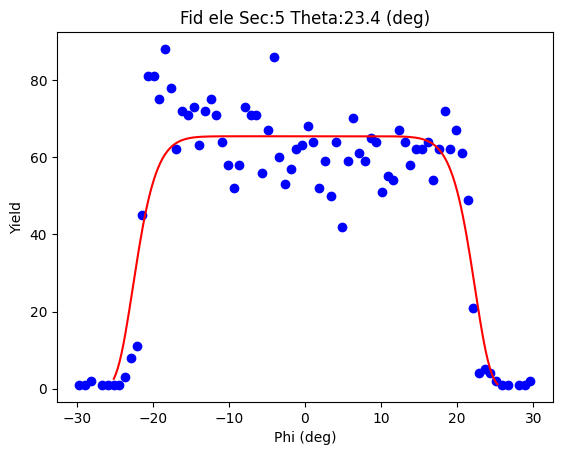

...........Theta: 24.6 ............
Binning| Sec: 4  Ybin: 20
Sum of plot 3744.0
Initial Bounds: [-25.85802538353449, 25.584885142265072]
Sum of initial fit area: 3728.0
max at  89.0
initial max 65.38254523198431
initial guesses: [89.0, -0.13657012063470858, 16.014377614647277, 11.999999999999998]
fit bounds [-25.85802538353449, 25.584885142265072]
(array([6.34417460e+01, 3.63636691e-02, 1.63648363e+01, 1.20000000e+01]), array([[ 2.91100164e+00,  2.43678949e-04, -7.39777394e-02,
        -1.58382766e+00],
       [ 2.43678949e-04,  9.35933092e-02,  1.10340064e-04,
        -1.72558198e-03],
       [-7.39777394e-02,  1.10340064e-04,  5.56942122e-02,
        -1.34177608e-01],
       [-1.58382766e+00, -1.72558198e-03, -1.34177608e-01,
         7.31914060e+00]]))
[6.34417460e+01 3.63636691e-02 1.63648363e+01 1.20000000e+01]
[6.34417460e+01 3.63636691e-02 1.63648363e+01 1.20000000e+01]
New Bounds for next fit: [-26.24798000399245, 26.32070734222768]


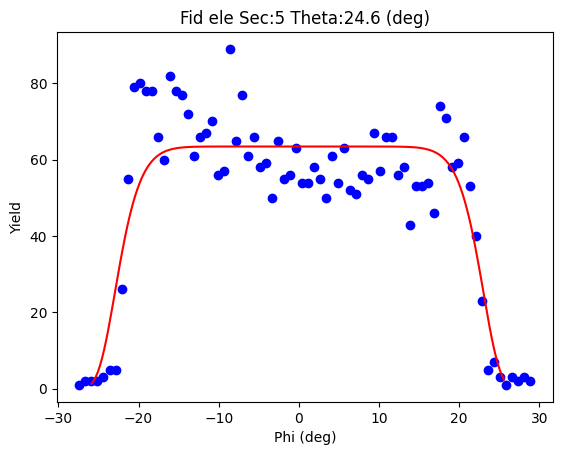

...........Theta: 25.8 ............
Binning| Sec: 4  Ybin: 21
Sum of plot 4046.0
Initial Bounds: [-26.24798000399245, 26.32070734222768]
Sum of initial fit area: 4036.0
max at  102.0
initial max 63.44174600560357
initial guesses: [102.0, 0.03636366911761542, 16.364836306190213, 11.999999999999998]
fit bounds [-26.24798000399245, 26.32070734222768]
(array([ 6.75762478e+01, -9.35770433e-03,  1.67183272e+01,  1.20000000e+01]), array([[ 3.19483626e+00, -8.19720181e-03, -6.16168854e-02,
        -1.79365048e+00],
       [-8.19720181e-03,  1.07271818e-01, -1.10655919e-02,
         8.98392384e-02],
       [-6.16168854e-02, -1.10655919e-02,  7.06862705e-02,
        -2.74298669e-01],
       [-1.79365048e+00,  8.98392384e-02, -2.74298669e-01,
         8.50314775e+00]]))
[ 6.75762478e+01 -9.35770433e-03  1.67183272e+01  1.20000000e+01]
[ 6.75762478e+01 -9.35770433e-03  1.67183272e+01  1.20000000e+01]
New Bounds for next fit: [-26.86146001184855, 26.842744603181927]


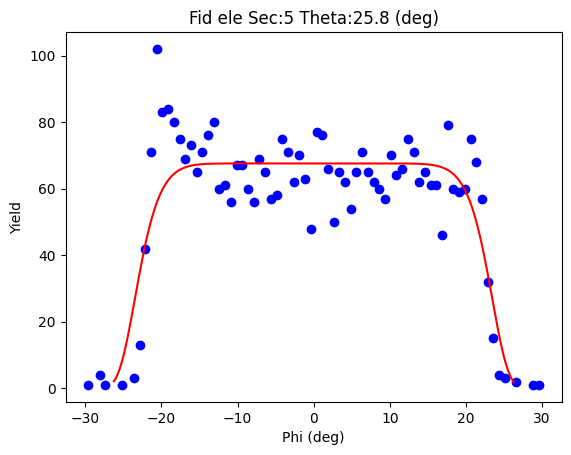

...........Theta: 27.0 ............
Binning| Sec: 4  Ybin: 22
Sum of plot 3970.0
Initial Bounds: [-26.86146001184855, 26.842744603181927]
Sum of initial fit area: 3962.0
max at  87.0
initial max 67.57624775390735
initial guesses: [87.0, -0.0093577043333101, 16.71832723710404, 11.999999999999998]
fit bounds [-26.86146001184855, 26.842744603181927]
(array([65.75326658, -0.18400799, 16.75152982, 12.        ]), array([[ 2.35178452e+00, -1.01548385e-04, -6.16786501e-02,
        -1.19718178e+00],
       [-1.01548385e-04,  7.32983347e-02, -3.45293897e-05,
         6.31840062e-04],
       [-6.16786501e-02, -3.45293897e-05,  4.29919861e-02,
        -8.70917530e-02],
       [-1.19718178e+00,  6.31840062e-04, -8.70917530e-02,
         5.25093045e+00]]))
[65.75326658 -0.18400799 16.75152982 12.        ]
[65.75326658 -0.18400799 16.75152982 12.        ]
New Bounds for next fit: [-27.089438553243387, 26.72142257837201]


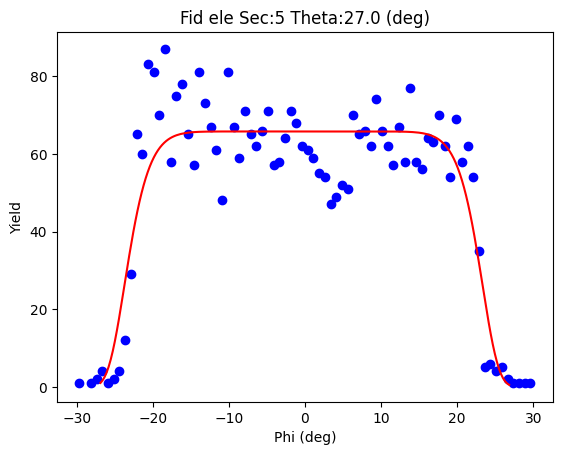

...........Theta: 28.2 ............
Binning| Sec: 4  Ybin: 23
Sum of plot 3708.0
Initial Bounds: [-27.089438553243387, 26.72142257837201]
Sum of initial fit area: 3691.0
max at  80.0
initial max 65.75326658485962
initial guesses: [80.0, -0.18400798743568939, 16.751529824480922, 11.999999999999998]
fit bounds [-27.089438553243387, 26.72142257837201]
(array([60.05886066, -0.09954854, 17.1261048 , 12.        ]), array([[ 2.71596754e+00, -3.50488873e-04, -7.82629994e-02,
        -1.53464208e+00],
       [-3.50488873e-04,  1.06289849e-01, -1.58165533e-04,
         2.52777698e-03],
       [-7.82629994e-02, -1.58165533e-04,  6.27092342e-02,
        -1.32774716e-01],
       [-1.53464208e+00,  2.52777698e-03, -1.32774716e-01,
         7.42073887e+00]]))
[60.05886066 -0.09954854 17.1261048  12.        ]
[60.05886066 -0.09954854 17.1261048  12.        ]
New Bounds for next fit: [-27.606601827881683, 27.407504740695757]


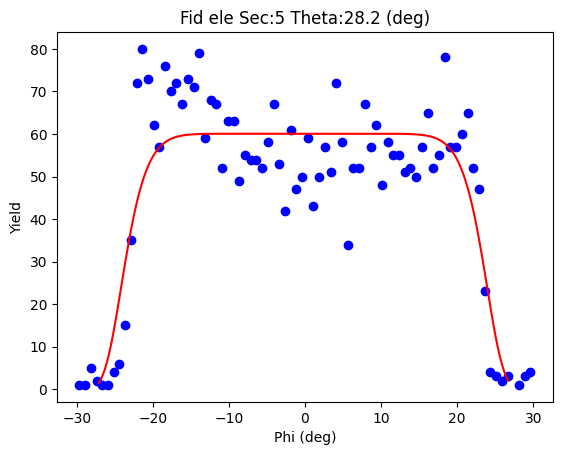

...........Theta: 29.4 ............
Binning| Sec: 4  Ybin: 24
Sum of plot 3104.0
Initial Bounds: [-27.606601827881683, 27.407504740695757]
Sum of initial fit area: 3098.0
max at  72.0
initial max 60.058860662393464
initial guesses: [72.0, -0.0995485435929648, 17.12610479688548, 11.999999999999998]
fit bounds [-27.606601827881683, 27.407504740695757]
(array([49.59103404,  0.11310061, 17.52476689, 12.        ]), array([[ 2.69899852e+00, -1.74200448e-03, -9.39514508e-02,
        -1.87683244e+00],
       [-1.74200448e-03,  1.81886320e-01,  1.50406047e-02,
        -5.05994364e-02],
       [-9.39514508e-02,  1.50406047e-02,  1.10822102e-01,
        -2.75524781e-01],
       [-1.87683244e+00, -5.05994364e-02, -2.75524781e-01,
         1.13321220e+01]]))
[49.59103404  0.11310061 17.52476689 12.        ]
[49.59103404  0.11310061 17.52476689 12.        ]
New Bounds for next fit: [-28.034262864032677, 28.260464081071177]


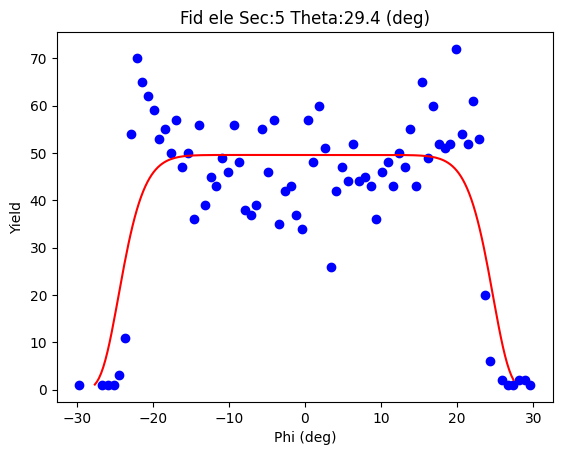

...........Theta: 30.6 ............
Binning| Sec: 4  Ybin: 25
Sum of plot 2773.0
Initial Bounds: [-28.034262864032677, 28.260464081071177]
Sum of initial fit area: 2769.0
max at  69.0
initial max 49.59103404023566
initial guesses: [69.0, 0.11310060851925048, 17.524766888145273, 11.999999999999998]
fit bounds [-28.034262864032677, 28.260464081071177]
(array([43.84701155, -0.14932223, 17.63189141, 12.        ]), array([[ 2.18353128e+00,  5.12863962e-03, -8.20088893e-02,
        -1.75801024e+00],
       [ 5.12863962e-03,  1.75272483e-01,  5.68641083e-03,
        -6.28007713e-02],
       [-8.20088893e-02,  5.68641083e-03,  1.06766337e-01,
        -2.82947152e-01],
       [-1.75801024e+00, -6.28007713e-02, -2.82947152e-01,
         1.20363902e+01]]))
[43.84701155 -0.14932223 17.63189141 12.        ]
[43.84701155 -0.14932223 17.63189141 12.        ]
New Bounds for next fit: [-28.468743507836976, 28.170099050072693]


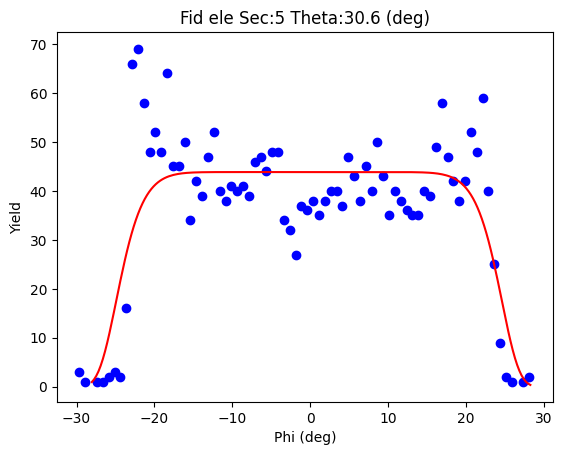

...........Theta: 31.8 ............
Binning| Sec: 4  Ybin: 26
Sum of plot 2388.0
Initial Bounds: [-28.468743507836976, 28.170099050072693]
Sum of initial fit area: 2387.0
max at  60.0
initial max 43.847011546618376
initial guesses: [60.0, -0.1493222288821401, 17.6318914133761, 11.999999999999998]
fit bounds [-28.468743507836976, 28.170099050072693]
(array([3.81180386e+01, 1.59724002e-02, 1.74357159e+01, 1.20000000e+01]), array([[ 1.42803909e+00,  6.14292399e-03, -6.03616994e-02,
        -1.33231870e+00],
       [ 6.14292399e-03,  1.48359150e-01,  6.15040835e-03,
        -7.85346547e-02],
       [-6.03616994e-02,  6.15040835e-03,  9.03931725e-02,
        -2.47303797e-01],
       [-1.33231870e+00, -7.85346547e-02, -2.47303797e-01,
         1.05197749e+01]]))
[3.81180386e+01 1.59724002e-02 1.74357159e+01 1.20000000e+01]
[3.81180386e+01 1.59724002e-02 1.74357159e+01 1.20000000e+01]
New Bounds for next fit: [-27.988362027838566, 28.020306828246657]


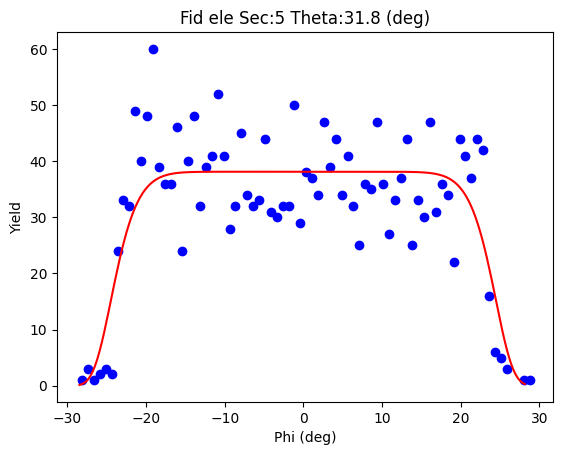

...........Theta: 33.0 ............
Binning| Sec: 4  Ybin: 27
Sum of plot 1858.0
Initial Bounds: [-27.988362027838566, 28.020306828246657]
Sum of initial fit area: 1856.0
max at  53.0
initial max 38.118038583307474
initial guesses: [53.0, 0.015972400204044154, 17.435715895298138, 11.999999999999998]
fit bounds [-27.988362027838566, 28.020306828246657]
(array([29.57906539, -0.13766748, 17.64914483, 12.        ]), array([[ 1.19831136e+00,  5.46150616e-03, -3.58619587e-02,
        -1.70096563e+00],
       [ 5.46150616e-03,  2.70294300e-01,  4.14272822e-02,
        -2.34914340e-01],
       [-3.58619587e-02,  4.14272822e-02,  2.10977812e-01,
        -1.02284976e+00],
       [-1.70096563e+00, -2.34914340e-01, -1.02284976e+00,
         2.04147196e+01]]))
[29.57906539 -0.13766748 17.64914483 12.        ]
[29.57906539 -0.13766748 17.64914483 12.        ]
New Bounds for next fit: [-28.484800292487947, 28.209465336035237]


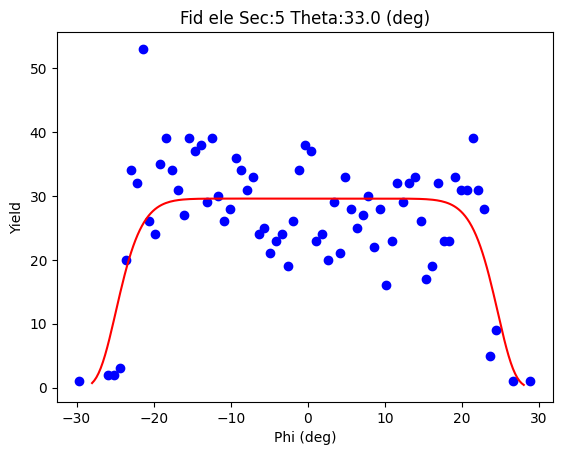

...........Theta: 34.2 ............
Binning| Sec: 4  Ybin: 28
Sum of plot 1458.0
Initial Bounds: [-28.484800292487947, 28.209465336035237]
Sum of initial fit area: 1455.0
max at  41.0
initial max 29.579065390656794
initial guesses: [41.0, -0.13766747822635436, 17.64914483026671, 11.999999999999998]
fit bounds [-28.484800292487947, 28.209465336035237]
(array([22.83352535, -0.79253307, 17.70306781, 12.        ]), array([[ 6.93961173e-01, -9.10298732e-03, -4.52775976e-02,
        -1.12412734e+00],
       [-9.10298732e-03,  2.15954469e-01, -1.81014702e-02,
         2.06700868e-01],
       [-4.52775976e-02, -1.81014702e-02,  1.35725985e-01,
        -4.42911779e-01],
       [-1.12412734e+00,  2.06700868e-01, -4.42911779e-01,
         1.53119158e+01]]))
[22.83352535 -0.79253307 17.70306781 12.        ]
[22.83352535 -0.79253307 17.70306781 12.        ]
New Bounds for next fit: [-29.226274156326138, 27.641208018767426]


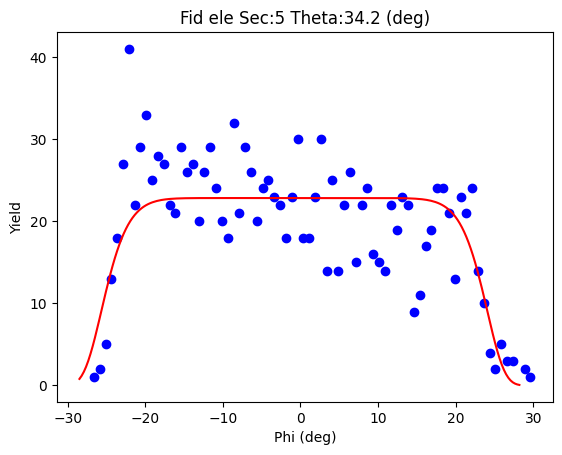

...........Theta: 35.4 ............
Binning| Sec: 4  Ybin: 29
Sum of plot 1226.0
Initial Bounds: [-29.226274156326138, 27.641208018767426]
Sum of initial fit area: 1223.0
max at  30.0
initial max 22.83352534559129
initial guesses: [30.0, -0.7925330687793561, 17.70306781319148, 11.999999999999998]
fit bounds [-29.226274156326138, 27.641208018767426]
(array([19.10615874, -0.60909896, 18.04993266, 12.        ]), array([[ 3.41660603e-01,  6.33396478e-04, -1.59801166e-02,
        -7.48818807e-01],
       [ 6.33396478e-04,  2.18796029e-01, -3.34780495e-02,
         1.13215734e-01],
       [-1.59801166e-02, -3.34780495e-02,  1.79005002e-01,
        -8.25246096e-01],
       [-7.48818807e-01,  1.13215734e-01, -8.25246096e-01,
         1.43394111e+01]]))
[19.10615874 -0.60909896 18.04993266 12.        ]
[19.10615874 -0.60909896 18.04993266 12.        ]
New Bounds for next fit: [-29.599956215934945, 28.38175829008575]


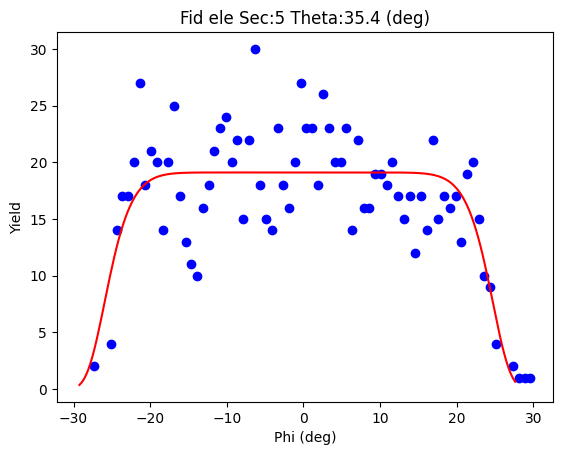

...........Theta: 36.6 ............
Binning| Sec: 4  Ybin: 30
Sum of plot 1150.0
Initial Bounds: [-29.599956215934945, 28.38175829008575]
Sum of initial fit area: 1147.0
max at  32.0
initial max 19.106158744855197
initial guesses: [32.0, -0.6090989629245972, 18.04993266036934, 11.999999999999998]
fit bounds [-29.599956215934945, 28.38175829008575]
(array([21.26901566, -0.06055153, 17.23837547,  2.84125492]), array([[ 1.01218441, -0.03684081, -0.17029424, -0.42497606],
       [-0.03684081,  0.59041134, -0.09456213,  0.0658233 ],
       [-0.17029424, -0.09456213,  0.70578973, -0.18191621],
       [-0.42497606,  0.0658233 , -0.18191621,  0.44718548]]))
[21.26901566 -0.06055153 17.23837547  2.84125492]
[21.26901566 -0.06055153 17.23837547  2.84125492]
New Bounds for next fit: [-41.79026458942514, 41.6691615236466]


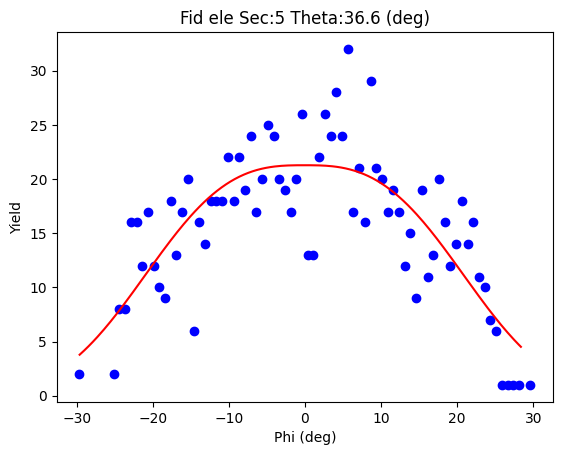

...........Theta: 37.8 ............
Binning| Sec: 4  Ybin: 31
Sum of plot 1001.0
Initial Bounds: [-41.79026458942514, 41.6691615236466]
Sum of initial fit area: 1001.0
max at  23.0
initial max 21.26901565548135
initial guesses: [23.0, -0.060551532889269205, 17.238375466103, 2.841254916744822]
fit bounds [-41.79026458942514, 41.6691615236466]
(array([15.94491845,  0.06200364, 17.52721911, 12.        ]), array([[ 2.95849694e-01,  7.16399403e-03, -1.89552551e-02,
        -7.65683671e-01],
       [ 7.16399403e-03,  2.03053645e-01,  2.71746362e-02,
        -2.64407012e-01],
       [-1.89552551e-02,  2.71746362e-02,  1.45004411e-01,
        -6.75974625e-01],
       [-7.65683671e-01, -2.64407012e-01, -6.75974625e-01,
         1.62928038e+01]]))
[15.94491845  0.06200364 17.52721911 12.        ]
[15.94491845  0.06200364 17.52721911 12.        ]
New Bounds for next fit: [-28.089298453220724, 28.21330573750871]


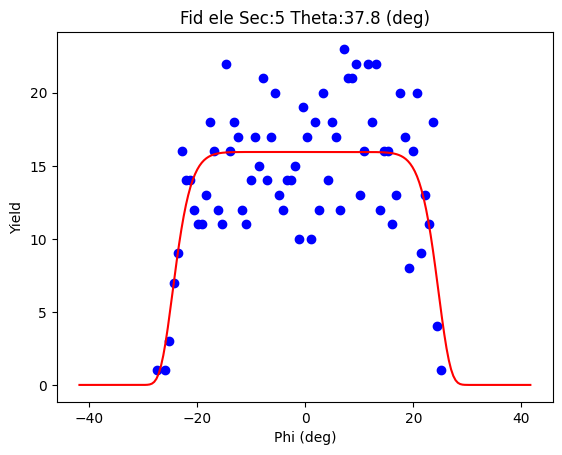

==========Sec  6 ===============
...........Theta: 9.0 ............
Binning| Sec: 5  Ybin: 7
Sum of plot 1141.0
Initial Bounds: [-10.0, 10.0]
Sum of initial fit area: 1050.0
max at  64.0
initial max 15.944918446855002
initial guesses: [64.0, 0.06200364214399158, 17.527219105267555, 11.999999999999998]
fit bounds [-10.0, 10.0]
(array([59.42291816,  1.42686153,  5.47762353,  2.84001979]), array([[ 5.65482679e+00,  3.18931205e-02, -1.91234214e-01,
        -6.85557291e-01],
       [ 3.18931205e-02,  4.37174020e-02,  7.20930851e-03,
        -1.85188408e-02],
       [-1.91234214e-01,  7.20930851e-03,  4.04312401e-02,
        -3.53271448e-03],
       [-6.85557291e-01, -1.85188408e-02, -3.53271448e-03,
         2.21758268e-01]]))
[59.42291816  1.42686153  5.47762353  2.84001979]
[59.42291816  1.42686153  5.47762353  2.84001979]
New Bounds for next fit: [-11.836168805657728, 14.689891869384315]


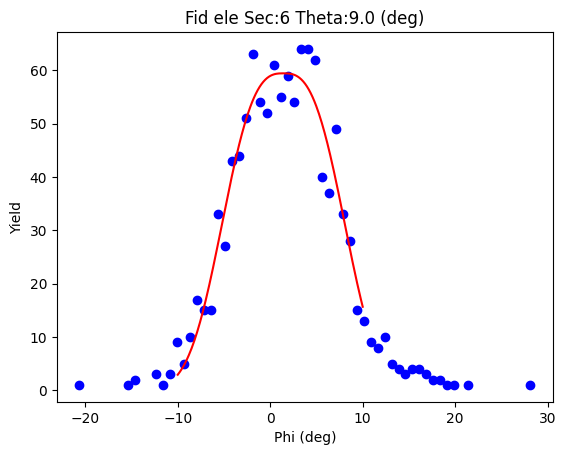

...........Theta: 10.2 ............
Binning| Sec: 5  Ybin: 8
Sum of plot 1996.0
Initial Bounds: [-11.836168805657728, 14.689891869384315]
Sum of initial fit area: 1937.0
max at  88.0
initial max 59.42291815813498
initial guesses: [88.0, 1.4268615318632945, 5.4776235257362975, 2.840019794533369]
fit bounds [-11.836168805657728, 14.689891869384315]
(array([78.61355013,  1.11266998,  7.3523283 ,  3.35016   ]), array([[ 6.89149742e+00, -6.46297630e-03, -2.26247545e-01,
        -7.27333759e-01],
       [-6.46297630e-03,  4.87180672e-02, -8.00905327e-04,
         3.14627839e-03],
       [-2.26247545e-01, -8.00905327e-04,  3.95286480e-02,
         5.89657769e-03],
       [-7.27333759e-01,  3.14627839e-03,  5.89657769e-03,
         2.25458397e-01]]))
[78.61355013  1.11266998  7.3523283   3.35016   ]
[78.61355013  1.11266998  7.3523283   3.35016   ]
New Bounds for next fit: [-15.289987658796916, 17.51532762576887]


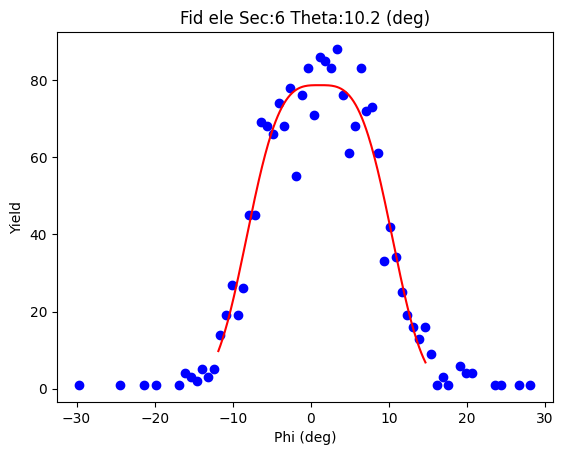

...........Theta: 11.4 ............
Binning| Sec: 5  Ybin: 9
Sum of plot 2739.0
Initial Bounds: [-15.289987658796916, 17.51532762576887]
Sum of initial fit area: 2688.0
max at  103.0
initial max 78.61355013226144
initial guesses: [103.0, 1.1126699834859768, 7.352328303432386, 3.350159995254316]
fit bounds [-15.289987658796916, 17.51532762576887]
(array([88.99493414,  0.69162238,  8.68205402,  5.07245532]), array([[ 4.32522540e+00, -8.00264739e-04, -1.06855514e-01,
        -6.09308416e-01],
       [-8.00264739e-04,  3.09154561e-02, -8.10446793e-05,
         6.80174196e-04],
       [-1.06855514e-01, -8.10446793e-05,  2.06815407e-02,
         5.51013710e-04],
       [-6.09308416e-01,  6.80174196e-04,  5.51013710e-04,
         3.55318301e-01]]))
[88.99493414  0.69162238  8.68205402  5.07245532]
[88.99493414  0.69162238  8.68205402  5.07245532]
New Bounds for next fit: [-15.900114385500402, 17.28335914572778]


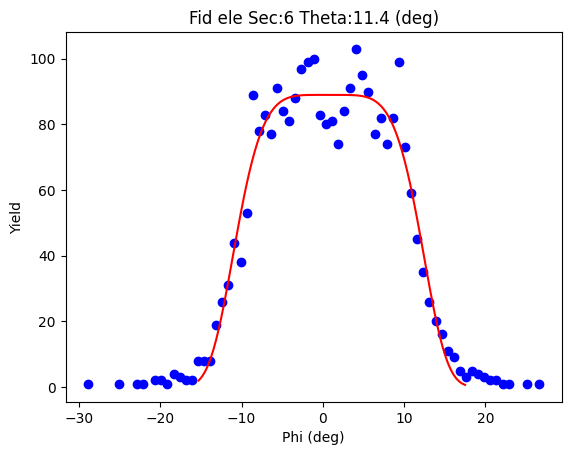

...........Theta: 12.6 ............
Binning| Sec: 5  Ybin: 10
Sum of plot 3192.0
Initial Bounds: [-15.900114385500402, 17.28335914572778]
Sum of initial fit area: 3116.0
max at  104.0
initial max 88.99493413652102
initial guesses: [104.0, 0.6916223801136887, 8.682054024837326, 5.072455316234331]
fit bounds [-15.900114385500402, 17.28335914572778]
(array([89.95690875,  0.44875285,  9.99723982,  5.6131325 ]), array([[ 4.58092432e+00, -4.36437413e-03, -1.00223744e-01,
        -7.98155288e-01],
       [-4.36437413e-03,  4.19618846e-02, -9.07487127e-04,
         5.27942006e-03],
       [-1.00223744e-01, -9.07487127e-04,  2.86838235e-02,
        -1.85779470e-02],
       [-7.98155288e-01,  5.27942006e-03, -1.85779470e-02,
         6.02233712e-01]]))
[89.95690875  0.44875285  9.99723982  5.6131325 ]
[89.95690875  0.44875285  9.99723982  5.6131325 ]
New Bounds for next fit: [-18.110254450721612, 19.007760155345032]


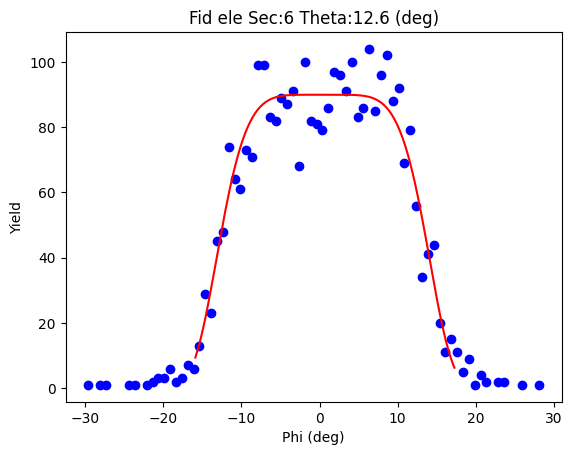

...........Theta: 13.8 ............
Binning| Sec: 5  Ybin: 11
Sum of plot 3761.0
Initial Bounds: [-18.110254450721612, 19.007760155345032]
Sum of initial fit area: 3685.0
max at  109.0
initial max 89.95690875469643
initial guesses: [109.0, 0.44875285231171036, 9.997239822138033, 5.613132503805766]
fit bounds [-18.110254450721612, 19.007760155345032]
(array([9.01914845e+01, 7.32301702e-02, 1.15072190e+01, 8.22500731e+00]), array([[ 2.11090542e+00, -1.66753678e-03, -3.72355322e-02,
        -5.50250277e-01],
       [-1.66753678e-03,  2.12389981e-02, -4.00602544e-04,
         4.13537772e-03],
       [-3.72355322e-02, -4.00602544e-04,  1.33639333e-02,
        -2.03033198e-02],
       [-5.50250277e-01,  4.13537772e-03, -2.03033198e-02,
         8.63085846e-01]]))
[9.01914845e+01 7.32301702e-02 1.15072190e+01 8.22500731e+00]
[9.01914845e+01 7.32301702e-02 1.15072190e+01 8.22500731e+00]
New Bounds for next fit: [-19.52076859294263, 19.66722893335637]


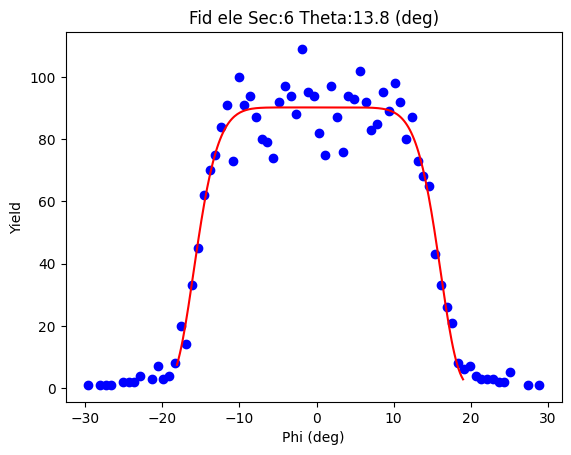

...........Theta: 15.0 ............
Binning| Sec: 5  Ybin: 12
Sum of plot 4353.0
Initial Bounds: [-19.52076859294263, 19.66722893335637]
Sum of initial fit area: 4282.0
max at  110.0
initial max 90.19148452901058
initial guesses: [110.0, 0.07323017020686876, 11.507218959456392, 8.22500730721855]
fit bounds [-19.52076859294263, 19.66722893335637]
(array([9.83143141e+01, 3.98546842e-02, 1.23031094e+01, 7.98623730e+00]), array([[ 2.22450091e+00,  2.70671151e-04, -3.83078680e-02,
        -5.25595944e-01],
       [ 2.70671151e-04,  2.19601349e-02,  6.77305051e-05,
        -5.95203242e-04],
       [-3.83078680e-02,  6.77305051e-05,  1.40617587e-02,
        -2.06989215e-02],
       [-5.25595944e-01, -5.95203242e-04, -2.06989215e-02,
         7.22553894e-01]]))
[9.83143141e+01 3.98546842e-02 1.23031094e+01 7.98623730e+00]
[9.83143141e+01 3.98546842e-02 1.23031094e+01 7.98623730e+00]
New Bounds for next fit: [-21.025970072042117, 21.1056794404312]


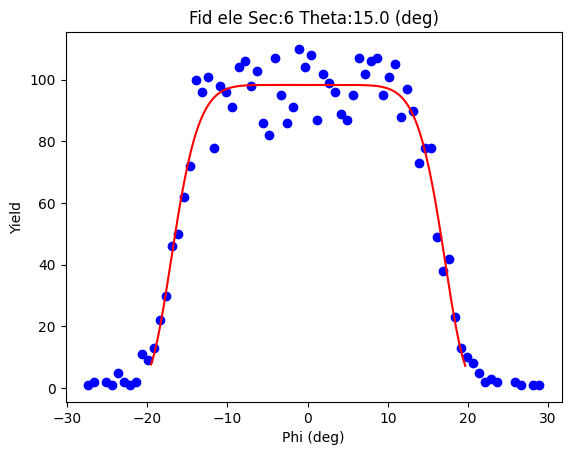

...........Theta: 16.2 ............
Binning| Sec: 5  Ybin: 13
Sum of plot 5146.0
Initial Bounds: [-21.025970072042117, 21.1056794404312]
Sum of initial fit area: 5076.0
max at  135.0
initial max 98.31431414374833
initial guesses: [135.0, 0.039854684194541606, 12.303109436683961, 7.986237303198199]
fit bounds [-21.025970072042117, 21.1056794404312]
(array([1.10006569e+02, 1.69816606e-02, 1.28851218e+01, 9.10431501e+00]), array([[ 3.02794770e+00,  3.51118449e-05, -4.79442501e-02,
        -6.86980268e-01],
       [ 3.51118449e-05,  2.38403326e-02,  6.01914835e-06,
        -7.94411267e-05],
       [-4.79442501e-02,  6.01914835e-06,  1.43986520e-02,
        -1.83927371e-02],
       [-6.86980268e-01, -7.94411267e-05, -1.83927371e-02,
         1.04482766e+00]]))
[1.10006569e+02 1.69816606e-02 1.28851218e+01 9.10431501e+00]
[1.10006569e+02 1.69816606e-02 1.28851218e+01 9.10431501e+00]
New Bounds for next fit: [-21.53330864767581, 21.56727196882668]


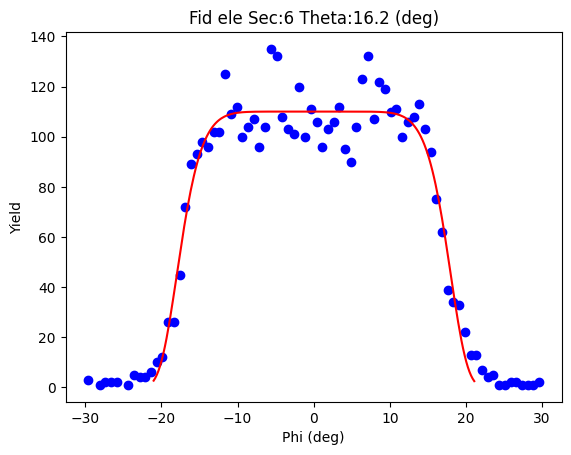

...........Theta: 17.4 ............
Binning| Sec: 5  Ybin: 14
Sum of plot 5562.0
Initial Bounds: [-21.53330864767581, 21.56727196882668]
Sum of initial fit area: 5501.0
max at  135.0
initial max 110.00656942436493
initial guesses: [135.0, 0.01698166057543414, 12.885121843697917, 9.104315013889908]
fit bounds [-21.53330864767581, 21.56727196882668]
(array([112.70449459,  -0.12406797,  13.49189248,  11.17411324]), array([[ 2.79297722e+00, -9.03586730e-05, -3.69640644e-02,
        -7.68799194e-01],
       [-9.03586730e-05,  2.01703472e-02, -1.48440778e-05,
         2.88732268e-04],
       [-3.69640644e-02, -1.48440778e-05,  1.19046826e-02,
        -2.49490922e-02],
       [-7.68799194e-01,  2.88732268e-04, -2.49490922e-02,
         1.70821570e+00]]))
[112.70449459  -0.12406797  13.49189248  11.17411324]
[112.70449459  -0.12406797  13.49189248  11.17411324]
New Bounds for next fit: [-21.998834355368658, 21.750698422365744]


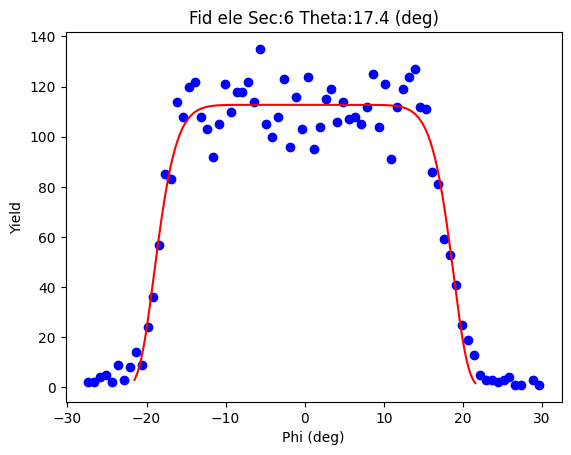

...........Theta: 18.6 ............
Binning| Sec: 5  Ybin: 15
Sum of plot 6059.0
Initial Bounds: [-21.998834355368658, 21.750698422365744]
Sum of initial fit area: 5992.0
max at  140.0
initial max 112.70449458962241
initial guesses: [140.0, -0.12406796650145668, 13.491892482438411, 11.174113239345406]
fit bounds [-21.998834355368658, 21.750698422365744]
(array([117.56231257,  -0.35913458,  14.12774009,  12.        ]), array([[ 3.87688445e+00, -3.02342637e-03, -4.28674975e-02,
        -1.18125348e+00],
       [-3.02342637e-03,  2.75509864e-02, -7.53159519e-04,
         1.22812563e-02],
       [-4.28674975e-02, -7.53159519e-04,  1.67962032e-02,
        -5.67112610e-02],
       [-1.18125348e+00,  1.22812563e-02, -5.67112610e-02,
         3.02080345e+00]]))
[117.56231257  -0.35913458  14.12774009  12.        ]
[117.56231257  -0.35913458  14.12774009  12.        ]
New Bounds for next fit: [-23.050371392799466, 22.332102226935316]


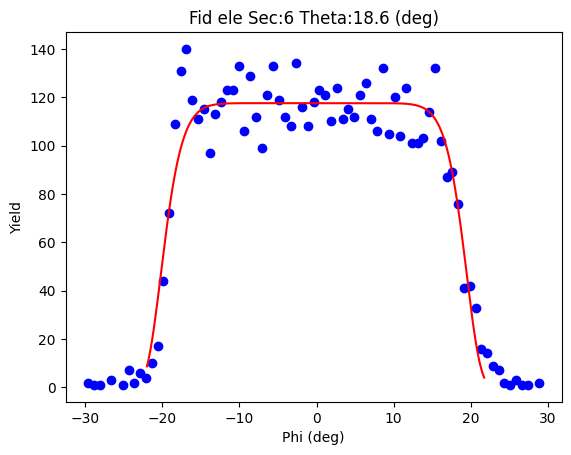

...........Theta: 19.8 ............
Binning| Sec: 5  Ybin: 16
Sum of plot 6483.0
Initial Bounds: [-23.050371392799466, 22.332102226935316]
Sum of initial fit area: 6407.0
max at  142.0
initial max 117.56231256976335
initial guesses: [142.0, -0.35913458293207506, 14.127740094890466, 11.999999999999996]
fit bounds [-23.050371392799466, 22.332102226935316]
(array([123.36165964,  -0.29812299,  14.31272567,  12.        ]), array([[ 4.15779458e+00,  7.38643035e-05, -4.95105943e-02,
        -1.13085419e+00],
       [ 7.38643035e-05,  2.68831991e-02,  1.19083431e-05,
        -2.48226516e-04],
       [-4.95105943e-02,  1.19083431e-05,  1.57820825e-02,
        -3.78278190e-02],
       [-1.13085419e+00, -2.48226516e-04, -3.78278190e-02,
         2.64665892e+00]]))
[123.36165964  -0.29812299  14.31272567  12.        ]
[123.36165964  -0.29812299  14.31272567  12.        ]
New Bounds for next fit: [-23.286473953824885, 22.69022796583261]


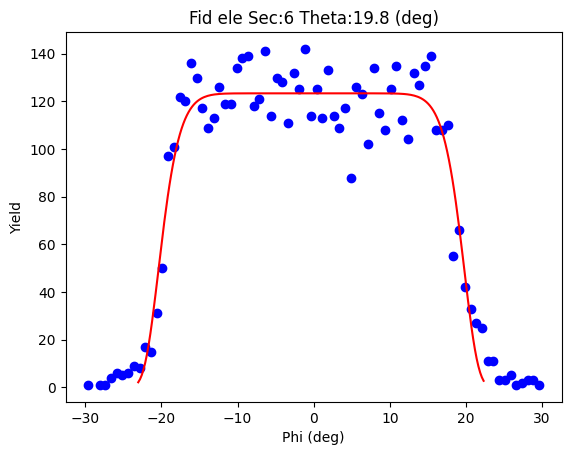

...........Theta: 21.0 ............
Binning| Sec: 5  Ybin: 17
Sum of plot 6875.0
Initial Bounds: [-23.286473953824885, 22.69022796583261]
Sum of initial fit area: 6791.0
max at  151.0
initial max 123.36165963937648
initial guesses: [151.0, -0.29812299399613634, 14.312725669909549, 11.999999999999744]
fit bounds [-23.286473953824885, 22.69022796583261]
(array([125.66204171,  -0.18197212,  15.00888966,  12.        ]), array([[ 4.03268682e+00,  2.22195932e-03, -4.20833451e-02,
        -1.18064697e+00],
       [ 2.22195932e-03,  2.85204077e-02,  5.97152395e-04,
        -8.71792134e-03],
       [-4.20833451e-02,  5.97152395e-04,  1.77286383e-02,
        -6.27232560e-02],
       [-1.18064697e+00, -8.71792134e-03, -6.27232560e-02,
         2.86999153e+00]]))
[125.66204171  -0.18197212  15.00888966  12.        ]
[125.66204171  -0.18197212  15.00888966  12.        ]
New Bounds for next fit: [-24.28846525964541, 23.92452101388589]


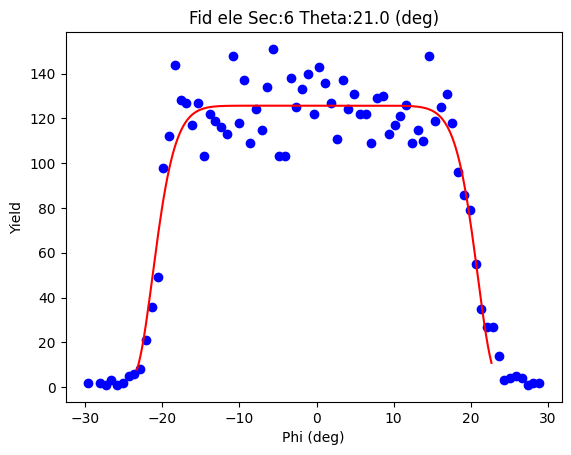

...........Theta: 22.2 ............
Binning| Sec: 5  Ybin: 18
Sum of plot 7041.0
Initial Bounds: [-24.28846525964541, 23.92452101388589]
Sum of initial fit area: 6991.0
max at  154.0
initial max 125.66204170666516
initial guesses: [154.0, -0.1819721228797589, 15.00888966472675, 11.999999999999982]
fit bounds [-24.28846525964541, 23.92452101388589]
(array([ 1.26521078e+02, -1.08091425e-01,  1.53122347e+01,  1.20000000e+01]), array([[ 3.67980149e+00, -3.37836442e-04, -4.45265426e-02,
        -9.94284708e-01],
       [-3.37836442e-04,  2.59822763e-02, -6.76919761e-05,
         1.17495308e-03],
       [-4.45265426e-02, -6.76919761e-05,  1.53833171e-02,
        -3.77727532e-02],
       [-9.94284708e-01,  1.17495308e-03, -3.77727532e-02,
         2.29141221e+00]]))
[ 1.26521078e+02 -1.08091425e-01  1.53122347e+01  1.20000000e+01]
[ 1.26521078e+02 -1.08091425e-01  1.53122347e+01  1.20000000e+01]
New Bounds for next fit: [-24.70180155583409, 24.485618705869673]


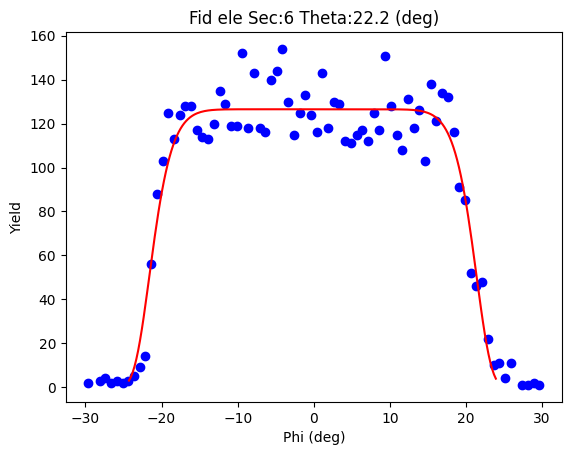

...........Theta: 23.4 ............
Binning| Sec: 5  Ybin: 19
Sum of plot 7035.0
Initial Bounds: [-24.70180155583409, 24.485618705869673]
Sum of initial fit area: 7003.0
max at  142.0
initial max 126.52107778884317
initial guesses: [142.0, -0.10809142498220911, 15.312234745470473, 11.999999999999998]
fit bounds [-24.70180155583409, 24.485618705869673]
(array([123.47674642,  -0.19222927,  15.69993012,  12.        ]), array([[ 3.11279708e+00, -3.80806818e-04, -3.99307909e-02,
        -8.56401764e-01],
       [-3.80806818e-04,  2.42292879e-02, -7.68755505e-05,
         1.33731169e-03],
       [-3.99307909e-02, -7.68755505e-05,  1.43027476e-02,
        -3.32289880e-02],
       [-8.56401764e-01,  1.33731169e-03, -3.32289880e-02,
         2.01555019e+00]]))
[123.47674642  -0.19222927  15.69993012  12.        ]
[123.47674642  -0.19222927  15.69993012  12.        ]
New Bounds for next fit: [-25.408635428632397, 25.024176886201477]


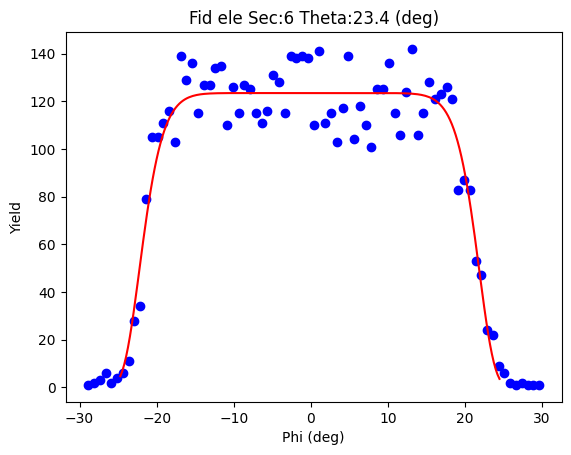

...........Theta: 24.6 ............
Binning| Sec: 5  Ybin: 20
Sum of plot 6260.0
Initial Bounds: [-25.408635428632397, 25.024176886201477]
Sum of initial fit area: 6223.0
max at  142.0
initial max 123.47674642124116
initial guesses: [142.0, -0.19222927121545863, 15.699930122992008, 11.999999999999998]
fit bounds [-25.408635428632397, 25.024176886201477]
(array([107.60500322,  -0.34032926,  16.03050448,  12.        ]), array([[ 3.79224181e+00,  1.31556684e-04, -5.65145221e-02,
        -1.20441975e+00],
       [ 1.31556684e-04,  4.05655661e-02,  3.24648582e-05,
        -5.38081008e-04],
       [-5.65145221e-02,  3.24648582e-05,  2.40133280e-02,
        -5.62149881e-02],
       [-1.20441975e+00, -5.38081008e-04, -5.62149881e-02,
         3.26291444e+00]]))
[107.60500322  -0.34032926  16.03050448  12.        ]
[107.60500322  -0.34032926  16.03050448  12.        ]
New Bounds for next fit: [-26.087686653928458, 25.407028129920782]


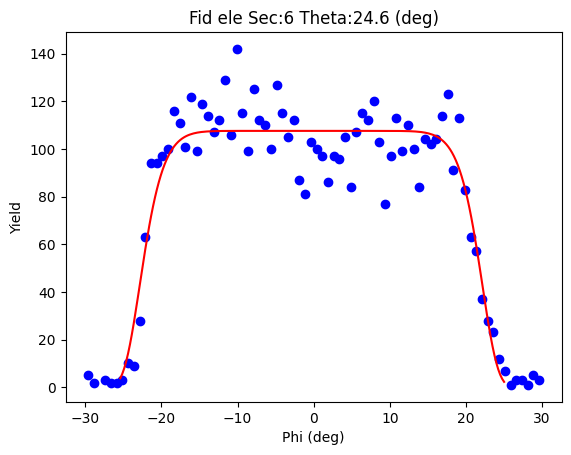

...........Theta: 25.8 ............
Binning| Sec: 5  Ybin: 21
Sum of plot 6251.0
Initial Bounds: [-26.087686653928458, 25.407028129920782]
Sum of initial fit area: 6234.0
max at  131.0
initial max 107.60500322130737
initial guesses: [131.0, -0.3403292620038364, 16.030504481147922, 11.999999999999998]
fit bounds [-26.087686653928458, 25.407028129920782]
(array([106.46398587,  -0.23838648,  16.21815634,  12.        ]), array([[ 3.05383344e+00,  1.35750528e-04, -4.76461699e-02,
        -9.63936414e-01],
       [ 1.35750528e-04,  3.40477677e-02,  2.95848001e-05,
        -5.33717087e-04],
       [-4.76461699e-02,  2.95848001e-05,  2.00012952e-02,
        -4.26351370e-02],
       [-9.63936414e-01, -5.33717087e-04, -4.26351370e-02,
         2.61615419e+00]]))
[106.46398587  -0.23838648  16.21815634  12.        ]
[106.46398587  -0.23838648  16.21815634  12.        ]
New Bounds for next fit: [-26.287140461086068, 25.81036750616029]


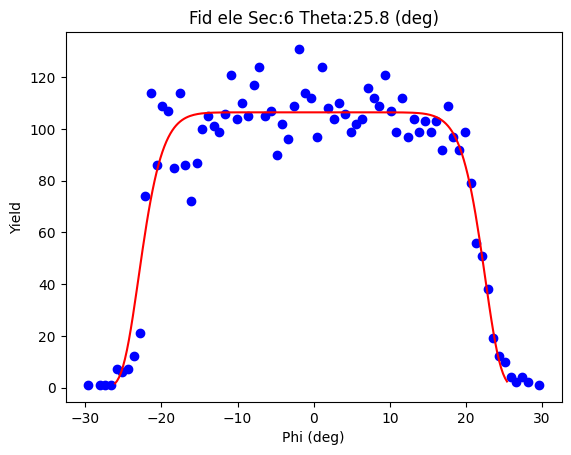

...........Theta: 27.0 ............
Binning| Sec: 5  Ybin: 22
Sum of plot 6359.0
Initial Bounds: [-26.287140461086068, 25.81036750616029]
Sum of initial fit area: 6342.0
max at  138.0
initial max 106.46398587208233
initial guesses: [138.0, -0.23838647746289024, 16.21815633761929, 11.999999999999998]
fit bounds [-26.287140461086068, 25.81036750616029]
(array([1.08888403e+02, 9.60687267e-02, 1.62618118e+01, 1.01754551e+01]), array([[ 3.45424431e+00,  1.92080746e-03, -6.01677229e-02,
        -9.14615719e-01],
       [ 1.92080746e-03,  4.15874279e-02,  4.96047498e-04,
        -5.74167907e-03],
       [-6.01677229e-02,  4.96047498e-04,  2.51091445e-02,
        -4.01294640e-02],
       [-9.14615719e-01, -5.74167907e-03, -4.01294640e-02,
         1.77654963e+00]]))
[1.08888403e+02 9.60687267e-02 1.62618118e+01 1.01754551e+01]
[1.08888403e+02 9.60687267e-02 1.62618118e+01 1.01754551e+01]
New Bounds for next fit: [-26.625679282345526, 26.817816735679248]


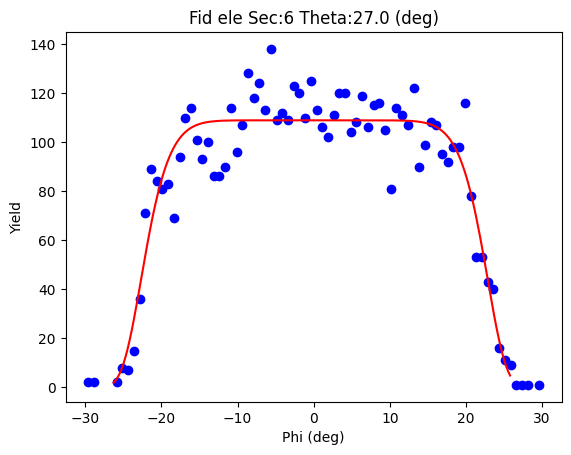

...........Theta: 28.2 ............
Binning| Sec: 5  Ybin: 23
Sum of plot 5965.0
Initial Bounds: [-26.625679282345526, 26.817816735679248]
Sum of initial fit area: 5953.0
max at  123.0
initial max 108.88840280888556
initial guesses: [123.0, 0.09606872666686087, 16.261811799557822, 10.175455085776811]
fit bounds [-26.625679282345526, 26.817816735679248]
(array([1.02048155e+02, 4.85997699e-02, 1.62805636e+01, 9.89571853e+00]), array([[ 2.55834357e+00,  1.69812072e-05, -5.15106592e-02,
        -6.76752527e-01],
       [ 1.69812072e-05,  3.54623260e-02,  3.38301082e-06,
        -4.61205606e-05],
       [-5.15106592e-02,  3.38301082e-06,  2.11177723e-02,
        -2.52379196e-02],
       [-6.76752527e-01, -4.61205606e-05, -2.52379196e-02,
         1.30040917e+00]]))
[1.02048155e+02 4.85997699e-02 1.62805636e+01 9.89571853e+00]
[1.02048155e+02 4.85997699e-02 1.62805636e+01 9.89571853e+00]
New Bounds for next fit: [-26.81770471818575, 26.914904257942098]


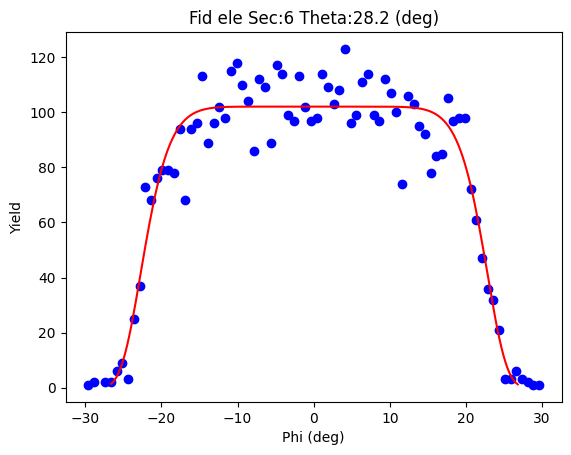

...........Theta: 29.4 ............
Binning| Sec: 5  Ybin: 24
Sum of plot 5492.0
Initial Bounds: [-26.81770471818575, 26.914904257942098]
Sum of initial fit area: 5480.0
max at  127.0
initial max 102.04815468112022
initial guesses: [127.0, 0.04859976987817282, 16.280563604940482, 9.895718531484198]
fit bounds [-26.81770471818575, 26.914904257942098]
(array([9.21796996e+01, 8.31204626e-02, 1.65128408e+01, 1.13871145e+01]), array([[ 3.24773658e+00,  2.23528630e-05, -6.34271233e-02,
        -1.11086558e+00],
       [ 2.23528630e-05,  5.18409104e-02,  4.98338593e-06,
        -8.77490261e-05],
       [-6.34271233e-02,  4.98338593e-06,  3.05000410e-02,
        -5.38115680e-02],
       [-1.11086558e+00, -8.77490261e-05, -5.38115680e-02,
         3.12704111e+00]]))
[9.21796996e+01 8.31204626e-02 1.65128408e+01 1.13871145e+01]
[9.21796996e+01 8.31204626e-02 1.65128408e+01 1.13871145e+01]
New Bounds for next fit: [-26.62123332074295, 26.787474245964706]


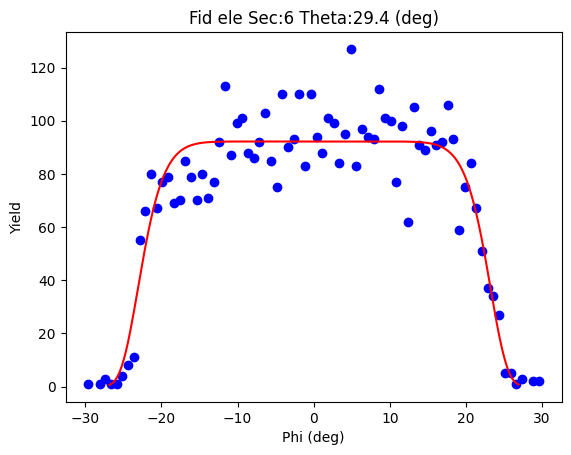

...........Theta: 30.6 ............
Binning| Sec: 5  Ybin: 25
Sum of plot 4838.0
Initial Bounds: [-26.62123332074295, 26.787474245964706]
Sum of initial fit area: 4834.0
max at  97.0
initial max 92.17969955740753
initial guesses: [97.0, 0.08312046261087841, 16.51284080451789, 11.387114484250024]
fit bounds [-26.62123332074295, 26.787474245964706]
(array([ 7.97345088e+01, -6.21422149e-02,  1.68820204e+01,  1.20000000e+01]), array([[ 1.91758745e+00, -4.38624824e-03, -3.54081288e-02,
        -8.72468331e-01],
       [-4.38624824e-03,  4.46960929e-02, -3.34848547e-03,
         3.31523061e-02],
       [-3.54081288e-02, -3.34848547e-03,  2.80386870e-02,
        -9.12454915e-02],
       [-8.72468331e-01,  3.31523061e-02, -9.12454915e-02,
         3.37944796e+00]]))
[ 7.97345088e+01 -6.21422149e-02  1.68820204e+01  1.20000000e+01]
[ 7.97345088e+01 -6.21422149e-02  1.68820204e+01  1.20000000e+01]
New Bounds for next fit: [-27.177159864557147, 27.052875434767103]


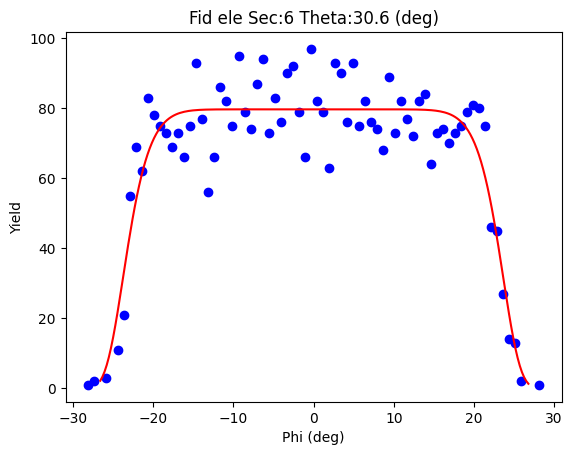

...........Theta: 31.8 ............
Binning| Sec: 5  Ybin: 26
Sum of plot 4086.0
Initial Bounds: [-27.177159864557147, 27.052875434767103]
Sum of initial fit area: 4075.0
max at  82.0
initial max 79.73450876677336
initial guesses: [82.0, -0.062142214895023855, 16.882020369035715, 11.999999999999991]
fit bounds [-27.177159864557147, 27.052875434767103]
(array([ 6.63308536e+01, -5.92323632e-02,  1.70722442e+01,  1.20000000e+01]), array([[ 1.60502408e+00, -9.12805473e-05, -4.19545363e-02,
        -8.18258195e-01],
       [-9.12805473e-05,  5.11351814e-02, -3.60936806e-05,
         5.90035050e-04],
       [-4.19545363e-02, -3.60936806e-05,  3.01195802e-02,
        -6.28581970e-02],
       [-8.18258195e-01,  5.90035050e-04, -6.28581970e-02,
         3.57575165e+00]]))
[ 6.63308536e+01 -5.92323632e-02  1.70722442e+01  1.20000000e+01]
[ 6.63308536e+01 -5.92323632e-02  1.70722442e+01  1.20000000e+01]
New Bounds for next fit: [-27.479777544214244, 27.361312817876197]


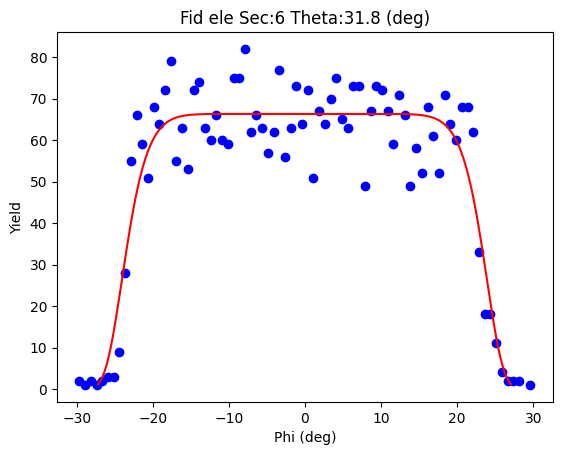

...........Theta: 33.0 ............
Binning| Sec: 5  Ybin: 27
Sum of plot 3171.0
Initial Bounds: [-27.479777544214244, 27.361312817876197]
Sum of initial fit area: 3168.0
max at  71.0
initial max 66.33085355969779
initial guesses: [71.0, -0.05923236316902446, 17.072244180605864, 11.999999999999998]
fit bounds [-27.479777544214244, 27.361312817876197]
(array([51.97885776,  0.09843228, 16.92222588, 12.        ]), array([[ 1.35832576e+00,  1.80673506e-04, -4.54362371e-02,
        -8.75943135e-01],
       [ 1.80673506e-04,  6.91511883e-02,  8.05132645e-05,
        -1.43364910e-03],
       [-4.54362371e-02,  8.05132645e-05,  4.05842076e-02,
        -8.19739841e-02],
       [-8.75943135e-01, -1.43364910e-03, -8.19739841e-02,
         4.86369106e+00]]))
[51.97885776  0.09843228 16.92222588 12.        ]
[51.97885776  0.09843228 16.92222588 12.        ]
New Bounds for next fit: [-27.08116135621678, 27.27802592369343]


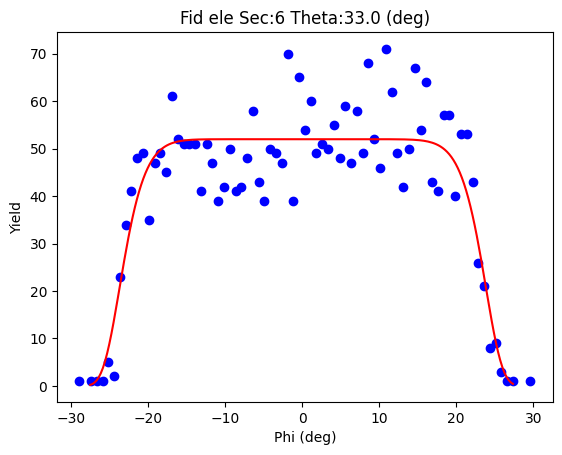

...........Theta: 34.2 ............
Binning| Sec: 5  Ybin: 28
Sum of plot 2460.0
Initial Bounds: [-27.08116135621678, 27.27802592369343]
Sum of initial fit area: 2455.0
max at  58.0
initial max 51.97885776297118
initial guesses: [58.0, 0.09843228373832556, 16.922225881625167, 11.999999999999998]
fit bounds [-27.08116135621678, 27.27802592369343]
(array([39.18361371,  0.30059955, 17.45119122, 12.        ]), array([[ 1.03999380e+00, -2.69233969e-03, -3.90427773e-02,
        -9.83074605e-01],
       [-2.69233969e-03,  1.05300483e-01, -4.35648409e-03,
         4.17959335e-02],
       [-3.90427773e-02, -4.35648409e-03,  6.68390585e-02,
        -2.20167333e-01],
       [-9.83074605e-01,  4.17959335e-02, -2.20167333e-01,
         7.79165116e+00]]))
[39.18361371  0.30059955 17.45119122 12.        ]
[39.18361371  0.30059955 17.45119122 12.        ]
New Bounds for next fit: [-27.728590532828207, 28.329789627219185]


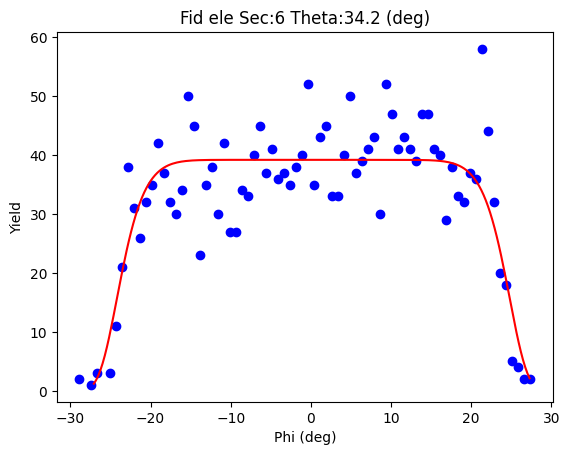

...........Theta: 35.4 ............
Binning| Sec: 5  Ybin: 29
Sum of plot 1855.0
Initial Bounds: [-27.728590532828207, 28.329789627219185]
Sum of initial fit area: 1855.0
max at  44.0
initial max 39.183613713552376
initial guesses: [44.0, 0.3005995471954895, 17.451191217071923, 11.999999999999998]
fit bounds [-27.728590532828207, 28.329789627219185]
(array([29.85835162,  0.24140704, 17.29582718, 12.        ]), array([[ 6.22430501e-01,  1.15253066e-03, -2.79556046e-02,
        -7.88759793e-01],
       [ 1.15253066e-03,  1.11470748e-01,  3.78716962e-03,
        -2.95449677e-02],
       [-2.79556046e-02,  3.78716962e-03,  7.41235324e-02,
        -2.80398554e-01],
       [-7.88759793e-01, -2.95449677e-02, -2.80398554e-01,
         8.46698390e+00]]))
[29.85835162  0.24140704 17.29582718 12.        ]
[29.85835162  0.24140704 17.29582718 12.        ]
New Bounds for next fit: [-27.538245447160303, 28.021059525194215]


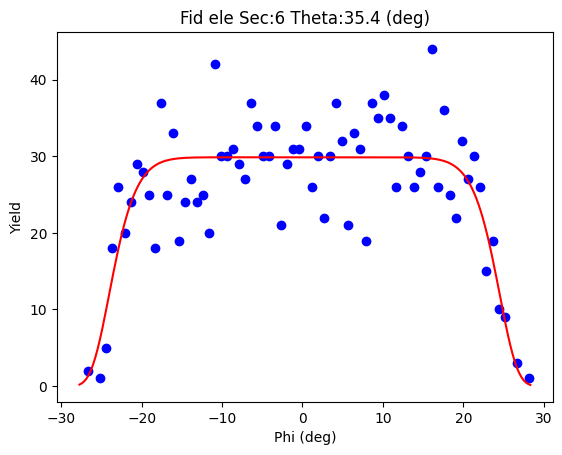

...........Theta: 36.6 ............
Binning| Sec: 5  Ybin: 30
Sum of plot 1607.0
Initial Bounds: [-27.538245447160303, 28.021059525194215]
Sum of initial fit area: 1605.0
max at  39.0
initial max 29.85835161867431
initial guesses: [39.0, 0.24140703901695648, 17.295827175027533, 11.999999999999842]
fit bounds [-27.538245447160303, 28.021059525194215]
(array([27.37096289,  0.07733938, 16.94257763,  6.84346034]), array([[ 0.77629804,  0.00614859, -0.05349775, -0.6308454 ],
       [ 0.00614859,  0.22817693,  0.01498298, -0.04750924],
       [-0.05349775,  0.01498298,  0.17655711, -0.25311816],
       [-0.6308454 , -0.04750924, -0.25311816,  2.58117154]]))
[27.37096289  0.07733938 16.94257763  6.84346034]
[27.37096289  0.07733938 16.94257763  6.84346034]
New Bounds for next fit: [-29.873651539291114, 30.028330306876963]


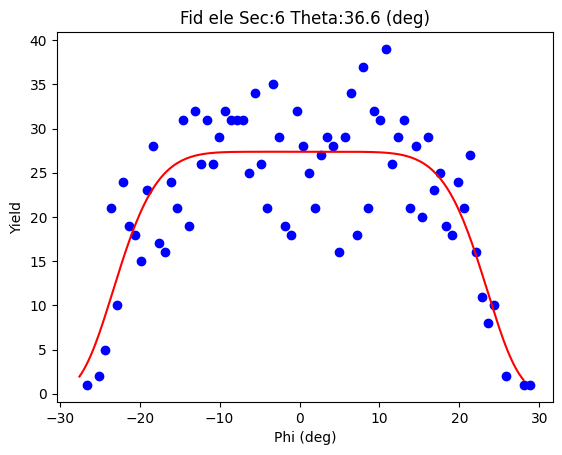

...........Theta: 37.8 ............
Binning| Sec: 5  Ybin: 31
Sum of plot 1322.0
Initial Bounds: [-29.873651539291114, 30.028330306876963]
Sum of initial fit area: 1322.0
max at  37.0
initial max 27.37096288824743
initial guesses: [37.0, 0.07733938379292594, 16.94257763310485, 6.843460341069859]
fit bounds [-29.873651539291114, 30.028330306876963]
(array([23.43585347, -0.30709895, 16.72208142,  4.65507411]), array([[ 0.89238558, -0.01639137, -0.12632337, -0.52293892],
       [-0.01639137,  0.37990304, -0.03298916,  0.06239905],
       [-0.12632337, -0.03298916,  0.29563668, -0.13193955],
       [-0.52293892,  0.06239905, -0.13193955,  1.13034117]]))
[23.43585347 -0.30709895 16.72208142  4.65507411]
[23.43585347 -0.30709895 16.72208142  4.65507411]
New Bounds for next fit: [-33.13804057037641, 32.52384267642437]


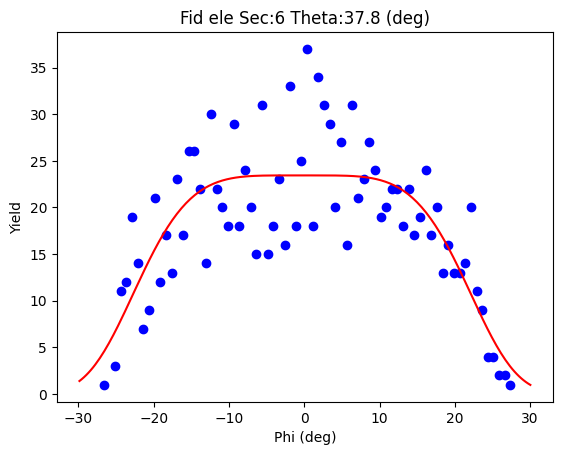

...........Theta: 39.0 ............
Binning| Sec: 5  Ybin: 32
Sum of plot 998.0
Initial Bounds: [-33.13804057037641, 32.52384267642437]
Sum of initial fit area: 998.0
max at  25.0
initial max 23.43585347497926
initial guesses: [25.0, -0.30709894697601653, 16.722081415741375, 4.6550741132139875]
fit bounds [-33.13804057037641, 32.52384267642437]
(array([17.49524363, -0.30001945, 16.52511896,  5.9311403 ]), array([[ 4.17278555e-01, -1.63833941e-03, -6.14732111e-02,
        -4.29362023e-01],
       [-1.63833941e-03,  2.81913143e-01, -2.07778606e-03,
         1.02114402e-02],
       [-6.14732111e-02, -2.07778606e-03,  2.06134665e-01,
        -1.69057232e-01],
       [-4.29362023e-01,  1.02114402e-02, -1.69057232e-01,
         1.97418926e+00]]))
[17.49524363 -0.30001945 16.52511896  5.9311403 ]
[17.49524363 -0.30001945 16.52511896  5.9311403 ]
New Bounds for next fit: [-30.533204654291296, 29.933165763067002]


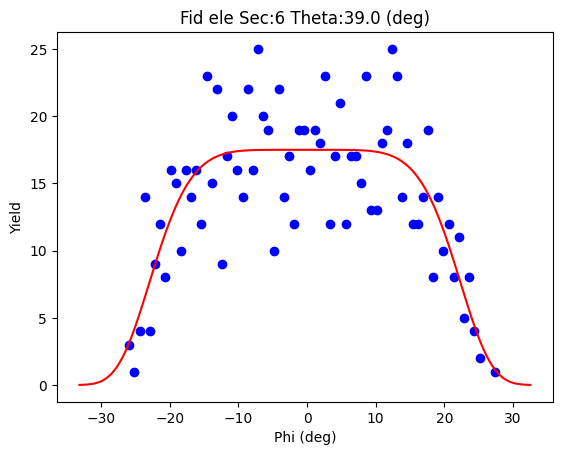

In [34]:
#Bounds Fitting Fun
a1=600.0
m1=0.0
s1=10.0
p1=2.0
ini_par1=[a1,m1,s1,p1]

fid_pro_fit_pars1=np.zeros((6,len(fid_pro_y),4))
fid_pro_fit_sig1=np.zeros((6,len(fid_pro_y),4))
fid_pro_pos_do=np.zeros((6,len(fid_pro_y)))
fid_pro_neg_do=np.zeros((6,len(fid_pro_y)))

front_bump_tolerance=7
back_bump_tolerance=3
low_frac = 0.16
top_frac= 0.12

ini_bounds1=[-10.0,10.0]

theta_max = 50.0
pmin = 0.8

expansion = False
last_par_pos = 0.0
last_par_neg = 0.0
enter_pos_vals = False
enter_neg_vals = False

min_integral = 800

sec_count =0
pbin_count = 0
tbin_count=0
for sec in range(6):
    ini_bounds1[0]=-10.0
    ini_bounds1[1]=10.0
    tbin_count=0
    for ybin in range(len(fid_pro_y)):
        if fid_pro_fit_y[sec][ybin].sum() >= min_integral: 
            if sec_count <= sec:
                print("==========Sec ",sec+1,"===============")
                sec_count+=1
            if tbin_count <= ybin:
                print("...........Theta:",round(fid_pro_y[ybin],3),"............")
                tbin_count+=1
            print("Binning| Sec:",sec," Ybin:",ybin)
            print("Sum of plot",fid_pro_fit_y[sec][ybin].sum())
            print("Initial Bounds:",ini_bounds1)
            print("Sum of initial fit area:",Bounds_on_X_From_Y(fid_pro_fit_y[sec][ybin],fid_pro_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]).sum())
            print("max at ",np.amax(Bounds_on_X_From_Y(fid_pro_fit_y[sec][ybin],fid_pro_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1])))
            print("initial max",ini_par1[0])
            ini_par1[0] = np.amax(Bounds_on_X_From_Y(fid_pro_fit_y[sec][ybin],fid_pro_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]))
            #if Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance):
            #    print("lower bump start @ ",Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance))
            #    print("lower found at:",Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0)[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0))])
            #    if Check_Bump_Size(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance,low_frac,5.0):
            #        print("\tlower fraction found sufficient to cut it off")
                    #ini_bounds1[0] = Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0)[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance),0.0))]
                    #ini_bounds1[0] = Bump_Safe(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],0,front_bump_tolerance,0.0)
            #        ini_bounds1[0] = -15.0
            #        print("\tnew lower bound:",ini_bounds1[0])
            #if Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance):
            #    print("upper bump @ ",Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,5))
            #    print("upper found at:",Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance))[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance)))])
            #    if Check_Bump_Size(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance,top_frac,-5.0):
            #        print("\ttop fraction found sufficient to cut it off")
                    #ini_bounds1[1] = Bounds_on_Y(fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance))[np.argmin(Bounds_on_X_From_Y(fid_ele_fit_y[sec][pbin][ybin],fid_ele_fit_x[sec][pbin][ybin],0.0,Check_Bump(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance)))]
                    #ini_bounds1[1] = Bump_Safe(fid_ele_fit_x[sec][pbin][ybin],fid_ele_fit_y[sec][pbin][ybin],1,back_bump_tolerance,0.0)
            #        ini_bounds1[1] = 15.0
            #        print("\tnew upper bound:",ini_bounds1[1])
            print("initial guesses:",ini_par1)
            print("fit bounds",ini_bounds1)
            plt.scatter(fid_pro_fit_x[sec][ybin],fid_pro_fit_y[sec][ybin],label="data",color='b')
            try: 
                pars1=op.curve_fit(Super_Gaus,Bounds_on_Y(fid_pro_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]),Bounds_on_X_From_Y(fid_pro_fit_y[sec][ybin],fid_pro_fit_x[sec][ybin],ini_bounds1[0],ini_bounds1[1]),p0=ini_par1,bounds=((0.0,-20,0.0,2.0),(np.inf,20,30,12)),maxfev=5000)
                print(pars1)
                if ybin >0:
                    if pars1[0][1]+pars1[0][2] >= fid_pro_fit_pars1[sec][ybin-1][1]+fid_pro_fit_pars1[sec][ybin-1][2]:
                        enter_pos_vals = True
                    else:
                        enter_pos_vals = False
                    if pars1[0][1]-pars1[0][2] <= fid_pro_fit_pars1[sec][ybin-1][1]-fid_pro_fit_pars1[sec][ybin-1][2]:
                        enter_neg_vals = True
                    else:
                        enter_neg_vals = False
                else:
                    enter_pos_vals = True
                    enter_neg_vals = True
                for i in range(4):
                    fid_pro_fit_pars1[sec][ybin][i] += pars1[0][i]
                    if enter_pos_vals:
                        fid_pro_pos_do[sec][ybin] = 1
                    if enter_neg_vals:
                        fid_pro_neg_do[sec][ybin] = 1
                    fid_pro_fit_sig1[sec][ybin][i] += np.sqrt(pars1[1][i][i])
                    ini_par1[i]=pars1[0][i]
                print(pars1[0])
                print(fid_pro_fit_pars1[sec][ybin])
                cont_x1= np.linspace(ini_bounds1[0],ini_bounds1[1],200)
                plt.plot(cont_x1,Super_Gaus(cont_x1,*pars1[0]),color='r',label="fit")
                ini_bounds1[0] = Super_Gaus_Bound(pars1[0][0],pars1[0][1],pars1[0][2],pars1[0][3],0.01)[0]
                ini_bounds1[1] = Super_Gaus_Bound(pars1[0][0],pars1[0][1],pars1[0][2],pars1[0][3],0.01)[1]
                print("New Bounds for next fit:",ini_bounds1)
            except RuntimeError:
                print("Runtime Error\n\tJust skip it for now")
            #plow and ptop come from Momentum Bins
            plt.title("Fid ele Sec:{} Theta:{} (deg)".format(sec+1,round(fid_pro_y[ybin],3)))
            plt.xlabel("Phi (deg)")
            plt.ylabel("Yield")
            plt.show()

In [46]:
def fit_func_pos(theta_, a0_, a1_, a2_, a3_):
    return a0_*(1-np.exp(-a1_*(theta_-a2_)))+a3_
def fit_func_neg(theta_, a0_, a1_, a2_, a3_):
    return -a0_*(1-np.exp(-a1_*(theta_-a2_)))+a3_

[-62, 0.18, 1.8, 41.6]
min neg pars [-106.77298345    0.14894635   -2.55928869   84.44850816]
min pos pars [ 1.86806836e+02  1.18652881e-01 -1.05155436e+01 -1.63532648e+02]


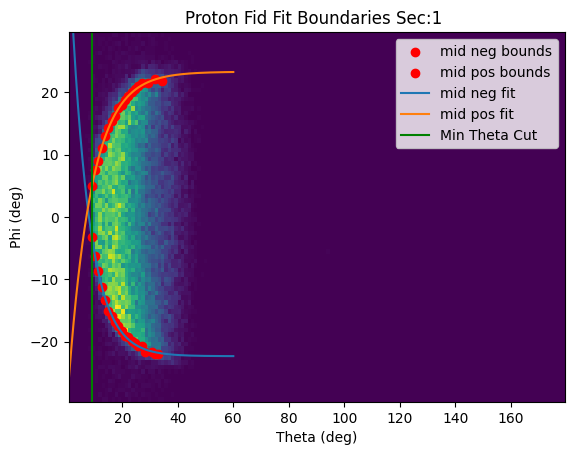

[-62, 0.18, 1.8, 41.6]
min neg pars [-123.32385842    0.1494985    -3.95442898  101.34646896]
min pos pars [ 2.20610655e+02  1.41255727e-01 -8.66577508e+00 -1.98477749e+02]


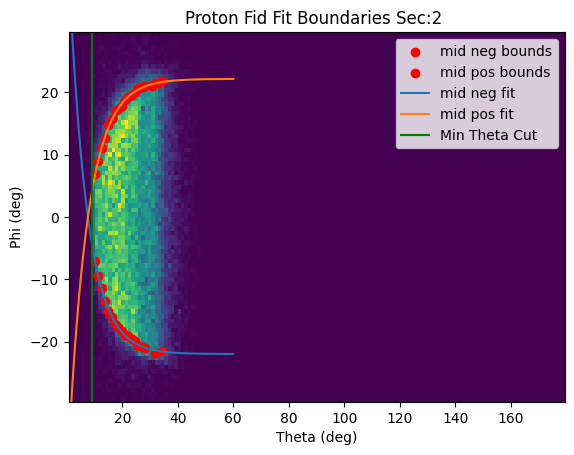

[-62, 0.18, 1.8, 41.6]
min neg pars [-57.93199017   0.18686333   2.38669427  36.75539462]
min pos pars [ 2.07903164e+02  1.07307756e-01 -1.40416364e+01 -1.85006795e+02]


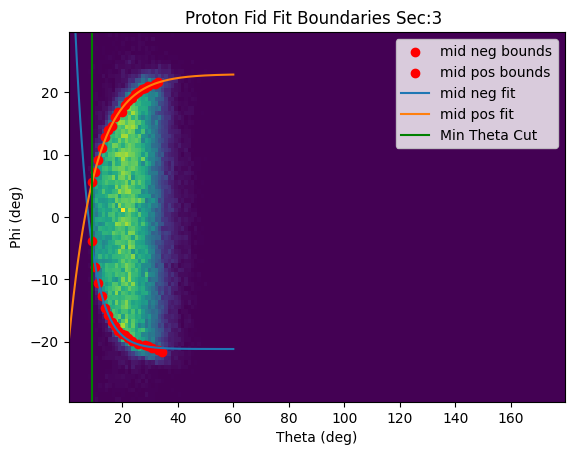

[-62, 0.18, 1.8, 41.6]
min neg pars [-71.10692069   0.20888074   2.3682137   50.13707253]
min pos pars [ 2.18070793e+02  1.49228779e-01 -8.85132029e+00 -1.97385437e+02]


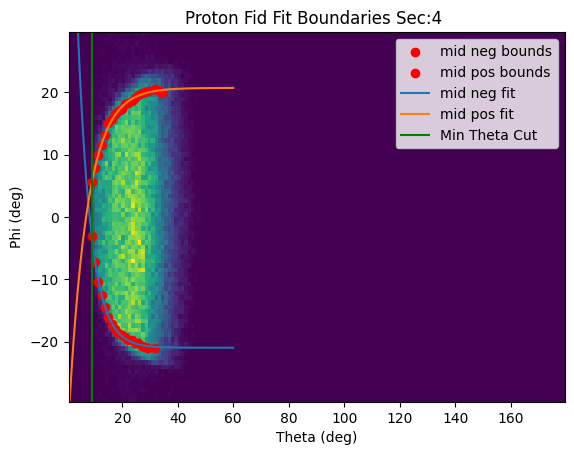

[-62, 0.18, 1.8, 41.6]
min neg pars [-77.04619894   0.13252634   0.27152864  53.53343471]
min pos pars [ 2.32214307e+02  1.45918979e-01 -9.22266093e+00 -2.09920392e+02]


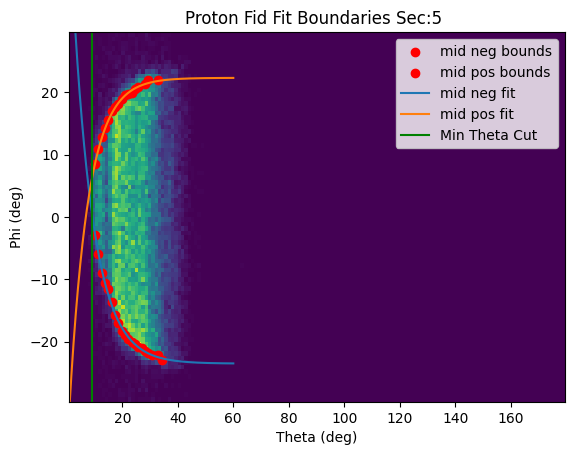

[-62, 0.18, 1.8, 41.6]
min neg pars [-89.47538234   0.1608019   -0.66046568  67.90235851]
min pos pars [ 2.25661291e+02  1.23333713e-01 -1.22624951e+01 -2.03494780e+02]


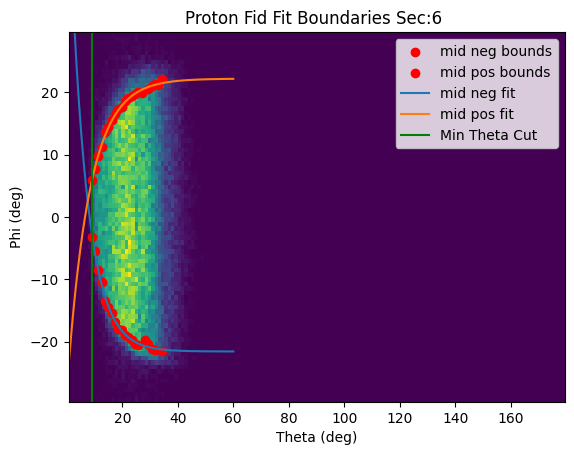

In [84]:
#Create the bounds for the fitting
bound_frac = 0.8
bound_frac_low = 0.5
bound_frac_top = 0.95

fit_bounds = np.zeros((6,2,len(fid_pro_y)))
fit_bounds_low = np.zeros((6,2,len(fid_pro_y)))
fit_bounds_top = np.zeros((6,2,len(fid_pro_y)))

for sec in range(6):
    for ybin in range(len(fid_pro_y)):
        #print(fid_ele_fit_pars1[sec][pbin][ybin][0])
        if fid_pro_fit_pars1[sec][ybin][0]>0 and fid_pro_y[ybin]<35.0:
            if fid_pro_neg_do[sec][ybin]:
                fit_bounds[sec][0][ybin] = Super_Gaus_Bound(fid_pro_fit_pars1[sec][ybin][0],fid_pro_fit_pars1[sec][ybin][1],fid_pro_fit_pars1[sec][ybin][2],fid_pro_fit_pars1[sec][ybin][3],bound_frac)[0]
            if fid_pro_pos_do[sec][ybin]:
                fit_bounds[sec][1][ybin] = Super_Gaus_Bound(fid_pro_fit_pars1[sec][ybin][0],fid_pro_fit_pars1[sec][ybin][1],fid_pro_fit_pars1[sec][ybin][2],fid_pro_fit_pars1[sec][ybin][3],bound_frac)[1]
            #print(fit_bounds[sec][pbin][0][ybin],fit_bounds[sec][pbin][1][ybin])
            fit_bounds_low[sec][0][ybin] = Super_Gaus_Bound(fid_pro_fit_pars1[sec][ybin][0],fid_pro_fit_pars1[sec][ybin][1],fid_pro_fit_pars1[sec][ybin][2],fid_pro_fit_pars1[sec][ybin][3],bound_frac_low)[0]
            fit_bounds_low[sec][1][ybin] = Super_Gaus_Bound(fid_pro_fit_pars1[sec][ybin][0],fid_pro_fit_pars1[sec][ybin][1],fid_pro_fit_pars1[sec][ybin][2],fid_pro_fit_pars1[sec][ybin][3],bound_frac_low)[1]
            fit_bounds_top[sec][0][ybin] = Super_Gaus_Bound(fid_pro_fit_pars1[sec][ybin][0],fid_pro_fit_pars1[sec][ybin][1],fid_pro_fit_pars1[sec][ybin][2],fid_pro_fit_pars1[sec][ybin][3],bound_frac_top)[0]
            fit_bounds_top[sec][1][ybin] = Super_Gaus_Bound(fid_pro_fit_pars1[sec][ybin][0],fid_pro_fit_pars1[sec][ybin][1],fid_pro_fit_pars1[sec][ybin][2],fid_pro_fit_pars1[sec][ybin][3],bound_frac_top)[1]
            #print(fit_bounds[sec][pbin][0][ybin],fit_bounds[sec][pbin][1][ybin])


                
                #Super_Gaus_Bound(a_,m_,s_,p_,frac_)
ini_a0n = -62
ini_a1n = 0.18
ini_a2n = 1.8
ini_a3n = 41.6

ini_a0p = 224
ini_a1p = 0.108
ini_a2p = -14.6
ini_a3p = -201


fit_bounds1 = [[-np.inf,-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf]]

a0_neg_par = np.zeros(6)
a1_neg_par = np.zeros(6)
a2_neg_par = np.zeros(6)
a3_neg_par = np.zeros(6)
a0_pos_par = np.zeros(6)
a1_pos_par = np.zeros(6)
a2_pos_par = np.zeros(6)
a3_pos_par = np.zeros(6)
                
for sec in range(6):
    ini_parsn = [ini_a0n, ini_a1n, ini_a2n, ini_a3n]
    ini_parsp = [ini_a0p, ini_a1p, ini_a2p, ini_a3p]
    if len(Remove_Zeros_Y(fit_bounds[sec][0]))>6:
        plt.hist2d(dumb2_x[sec], dumb2_y[sec], bins=(len(fid_pro_y), len(fid_pro_x)), weights=dense2[sec])
        #print("+",fit_bounds[sec][pbin][0],"+")
        xvals1 = Remove_Zeros_X(fid_pro_y,fit_bounds[sec][0])
        #print("-",xvals1,"-")
        yvals1 = Remove_Zeros_Y(fit_bounds[sec][0])
        plt.scatter(xvals1,yvals1,label="mid neg bounds",color='r')
        xvals2 = Remove_Zeros_X(fid_pro_y,fit_bounds[sec][1])
        yvals2 = Remove_Zeros_Y(fit_bounds[sec][1])
        plt.scatter(xvals2,yvals2,label="mid pos bounds",color='r')
        xvals1_low = Remove_Zeros_X(fid_pro_y,fit_bounds_low[sec][0])
        yvals1_low = Remove_Zeros_Y(fit_bounds_low[sec][0])
        #plt.scatter(xvals1_low,yvals1_low,label="low lower bounds")
        xvals2_low = Remove_Zeros_X(fid_pro_y,fit_bounds_low[sec][1])
        yvals2_low = Remove_Zeros_Y(fit_bounds_low[sec][1])
        #plt.scatter(xvals2_low,yvals2_low,label="low upper bounds")
        xvals1_top = Remove_Zeros_X(fid_pro_y,fit_bounds_top[sec][0])
        yvals1_top = Remove_Zeros_Y(fit_bounds_top[sec][0])
        #plt.scatter(xvals1_top,yvals1_top,label="top lower bounds")
        xvals2_top = Remove_Zeros_X(fid_pro_y,fit_bounds_top[sec][1])
        yvals2_top = Remove_Zeros_Y(fit_bounds_top[sec][1])
        cont_x = np.linspace(0,60,300)
        print(ini_parsn)
        #plt.plot(cont_x,fit_func(cont_x,*ini_parsn),label="ini neg fit",color='r')
        #plt.scatter(xvals2_top,yvals2_top,label="top upper bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_low[sec][pbin][0]),Remove_Zeros_Y(fit_bounds_low[sec][pbin][0]),label="low lower bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_low[sec][pbin][1]),Remove_Zeros_Y(fit_bounds_low[sec][pbin][1]),label="low upper bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_top[sec][pbin][0]),Remove_Zeros_Y(fit_bounds_top[sec][pbin][0]),label="top lower bounds")
            #plt.scatter(Remove_Zeros_X(fid_ele_y,fit_bounds_top[sec][pbin][1]),Remove_Zeros_Y(fit_bounds_top[sec][pbin][1]),label="top upper bounds")
        try:
            pars1, pars_cov1 = op.curve_fit(fit_func,xvals1,yvals1,p0=ini_parsn,bounds=fit_bounds1,maxfev=5000)
            
            plt.plot(cont_x,fit_func(cont_x,*pars1),label="mid neg fit")
            ini_pars[0] = pars1[0]
            ini_pars[1] = -pars1[1]
            a0_neg_par[sec] = pars1[0]
            a1_neg_par[sec] = pars1[1]
            a2_neg_par[sec] = pars1[2]
            a3_neg_par[sec] = pars1[3]
            print("min neg pars",pars1)
        except RuntimeError:
            print("Runtime Error")
        try:
            ini_pars[0] = -ini_pars[0]
            pars2, pars_cov2 = op.curve_fit(fit_func,xvals2,yvals2,p0=ini_parsp,bounds=fit_bounds1,maxfev=5000)
            cont_x = np.linspace(0,60,300)
            plt.plot(cont_x,fit_func(cont_x,*pars2),label="mid pos fit")
            a0_pos_par[sec] = pars2[0]
            a1_pos_par[sec] = pars2[1]
            a2_pos_par[sec] = pars2[2]
            a3_pos_par[sec] = pars2[3]
            print("min pos pars",pars2)
        except RuntimeError:
            print("Runtime Error")
            #plt.axvline(x = min_theta(pvals[pbin],c1_par[sec],c2_par[sec],pshift_par[sec]), color = 'g', label = 'Skew Max')
        plt.axvline(x = min_theta_vals[sec], color = 'g', label = 'Min Theta Cut')
        plt.title("Proton Fid Fit Boundaries Sec:{} ".format(sec+1))
        plt.xlabel("Theta (deg)")
        plt.ylabel("Phi (deg)")
        plt.legend()
        plt.show()
        

In [85]:
#Print Minimum Theta Parameters for Proton Fiducial Cut
print("Minimum Theta Parameters for Proton Fiducial Cut [sec]")
print("Standard")
for sec in range(6):
    if sec==0:
        print("{",min_theta_vals[sec],end=",")
    else:
        if sec ==5:
            print(min_theta_vals[sec],"}")
        else:
            print(min_theta_vals[sec],end=",")
print("Loose")
for sec in range(6):
    if sec==0:
        print("{",min_theta_vals_low[sec],end=",")
    else:
        if sec ==5:
            print(min_theta_vals_low[sec],"}")
        else:
            print(min_theta_vals_low[sec],end=",")
print("Tight")
for sec in range(6):
    if sec==0:
        print("{",min_theta_vals_top[sec],end=",")
    else:
        if sec ==5:
            print(min_theta_vals_top[sec],"}")
        else:
            print(min_theta_vals_top[sec],end=",")

Minimum Theta Parameters for Proton Fiducial Cut [sec]
Standard
{ 9.0,9.0,9.0,9.0,9.0,9.0 }
Loose
{ 8.4,8.4,8.4,8.4,8.4,8.4 }
Tight
{ 9.6,9.6,9.6,9.6,9.6,9.6 }


In [80]:
print("Positive Phi Cut Parameters for Proton Fiducial Cut [sec]")
print("a0")
for sec in range(6):
    if sec==0:
        print("{",a0_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a0_pos_par[sec],"}")
        else:
            print(a0_pos_par[sec],end=",")
print("a1")
for sec in range(6):
    if sec==0:
        print("{",a1_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a1_pos_par[sec],"}")
        else:
            print(a1_pos_par[sec],end=",")
print("a2")
for sec in range(6):
    if sec==0:
        print("{",a2_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a2_pos_par[sec],"}")
        else:
            print(a2_pos_par[sec],end=",")
print("a3")
for sec in range(6):
    if sec==0:
        print("{",a3_pos_par[sec],end=",")
    else:
        if sec ==5:
            print(a3_pos_par[sec],"}")
        else:
            print(a3_pos_par[sec],end=",")

Positive Phi Cut Parameters for Proton Fiducial Cut [sec]
a0
{ 186.80683578909267,220.6106549390462,207.90316386139108,218.07079300323593,232.2143065385139,225.66129126612486 }
a1
{ 0.11865288065560198,0.14125572749413035,0.10730775571865704,0.149228779373293,0.1459189792986212,0.12333371348237422 }
a2
{ -10.51554363962147,-8.665775078634775,-14.041636411635915,-8.851320286488287,-9.222660933399878,-12.262495112167331 }
a3
{ -163.5326484967561,-198.47774931188695,-185.00679534688217,-197.38543713951162,-209.9203919682191,-203.49477995480177 }


In [81]:
print("Negative Phi Cut Parameters for Proton Fiducial Cut [sec]")
print("a0")
for sec in range(6):
    if sec==0:
        print("{",a0_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a0_neg_par[sec],"}")
        else:
            print(a0_neg_par[sec],end=",")
print("a1")
for sec in range(6):
    if sec==0:
        print("{",a1_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a1_neg_par[sec],"}")
        else:
            print(a1_neg_par[sec],end=",")
print("a2")
for sec in range(6):
    if sec==0:
        print("{",a2_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a2_neg_par[sec],"}")
        else:
            print(a2_neg_par[sec],end=",")
print("a3")
for sec in range(6):
    if sec==0:
        print("{",a3_neg_par[sec],end=",")
    else:
        if sec ==5:
            print(a3_neg_par[sec],"}")
        else:
            print(a3_neg_par[sec],end=",")

Negative Phi Cut Parameters for Proton Fiducial Cut [sec]
a0
{ -106.77298344808189,-123.3238584164976,-57.93199016689404,-71.10692069461687,-77.0461989422063,-89.4753823362791 }
a1
{ 0.1489463478309704,0.14949849524368156,0.18686333231499838,0.2088807413698933,0.1325263384202102,0.16080190253952417 }
a2
{ -2.559288686773516,-3.954428978968516,2.3866942700072875,2.3682136952488912,0.271528636647611,-0.6604656770751107 }
a3
{ 84.44850815841588,101.34646895694047,36.75539462037657,50.13707252885079,53.533434706122904,67.90235851176242 }
